In [563]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

from irover_application.extract_features import Processor

In [564]:
import utils.metrics as utils_metrics

In [565]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [3]:
data_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
data_table = list(data_table)
data_table[0].keys()

dict_keys(['yang_assignments_repeat_1', 'mds_key', 'linguists_sugested_text', 'toloka_text', '_other', 'check_in_yang_results', 'toloka_assignments_repeat_5_with_chorus_and_pitch', 'toloka_assignments_repeat_9_selected_workers_with_chorus_and_pitch', 'date', 'number_of_speakers', 'toloka_assignments_repeat_4_with_bend', 'text', 'raw_text_linguists', 'linguists_comment', 'toloka_assignments_repeat_3_with_pitch', 'toloka_number_of_speakers', 'toloka_assignments_repeat_6_with_chorus', 'toloka_assignments_repeat_1', 'toloka_assignments_repeat_7_with_chorus_and_pitch', 'toloka_assignments_repeat_8_selected_workers_with_chorus_and_pitch', 'speech', 'linguists_worker_id', 'toloka_speech', 'mark', 'toloka_assignments_repeat_11_selected_workers_with_pitch', 'toloka_assignments', 'toloka_assignments_repeat_10', 'toloka_assignments_repeat_2_with_pitch', 'audio', 'url'])

In [4]:
train_rows = [row for row in data_table if row["mark"] == "TRAIN"]
test_rows = [row for row in data_table if row["mark"] == "TEST"]
for row in test_rows:
    if 'text' in row:
        del row['text']

In [5]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [6]:
Context = collections.namedtuple('Context', 'max_num_answers for_fitting platform')
context = Context(10, True, 'toloka')
context

Context(max_num_answers=10, for_fitting=True, platform='toloka')

In [7]:
train_proc = Processor(train_rows, context)
test_proc = Processor(test_rows, context)

for row in train_rows:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},
            'text': row['text']}
    train_proc.rows.append(value)

for row in test_rows:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},}
    test_proc.rows.append(value)

In [8]:
def convert_to_array(features):
    X = list()
    Y = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    Y.append(1 if y else -1)
    return np.array(X), np.array(Y)

In [553]:
def reproducible_hash(s: str):
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])

    text, text_rate = max(texts.items(),
                          key=lambda x: (
                              x[1],
                              x[0] != "",
                              -x[0].count('?'),
                              reproducible_hash(x[0])  # for reproducible behavior
                          ))
    if text_rate >= 2:  # and text != "":
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    return AggregationResult(text, conf, cost)

In [364]:
def evaluate_metrics(data, field, algorithm, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    total_recall = 0
    total_items = 0
    correct = 0
    cost = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = algorithm(sorted(row[field], key=lambda x: x["submit_ts"]))
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        _, e, l = calc.calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        recall, _, _ = calc.calculate_word_recall(row["text"], hyp)
        total_recall += recall
        total_length += l

    accuracy = correct / aggregated
    wer = errors / total_length
    total_recall /= total_items
    cost = cost / total_items
    if print_:
        print("Recall: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            total_recall, wer, accuracy, cost
        ))
    return total_recall, wer, accuracy, cost

In [11]:
valid_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
valid_table = list(valid_table)

In [12]:
valid_rows = [row for row in valid_table if row["mark"] == "TEST"]

In [13]:
def preaggregate_with_clf(features, clf):
    matching = dict()
    X = list()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    matching[(task_id, cost, position, word)] = len(X) - 1
    probabilites = clf.predict_proba(X)[:, 1]
    results = dict()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        results[task_id] = dict()
        for cost, item1 in sorted(item0.items()):
            results[task_id][cost] = list()
            for position, item2 in sorted(item1.items()):
                words = list(item2.keys())
                probs = np.array([probabilites[matching[(task_id, cost, position, word)]] for word in words])
                pos = np.argmax(probs)
                score = probs[pos]
                word = words[pos]
                results[task_id][cost].append((word, score))
    return results

In [567]:
import hashlib
from utils.word_transition_network import *
from collections import Counter
from typing import List, Tuple, Dict



In [568]:
def evaluate_metrics_from_dict(data, aggregation_result: Dict, threshold=.0,
                               cluster_references=None, print_=True) \
        -> Tuple[float, float, float]:
    """
    Take aggregation results from dict and calculates metrics
    :param data: list of dicts with "text" and "mds_key" keys
    :param aggregation_result: dict, mds_key -> aggregation hyp
    :param threshold: ignore results with confidence lower then treshhold
    :param cluster_references: ClusterReference or None
    :param print_: print readable results of evaluation
    :return: tuple(float, float, float), WER computed for set, recall, mean overlap
    """
    recall = 0.0
    wer_words = 0.0
    wer_errors = 0.0
    cost = 0.0
    total_items = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_result[row["mds_key"]]
        cost += hyp.cost
        if hyp.confidence < threshold:
            hyp = None
        else:
            hyp = hyp.text
        ref = row["text"]
        wer_item = calculate_wer(ref, hyp, cluster_references=cluster_references)
        wer_words += wer_item[2]
        wer_errors += wer_item[1]
        recall += calculate_word_recall(ref, hyp, cluster_references=cluster_references)[0]

    wer = wer_errors / wer_words
    recall /= total_items
    cost /= total_items
    if print_:
        print("Recall: {:.4%}\nWER: {:.4%}\nMean overlap: {:.4}".format(
            recall, wer, cost
        ))
    return recall, wer, cost


In [569]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, 
                              cluster_references=None, preaggregated=None):
    """
       aggregation from prod
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
#                 if text == "":
#                     conf = 0
#                     text = None
#                 elif score < treshhold:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [590]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True,
                          agg_method=aggregate_rover_with_clf_):
    aggregation_results = agg_method(data, 
                                     features, 
                                     field_name, 
                                     clf, 
                                     treshhold=treshhold, 
                                     min_cost=min_cost, 
                                     max_cost=max_cost, 
                                     cluster_references=cluster_refernces)
    return utils_metrics.evaluate_metrics_from_dict(data, 
                                              aggregation_results, 
                                              treshhold,
                                              cluster_refernces, 
                                              print_)

In [571]:
prod_agg_metrics = evaluate_metrics(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod) 

Recall: 87.6792%
WER: 13.2758%
Accuracy: 502079.8097%
Mean overlap: 3.833


In [18]:
import matplotlib.pyplot as plt

In [19]:
train_rows_q = [row for row in data_table if row["mark"] == "TRAIN"]
test_rows_q = [row for row in data_table if row["mark"] == "TEST"]
for row in test_rows_q:
    if 'text' in row:
        del row['text']

In [20]:
train_proc_q = Processor(train_rows_q, context)
test_proc_q = Processor(test_rows_q, context)

for row in train_rows_q:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},
            'text': row['text']}
    train_proc_q.rows.append(value)

for row in test_rows_q:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},}
    test_proc_q.rows.append(value)

In [ ]:
test_features_q = test_proc_q.extract_features()

In [28]:
X_train_q, Y_train_q = convert_to_array(train_features_q)

In [29]:
clf_q = CatBoostClassifier(iterations=19000, depth=7, thread_count=30, random_seed=42)
clf_q.fit(X_train_q, Y_train_q)
with open("log_assistant.txt", "a") as log:
    log.write("qustion model is fitted\n")

Learning rate set to 0.006743
0:	learn: 0.6835682	total: 148ms	remaining: 46m 49s
1:	learn: 0.6744995	total: 246ms	remaining: 38m 55s
2:	learn: 0.6651813	total: 343ms	remaining: 36m 14s
3:	learn: 0.6562997	total: 444ms	remaining: 35m 10s
4:	learn: 0.6473772	total: 546ms	remaining: 34m 32s
5:	learn: 0.6387314	total: 650ms	remaining: 34m 16s
6:	learn: 0.6301522	total: 746ms	remaining: 33m 42s
7:	learn: 0.6221102	total: 840ms	remaining: 33m 13s
8:	learn: 0.6140645	total: 932ms	remaining: 32m 45s
9:	learn: 0.6062675	total: 1.03s	remaining: 32m 38s
10:	learn: 0.5985972	total: 1.13s	remaining: 32m 28s
11:	learn: 0.5909779	total: 1.22s	remaining: 32m 14s
12:	learn: 0.5835411	total: 1.32s	remaining: 32m 6s
13:	learn: 0.5761099	total: 1.41s	remaining: 31m 56s
14:	learn: 0.5689711	total: 1.51s	remaining: 31m 49s
15:	learn: 0.5622171	total: 1.61s	remaining: 31m 52s
16:	learn: 0.5553386	total: 1.71s	remaining: 31m 47s
17:	learn: 0.5487145	total: 1.8s	remaining: 31m 42s
18:	learn: 0.5421551	total: 

154:	learn: 0.2321300	total: 16.3s	remaining: 33m 5s
155:	learn: 0.2315868	total: 16.4s	remaining: 33m 5s
156:	learn: 0.2311170	total: 16.5s	remaining: 33m 3s
157:	learn: 0.2305535	total: 16.6s	remaining: 33m 4s
158:	learn: 0.2300465	total: 16.7s	remaining: 33m 2s
159:	learn: 0.2295159	total: 16.8s	remaining: 33m 1s
160:	learn: 0.2290345	total: 16.9s	remaining: 32m 59s
161:	learn: 0.2284881	total: 17s	remaining: 32m 57s
162:	learn: 0.2279642	total: 17.1s	remaining: 32m 56s
163:	learn: 0.2275285	total: 17.2s	remaining: 33m
164:	learn: 0.2270888	total: 17.4s	remaining: 33m 4s
165:	learn: 0.2266297	total: 17.5s	remaining: 33m 6s
166:	learn: 0.2261212	total: 17.6s	remaining: 33m 6s
167:	learn: 0.2256323	total: 17.7s	remaining: 33m 6s
168:	learn: 0.2252004	total: 17.8s	remaining: 33m 5s
169:	learn: 0.2247663	total: 17.9s	remaining: 33m 5s
170:	learn: 0.2243652	total: 18s	remaining: 33m 4s
171:	learn: 0.2239627	total: 18.1s	remaining: 33m 3s
172:	learn: 0.2235485	total: 18.2s	remaining: 33m 

310:	learn: 0.1954696	total: 31.9s	remaining: 31m 59s
311:	learn: 0.1954010	total: 32s	remaining: 31m 58s
312:	learn: 0.1953114	total: 32.1s	remaining: 31m 58s
313:	learn: 0.1952350	total: 32.2s	remaining: 31m 57s
314:	learn: 0.1951379	total: 32.3s	remaining: 31m 56s
315:	learn: 0.1950543	total: 32.4s	remaining: 31m 56s
316:	learn: 0.1949419	total: 32.5s	remaining: 31m 56s
317:	learn: 0.1948514	total: 32.6s	remaining: 31m 55s
318:	learn: 0.1947715	total: 32.7s	remaining: 31m 55s
319:	learn: 0.1946951	total: 32.8s	remaining: 31m 54s
320:	learn: 0.1946171	total: 32.9s	remaining: 31m 55s
321:	learn: 0.1945390	total: 33s	remaining: 31m 55s
322:	learn: 0.1944663	total: 33.1s	remaining: 31m 55s
323:	learn: 0.1943895	total: 33.2s	remaining: 31m 54s
324:	learn: 0.1943132	total: 33.3s	remaining: 31m 54s
325:	learn: 0.1942167	total: 33.4s	remaining: 31m 53s
326:	learn: 0.1941352	total: 33.5s	remaining: 31m 53s
327:	learn: 0.1940611	total: 33.6s	remaining: 31m 53s
328:	learn: 0.1939779	total: 33.

464:	learn: 0.1868397	total: 48s	remaining: 31m 51s
465:	learn: 0.1868005	total: 48.1s	remaining: 31m 51s
466:	learn: 0.1867658	total: 48.2s	remaining: 31m 52s
467:	learn: 0.1867355	total: 48.3s	remaining: 31m 52s
468:	learn: 0.1866882	total: 48.4s	remaining: 31m 52s
469:	learn: 0.1866647	total: 48.5s	remaining: 31m 52s
470:	learn: 0.1866346	total: 48.6s	remaining: 31m 52s
471:	learn: 0.1866061	total: 48.7s	remaining: 31m 52s
472:	learn: 0.1865689	total: 48.9s	remaining: 31m 53s
473:	learn: 0.1865463	total: 49s	remaining: 31m 53s
474:	learn: 0.1865159	total: 49.1s	remaining: 31m 53s
475:	learn: 0.1864917	total: 49.2s	remaining: 31m 54s
476:	learn: 0.1864617	total: 49.3s	remaining: 31m 54s
477:	learn: 0.1864227	total: 49.4s	remaining: 31m 54s
478:	learn: 0.1863903	total: 49.5s	remaining: 31m 55s
479:	learn: 0.1863517	total: 49.7s	remaining: 31m 56s
480:	learn: 0.1863219	total: 49.8s	remaining: 31m 56s
481:	learn: 0.1862893	total: 49.9s	remaining: 31m 56s
482:	learn: 0.1862706	total: 50s

617:	learn: 0.1829561	total: 1m 3s	remaining: 31m 21s
618:	learn: 0.1829346	total: 1m 3s	remaining: 31m 20s
619:	learn: 0.1829115	total: 1m 3s	remaining: 31m 20s
620:	learn: 0.1828973	total: 1m 3s	remaining: 31m 20s
621:	learn: 0.1828848	total: 1m 3s	remaining: 31m 19s
622:	learn: 0.1828676	total: 1m 3s	remaining: 31m 19s
623:	learn: 0.1828499	total: 1m 3s	remaining: 31m 19s
624:	learn: 0.1828289	total: 1m 3s	remaining: 31m 19s
625:	learn: 0.1828100	total: 1m 4s	remaining: 31m 19s
626:	learn: 0.1827994	total: 1m 4s	remaining: 31m 19s
627:	learn: 0.1827817	total: 1m 4s	remaining: 31m 19s
628:	learn: 0.1827619	total: 1m 4s	remaining: 31m 18s
629:	learn: 0.1827404	total: 1m 4s	remaining: 31m 18s
630:	learn: 0.1827299	total: 1m 4s	remaining: 31m 17s
631:	learn: 0.1827122	total: 1m 4s	remaining: 31m 16s
632:	learn: 0.1826891	total: 1m 4s	remaining: 31m 16s
633:	learn: 0.1826631	total: 1m 4s	remaining: 31m 16s
634:	learn: 0.1826478	total: 1m 4s	remaining: 31m 16s
635:	learn: 0.1826294	total:

768:	learn: 0.1805754	total: 1m 18s	remaining: 31m 1s
769:	learn: 0.1805548	total: 1m 18s	remaining: 31m 1s
770:	learn: 0.1805375	total: 1m 18s	remaining: 31m
771:	learn: 0.1805254	total: 1m 18s	remaining: 31m
772:	learn: 0.1805120	total: 1m 18s	remaining: 31m
773:	learn: 0.1804976	total: 1m 19s	remaining: 31m
774:	learn: 0.1804787	total: 1m 19s	remaining: 30m 59s
775:	learn: 0.1804687	total: 1m 19s	remaining: 30m 59s
776:	learn: 0.1804599	total: 1m 19s	remaining: 30m 59s
777:	learn: 0.1804519	total: 1m 19s	remaining: 30m 59s
778:	learn: 0.1804373	total: 1m 19s	remaining: 30m 58s
779:	learn: 0.1804247	total: 1m 19s	remaining: 30m 58s
780:	learn: 0.1804154	total: 1m 19s	remaining: 30m 58s
781:	learn: 0.1804013	total: 1m 19s	remaining: 30m 58s
782:	learn: 0.1803926	total: 1m 19s	remaining: 30m 58s
783:	learn: 0.1803740	total: 1m 19s	remaining: 30m 57s
784:	learn: 0.1803661	total: 1m 20s	remaining: 30m 57s
785:	learn: 0.1803530	total: 1m 20s	remaining: 30m 56s
786:	learn: 0.1803379	total:

919:	learn: 0.1787994	total: 1m 33s	remaining: 30m 33s
920:	learn: 0.1787873	total: 1m 33s	remaining: 30m 33s
921:	learn: 0.1787678	total: 1m 33s	remaining: 30m 33s
922:	learn: 0.1787577	total: 1m 33s	remaining: 30m 32s
923:	learn: 0.1787464	total: 1m 33s	remaining: 30m 32s
924:	learn: 0.1787339	total: 1m 33s	remaining: 30m 32s
925:	learn: 0.1787226	total: 1m 33s	remaining: 30m 32s
926:	learn: 0.1787149	total: 1m 33s	remaining: 30m 32s
927:	learn: 0.1787007	total: 1m 34s	remaining: 30m 31s
928:	learn: 0.1786927	total: 1m 34s	remaining: 30m 31s
929:	learn: 0.1786851	total: 1m 34s	remaining: 30m 31s
930:	learn: 0.1786698	total: 1m 34s	remaining: 30m 31s
931:	learn: 0.1786614	total: 1m 34s	remaining: 30m 31s
932:	learn: 0.1786534	total: 1m 34s	remaining: 30m 31s
933:	learn: 0.1786434	total: 1m 34s	remaining: 30m 31s
934:	learn: 0.1786362	total: 1m 34s	remaining: 30m 31s
935:	learn: 0.1786178	total: 1m 34s	remaining: 30m 30s
936:	learn: 0.1786089	total: 1m 34s	remaining: 30m 30s
937:	learn

1069:	learn: 0.1773244	total: 1m 47s	remaining: 30m 8s
1070:	learn: 0.1773158	total: 1m 48s	remaining: 30m 8s
1071:	learn: 0.1773061	total: 1m 48s	remaining: 30m 8s
1072:	learn: 0.1773016	total: 1m 48s	remaining: 30m 7s
1073:	learn: 0.1772935	total: 1m 48s	remaining: 30m 7s
1074:	learn: 0.1772867	total: 1m 48s	remaining: 30m 7s
1075:	learn: 0.1772785	total: 1m 48s	remaining: 30m 7s
1076:	learn: 0.1772691	total: 1m 48s	remaining: 30m 7s
1077:	learn: 0.1772599	total: 1m 48s	remaining: 30m 6s
1078:	learn: 0.1772541	total: 1m 48s	remaining: 30m 6s
1079:	learn: 0.1772426	total: 1m 48s	remaining: 30m 6s
1080:	learn: 0.1772273	total: 1m 48s	remaining: 30m 6s
1081:	learn: 0.1772124	total: 1m 49s	remaining: 30m 6s
1082:	learn: 0.1772032	total: 1m 49s	remaining: 30m 5s
1083:	learn: 0.1771881	total: 1m 49s	remaining: 30m 5s
1084:	learn: 0.1771777	total: 1m 49s	remaining: 30m 5s
1085:	learn: 0.1771691	total: 1m 49s	remaining: 30m 5s
1086:	learn: 0.1771586	total: 1m 49s	remaining: 30m 5s
1087:	lear

1219:	learn: 0.1760824	total: 2m 2s	remaining: 29m 46s
1220:	learn: 0.1760758	total: 2m 2s	remaining: 29m 46s
1221:	learn: 0.1760709	total: 2m 2s	remaining: 29m 46s
1222:	learn: 0.1760633	total: 2m 2s	remaining: 29m 46s
1223:	learn: 0.1760556	total: 2m 2s	remaining: 29m 45s
1224:	learn: 0.1760488	total: 2m 3s	remaining: 29m 45s
1225:	learn: 0.1760441	total: 2m 3s	remaining: 29m 45s
1226:	learn: 0.1760367	total: 2m 3s	remaining: 29m 45s
1227:	learn: 0.1760274	total: 2m 3s	remaining: 29m 45s
1228:	learn: 0.1760226	total: 2m 3s	remaining: 29m 45s
1229:	learn: 0.1760179	total: 2m 3s	remaining: 29m 45s
1230:	learn: 0.1760046	total: 2m 3s	remaining: 29m 45s
1231:	learn: 0.1759981	total: 2m 3s	remaining: 29m 45s
1232:	learn: 0.1759926	total: 2m 3s	remaining: 29m 45s
1233:	learn: 0.1759864	total: 2m 3s	remaining: 29m 44s
1234:	learn: 0.1759761	total: 2m 4s	remaining: 29m 44s
1235:	learn: 0.1759688	total: 2m 4s	remaining: 29m 44s
1236:	learn: 0.1759640	total: 2m 4s	remaining: 29m 44s
1237:	lear

1368:	learn: 0.1750415	total: 2m 17s	remaining: 29m 33s
1369:	learn: 0.1750365	total: 2m 17s	remaining: 29m 32s
1370:	learn: 0.1750320	total: 2m 17s	remaining: 29m 32s
1371:	learn: 0.1750238	total: 2m 17s	remaining: 29m 32s
1372:	learn: 0.1750135	total: 2m 18s	remaining: 29m 32s
1373:	learn: 0.1750030	total: 2m 18s	remaining: 29m 32s
1374:	learn: 0.1749968	total: 2m 18s	remaining: 29m 31s
1375:	learn: 0.1749884	total: 2m 18s	remaining: 29m 31s
1376:	learn: 0.1749802	total: 2m 18s	remaining: 29m 31s
1377:	learn: 0.1749761	total: 2m 18s	remaining: 29m 31s
1378:	learn: 0.1749692	total: 2m 18s	remaining: 29m 30s
1379:	learn: 0.1749625	total: 2m 18s	remaining: 29m 30s
1380:	learn: 0.1749558	total: 2m 18s	remaining: 29m 30s
1381:	learn: 0.1749509	total: 2m 18s	remaining: 29m 30s
1382:	learn: 0.1749357	total: 2m 18s	remaining: 29m 30s
1383:	learn: 0.1749319	total: 2m 19s	remaining: 29m 30s
1384:	learn: 0.1749167	total: 2m 19s	remaining: 29m 30s
1385:	learn: 0.1749077	total: 2m 19s	remaining: 

1515:	learn: 0.1740812	total: 2m 33s	remaining: 29m 24s
1516:	learn: 0.1740765	total: 2m 33s	remaining: 29m 24s
1517:	learn: 0.1740724	total: 2m 33s	remaining: 29m 24s
1518:	learn: 0.1740654	total: 2m 33s	remaining: 29m 24s
1519:	learn: 0.1740630	total: 2m 33s	remaining: 29m 24s
1520:	learn: 0.1740567	total: 2m 33s	remaining: 29m 24s
1521:	learn: 0.1740482	total: 2m 33s	remaining: 29m 24s
1522:	learn: 0.1740435	total: 2m 33s	remaining: 29m 23s
1523:	learn: 0.1740378	total: 2m 33s	remaining: 29m 23s
1524:	learn: 0.1740245	total: 2m 33s	remaining: 29m 23s
1525:	learn: 0.1740203	total: 2m 34s	remaining: 29m 23s
1526:	learn: 0.1740159	total: 2m 34s	remaining: 29m 23s
1527:	learn: 0.1740082	total: 2m 34s	remaining: 29m 23s
1528:	learn: 0.1739980	total: 2m 34s	remaining: 29m 23s
1529:	learn: 0.1739917	total: 2m 34s	remaining: 29m 22s
1530:	learn: 0.1739871	total: 2m 34s	remaining: 29m 22s
1531:	learn: 0.1739829	total: 2m 34s	remaining: 29m 22s
1532:	learn: 0.1739766	total: 2m 34s	remaining: 

1663:	learn: 0.1732154	total: 2m 47s	remaining: 29m 7s
1664:	learn: 0.1732064	total: 2m 47s	remaining: 29m 8s
1665:	learn: 0.1732012	total: 2m 48s	remaining: 29m 8s
1666:	learn: 0.1731941	total: 2m 48s	remaining: 29m 8s
1667:	learn: 0.1731883	total: 2m 48s	remaining: 29m 8s
1668:	learn: 0.1731819	total: 2m 48s	remaining: 29m 7s
1669:	learn: 0.1731772	total: 2m 48s	remaining: 29m 7s
1670:	learn: 0.1731725	total: 2m 48s	remaining: 29m 7s
1671:	learn: 0.1731683	total: 2m 48s	remaining: 29m 7s
1672:	learn: 0.1731604	total: 2m 48s	remaining: 29m 7s
1673:	learn: 0.1731547	total: 2m 48s	remaining: 29m 7s
1674:	learn: 0.1731512	total: 2m 48s	remaining: 29m 6s
1675:	learn: 0.1731449	total: 2m 48s	remaining: 29m 6s
1676:	learn: 0.1731365	total: 2m 49s	remaining: 29m 6s
1677:	learn: 0.1731309	total: 2m 49s	remaining: 29m 6s
1678:	learn: 0.1731264	total: 2m 49s	remaining: 29m 6s
1679:	learn: 0.1731238	total: 2m 49s	remaining: 29m 6s
1680:	learn: 0.1731184	total: 2m 49s	remaining: 29m 5s
1681:	lear

1812:	learn: 0.1723836	total: 3m 1s	remaining: 28m 44s
1813:	learn: 0.1723814	total: 3m 2s	remaining: 28m 44s
1814:	learn: 0.1723703	total: 3m 2s	remaining: 28m 44s
1815:	learn: 0.1723624	total: 3m 2s	remaining: 28m 44s
1816:	learn: 0.1723563	total: 3m 2s	remaining: 28m 44s
1817:	learn: 0.1723462	total: 3m 2s	remaining: 28m 44s
1818:	learn: 0.1723396	total: 3m 2s	remaining: 28m 44s
1819:	learn: 0.1723367	total: 3m 2s	remaining: 28m 44s
1820:	learn: 0.1723267	total: 3m 2s	remaining: 28m 44s
1821:	learn: 0.1723208	total: 3m 2s	remaining: 28m 44s
1822:	learn: 0.1723173	total: 3m 2s	remaining: 28m 43s
1823:	learn: 0.1723117	total: 3m 3s	remaining: 28m 43s
1824:	learn: 0.1723023	total: 3m 3s	remaining: 28m 43s
1825:	learn: 0.1722978	total: 3m 3s	remaining: 28m 43s
1826:	learn: 0.1722950	total: 3m 3s	remaining: 28m 43s
1827:	learn: 0.1722900	total: 3m 3s	remaining: 28m 43s
1828:	learn: 0.1722813	total: 3m 3s	remaining: 28m 42s
1829:	learn: 0.1722723	total: 3m 3s	remaining: 28m 42s
1830:	lear

1962:	learn: 0.1714607	total: 3m 17s	remaining: 28m 37s
1963:	learn: 0.1714558	total: 3m 17s	remaining: 28m 36s
1964:	learn: 0.1714536	total: 3m 18s	remaining: 28m 36s
1965:	learn: 0.1714487	total: 3m 18s	remaining: 28m 36s
1966:	learn: 0.1714448	total: 3m 18s	remaining: 28m 36s
1967:	learn: 0.1714403	total: 3m 18s	remaining: 28m 36s
1968:	learn: 0.1714366	total: 3m 18s	remaining: 28m 36s
1969:	learn: 0.1714319	total: 3m 18s	remaining: 28m 35s
1970:	learn: 0.1714290	total: 3m 18s	remaining: 28m 35s
1971:	learn: 0.1714230	total: 3m 18s	remaining: 28m 35s
1972:	learn: 0.1714198	total: 3m 18s	remaining: 28m 35s
1973:	learn: 0.1714155	total: 3m 18s	remaining: 28m 35s
1974:	learn: 0.1714079	total: 3m 18s	remaining: 28m 35s
1975:	learn: 0.1714042	total: 3m 19s	remaining: 28m 34s
1976:	learn: 0.1713995	total: 3m 19s	remaining: 28m 34s
1977:	learn: 0.1713942	total: 3m 19s	remaining: 28m 34s
1978:	learn: 0.1713889	total: 3m 19s	remaining: 28m 34s
1979:	learn: 0.1713822	total: 3m 19s	remaining: 

2109:	learn: 0.1706601	total: 3m 31s	remaining: 28m 16s
2110:	learn: 0.1706557	total: 3m 32s	remaining: 28m 16s
2111:	learn: 0.1706520	total: 3m 32s	remaining: 28m 16s
2112:	learn: 0.1706459	total: 3m 32s	remaining: 28m 16s
2113:	learn: 0.1706420	total: 3m 32s	remaining: 28m 16s
2114:	learn: 0.1706339	total: 3m 32s	remaining: 28m 16s
2115:	learn: 0.1706269	total: 3m 32s	remaining: 28m 16s
2116:	learn: 0.1706231	total: 3m 32s	remaining: 28m 16s
2117:	learn: 0.1706195	total: 3m 32s	remaining: 28m 16s
2118:	learn: 0.1706088	total: 3m 32s	remaining: 28m 16s
2119:	learn: 0.1706040	total: 3m 33s	remaining: 28m 16s
2120:	learn: 0.1705964	total: 3m 33s	remaining: 28m 15s
2121:	learn: 0.1705859	total: 3m 33s	remaining: 28m 15s
2122:	learn: 0.1705783	total: 3m 33s	remaining: 28m 15s
2123:	learn: 0.1705751	total: 3m 33s	remaining: 28m 15s
2124:	learn: 0.1705696	total: 3m 33s	remaining: 28m 15s
2125:	learn: 0.1705647	total: 3m 33s	remaining: 28m 15s
2126:	learn: 0.1705580	total: 3m 33s	remaining: 

2257:	learn: 0.1698104	total: 3m 46s	remaining: 28m 1s
2258:	learn: 0.1698053	total: 3m 46s	remaining: 28m 1s
2259:	learn: 0.1697947	total: 3m 46s	remaining: 28m 1s
2260:	learn: 0.1697881	total: 3m 47s	remaining: 28m 1s
2261:	learn: 0.1697858	total: 3m 47s	remaining: 28m 1s
2262:	learn: 0.1697812	total: 3m 47s	remaining: 28m
2263:	learn: 0.1697768	total: 3m 47s	remaining: 28m
2264:	learn: 0.1697678	total: 3m 47s	remaining: 28m
2265:	learn: 0.1697633	total: 3m 47s	remaining: 28m
2266:	learn: 0.1697576	total: 3m 47s	remaining: 28m
2267:	learn: 0.1697490	total: 3m 47s	remaining: 27m 59s
2268:	learn: 0.1697448	total: 3m 47s	remaining: 27m 59s
2269:	learn: 0.1697399	total: 3m 47s	remaining: 27m 59s
2270:	learn: 0.1697353	total: 3m 48s	remaining: 27m 59s
2271:	learn: 0.1697307	total: 3m 48s	remaining: 27m 59s
2272:	learn: 0.1697247	total: 3m 48s	remaining: 27m 59s
2273:	learn: 0.1697204	total: 3m 48s	remaining: 27m 59s
2274:	learn: 0.1697138	total: 3m 48s	remaining: 27m 59s
2275:	learn: 0.16

2406:	learn: 0.1690622	total: 4m	remaining: 27m 41s
2407:	learn: 0.1690590	total: 4m 1s	remaining: 27m 41s
2408:	learn: 0.1690554	total: 4m 1s	remaining: 27m 41s
2409:	learn: 0.1690526	total: 4m 1s	remaining: 27m 40s
2410:	learn: 0.1690427	total: 4m 1s	remaining: 27m 40s
2411:	learn: 0.1690382	total: 4m 1s	remaining: 27m 40s
2412:	learn: 0.1690349	total: 4m 1s	remaining: 27m 40s
2413:	learn: 0.1690327	total: 4m 1s	remaining: 27m 40s
2414:	learn: 0.1690297	total: 4m 1s	remaining: 27m 40s
2415:	learn: 0.1690238	total: 4m 1s	remaining: 27m 40s
2416:	learn: 0.1690208	total: 4m 1s	remaining: 27m 40s
2417:	learn: 0.1690156	total: 4m 2s	remaining: 27m 40s
2418:	learn: 0.1690096	total: 4m 2s	remaining: 27m 40s
2419:	learn: 0.1690051	total: 4m 2s	remaining: 27m 40s
2420:	learn: 0.1690013	total: 4m 2s	remaining: 27m 40s
2421:	learn: 0.1689963	total: 4m 2s	remaining: 27m 39s
2422:	learn: 0.1689919	total: 4m 2s	remaining: 27m 39s
2423:	learn: 0.1689829	total: 4m 2s	remaining: 27m 39s
2424:	learn: 

2554:	learn: 0.1683352	total: 4m 15s	remaining: 27m 24s
2555:	learn: 0.1683293	total: 4m 15s	remaining: 27m 24s
2556:	learn: 0.1683271	total: 4m 15s	remaining: 27m 24s
2557:	learn: 0.1683230	total: 4m 15s	remaining: 27m 24s
2558:	learn: 0.1683185	total: 4m 15s	remaining: 27m 24s
2559:	learn: 0.1683148	total: 4m 16s	remaining: 27m 24s
2560:	learn: 0.1683086	total: 4m 16s	remaining: 27m 23s
2561:	learn: 0.1683072	total: 4m 16s	remaining: 27m 23s
2562:	learn: 0.1683046	total: 4m 16s	remaining: 27m 23s
2563:	learn: 0.1682999	total: 4m 16s	remaining: 27m 23s
2564:	learn: 0.1682934	total: 4m 16s	remaining: 27m 23s
2565:	learn: 0.1682897	total: 4m 16s	remaining: 27m 23s
2566:	learn: 0.1682843	total: 4m 16s	remaining: 27m 23s
2567:	learn: 0.1682800	total: 4m 16s	remaining: 27m 22s
2568:	learn: 0.1682755	total: 4m 16s	remaining: 27m 22s
2569:	learn: 0.1682713	total: 4m 16s	remaining: 27m 22s
2570:	learn: 0.1682662	total: 4m 17s	remaining: 27m 22s
2571:	learn: 0.1682627	total: 4m 17s	remaining: 

2702:	learn: 0.1675771	total: 4m 30s	remaining: 27m 10s
2703:	learn: 0.1675733	total: 4m 30s	remaining: 27m 10s
2704:	learn: 0.1675638	total: 4m 30s	remaining: 27m 10s
2705:	learn: 0.1675566	total: 4m 30s	remaining: 27m 10s
2706:	learn: 0.1675530	total: 4m 30s	remaining: 27m 10s
2707:	learn: 0.1675509	total: 4m 30s	remaining: 27m 10s
2708:	learn: 0.1675466	total: 4m 31s	remaining: 27m 10s
2709:	learn: 0.1675414	total: 4m 31s	remaining: 27m 10s
2710:	learn: 0.1675379	total: 4m 31s	remaining: 27m 9s
2711:	learn: 0.1675307	total: 4m 31s	remaining: 27m 9s
2712:	learn: 0.1675267	total: 4m 31s	remaining: 27m 9s
2713:	learn: 0.1675223	total: 4m 31s	remaining: 27m 9s
2714:	learn: 0.1675178	total: 4m 31s	remaining: 27m 9s
2715:	learn: 0.1675156	total: 4m 31s	remaining: 27m 9s
2716:	learn: 0.1675131	total: 4m 31s	remaining: 27m 9s
2717:	learn: 0.1675074	total: 4m 31s	remaining: 27m 9s
2718:	learn: 0.1675049	total: 4m 32s	remaining: 27m 8s
2719:	learn: 0.1675027	total: 4m 32s	remaining: 27m 8s
27

2852:	learn: 0.1668606	total: 4m 44s	remaining: 26m 52s
2853:	learn: 0.1668554	total: 4m 45s	remaining: 26m 52s
2854:	learn: 0.1668499	total: 4m 45s	remaining: 26m 52s
2855:	learn: 0.1668421	total: 4m 45s	remaining: 26m 52s
2856:	learn: 0.1668380	total: 4m 45s	remaining: 26m 52s
2857:	learn: 0.1668340	total: 4m 45s	remaining: 26m 52s
2858:	learn: 0.1668302	total: 4m 45s	remaining: 26m 51s
2859:	learn: 0.1668242	total: 4m 45s	remaining: 26m 51s
2860:	learn: 0.1668206	total: 4m 45s	remaining: 26m 51s
2861:	learn: 0.1668180	total: 4m 45s	remaining: 26m 51s
2862:	learn: 0.1668133	total: 4m 45s	remaining: 26m 51s
2863:	learn: 0.1668104	total: 4m 45s	remaining: 26m 51s
2864:	learn: 0.1668084	total: 4m 46s	remaining: 26m 50s
2865:	learn: 0.1668039	total: 4m 46s	remaining: 26m 50s
2866:	learn: 0.1668000	total: 4m 46s	remaining: 26m 50s
2867:	learn: 0.1667983	total: 4m 46s	remaining: 26m 50s
2868:	learn: 0.1667933	total: 4m 46s	remaining: 26m 50s
2869:	learn: 0.1667889	total: 4m 46s	remaining: 

3001:	learn: 0.1661597	total: 4m 59s	remaining: 26m 35s
3002:	learn: 0.1661541	total: 4m 59s	remaining: 26m 35s
3003:	learn: 0.1661504	total: 4m 59s	remaining: 26m 35s
3004:	learn: 0.1661462	total: 4m 59s	remaining: 26m 34s
3005:	learn: 0.1661421	total: 4m 59s	remaining: 26m 34s
3006:	learn: 0.1661372	total: 4m 59s	remaining: 26m 34s
3007:	learn: 0.1661335	total: 4m 59s	remaining: 26m 34s
3008:	learn: 0.1661280	total: 5m	remaining: 26m 34s
3009:	learn: 0.1661208	total: 5m	remaining: 26m 34s
3010:	learn: 0.1661169	total: 5m	remaining: 26m 34s
3011:	learn: 0.1661143	total: 5m	remaining: 26m 34s
3012:	learn: 0.1661108	total: 5m	remaining: 26m 34s
3013:	learn: 0.1661072	total: 5m	remaining: 26m 34s
3014:	learn: 0.1661019	total: 5m	remaining: 26m 33s
3015:	learn: 0.1660970	total: 5m	remaining: 26m 33s
3016:	learn: 0.1660906	total: 5m	remaining: 26m 33s
3017:	learn: 0.1660835	total: 5m	remaining: 26m 33s
3018:	learn: 0.1660799	total: 5m 1s	remaining: 26m 33s
3019:	learn: 0.1660766	total: 5m 

3152:	learn: 0.1654614	total: 5m 14s	remaining: 26m 20s
3153:	learn: 0.1654575	total: 5m 14s	remaining: 26m 20s
3154:	learn: 0.1654532	total: 5m 14s	remaining: 26m 20s
3155:	learn: 0.1654508	total: 5m 14s	remaining: 26m 19s
3156:	learn: 0.1654464	total: 5m 14s	remaining: 26m 19s
3157:	learn: 0.1654426	total: 5m 14s	remaining: 26m 19s
3158:	learn: 0.1654388	total: 5m 15s	remaining: 26m 19s
3159:	learn: 0.1654344	total: 5m 15s	remaining: 26m 19s
3160:	learn: 0.1654318	total: 5m 15s	remaining: 26m 19s
3161:	learn: 0.1654269	total: 5m 15s	remaining: 26m 19s
3162:	learn: 0.1654236	total: 5m 15s	remaining: 26m 19s
3163:	learn: 0.1654194	total: 5m 15s	remaining: 26m 19s
3164:	learn: 0.1654139	total: 5m 15s	remaining: 26m 18s
3165:	learn: 0.1654096	total: 5m 15s	remaining: 26m 18s
3166:	learn: 0.1654067	total: 5m 15s	remaining: 26m 18s
3167:	learn: 0.1654040	total: 5m 15s	remaining: 26m 18s
3168:	learn: 0.1653975	total: 5m 15s	remaining: 26m 18s
3169:	learn: 0.1653904	total: 5m 16s	remaining: 

3302:	learn: 0.1648233	total: 5m 29s	remaining: 26m 5s
3303:	learn: 0.1648194	total: 5m 29s	remaining: 26m 5s
3304:	learn: 0.1648159	total: 5m 29s	remaining: 26m 5s
3305:	learn: 0.1648119	total: 5m 29s	remaining: 26m 5s
3306:	learn: 0.1648077	total: 5m 29s	remaining: 26m 5s
3307:	learn: 0.1647972	total: 5m 29s	remaining: 26m 5s
3308:	learn: 0.1647952	total: 5m 30s	remaining: 26m 5s
3309:	learn: 0.1647926	total: 5m 30s	remaining: 26m 4s
3310:	learn: 0.1647862	total: 5m 30s	remaining: 26m 4s
3311:	learn: 0.1647824	total: 5m 30s	remaining: 26m 4s
3312:	learn: 0.1647799	total: 5m 30s	remaining: 26m 4s
3313:	learn: 0.1647757	total: 5m 30s	remaining: 26m 4s
3314:	learn: 0.1647704	total: 5m 30s	remaining: 26m 4s
3315:	learn: 0.1647672	total: 5m 30s	remaining: 26m 4s
3316:	learn: 0.1647639	total: 5m 30s	remaining: 26m 4s
3317:	learn: 0.1647593	total: 5m 30s	remaining: 26m 3s
3318:	learn: 0.1647545	total: 5m 30s	remaining: 26m 3s
3319:	learn: 0.1647500	total: 5m 31s	remaining: 26m 3s
3320:	lear

3451:	learn: 0.1642315	total: 5m 43s	remaining: 25m 48s
3452:	learn: 0.1642276	total: 5m 43s	remaining: 25m 48s
3453:	learn: 0.1642238	total: 5m 43s	remaining: 25m 47s
3454:	learn: 0.1642162	total: 5m 44s	remaining: 25m 47s
3455:	learn: 0.1642126	total: 5m 44s	remaining: 25m 47s
3456:	learn: 0.1642086	total: 5m 44s	remaining: 25m 47s
3457:	learn: 0.1642048	total: 5m 44s	remaining: 25m 47s
3458:	learn: 0.1641992	total: 5m 44s	remaining: 25m 47s
3459:	learn: 0.1641953	total: 5m 44s	remaining: 25m 47s
3460:	learn: 0.1641914	total: 5m 44s	remaining: 25m 47s
3461:	learn: 0.1641870	total: 5m 44s	remaining: 25m 47s
3462:	learn: 0.1641856	total: 5m 44s	remaining: 25m 46s
3463:	learn: 0.1641823	total: 5m 44s	remaining: 25m 46s
3464:	learn: 0.1641803	total: 5m 44s	remaining: 25m 46s
3465:	learn: 0.1641773	total: 5m 45s	remaining: 25m 46s
3466:	learn: 0.1641754	total: 5m 45s	remaining: 25m 46s
3467:	learn: 0.1641729	total: 5m 45s	remaining: 25m 46s
3468:	learn: 0.1641689	total: 5m 45s	remaining: 

3598:	learn: 0.1636762	total: 5m 57s	remaining: 25m 30s
3599:	learn: 0.1636711	total: 5m 57s	remaining: 25m 30s
3600:	learn: 0.1636670	total: 5m 57s	remaining: 25m 30s
3601:	learn: 0.1636632	total: 5m 58s	remaining: 25m 30s
3602:	learn: 0.1636600	total: 5m 58s	remaining: 25m 30s
3603:	learn: 0.1636567	total: 5m 58s	remaining: 25m 30s
3604:	learn: 0.1636518	total: 5m 58s	remaining: 25m 30s
3605:	learn: 0.1636499	total: 5m 58s	remaining: 25m 30s
3606:	learn: 0.1636475	total: 5m 58s	remaining: 25m 30s
3607:	learn: 0.1636415	total: 5m 58s	remaining: 25m 30s
3608:	learn: 0.1636392	total: 5m 58s	remaining: 25m 30s
3609:	learn: 0.1636327	total: 5m 58s	remaining: 25m 29s
3610:	learn: 0.1636298	total: 5m 58s	remaining: 25m 29s
3611:	learn: 0.1636203	total: 5m 59s	remaining: 25m 29s
3612:	learn: 0.1636097	total: 5m 59s	remaining: 25m 29s
3613:	learn: 0.1636072	total: 5m 59s	remaining: 25m 29s
3614:	learn: 0.1636038	total: 5m 59s	remaining: 25m 29s
3615:	learn: 0.1636005	total: 5m 59s	remaining: 

3748:	learn: 0.1630822	total: 6m 13s	remaining: 25m 20s
3749:	learn: 0.1630794	total: 6m 13s	remaining: 25m 20s
3750:	learn: 0.1630762	total: 6m 13s	remaining: 25m 19s
3751:	learn: 0.1630735	total: 6m 13s	remaining: 25m 19s
3752:	learn: 0.1630694	total: 6m 14s	remaining: 25m 19s
3753:	learn: 0.1630664	total: 6m 14s	remaining: 25m 19s
3754:	learn: 0.1630602	total: 6m 14s	remaining: 25m 19s
3755:	learn: 0.1630585	total: 6m 14s	remaining: 25m 19s
3756:	learn: 0.1630564	total: 6m 14s	remaining: 25m 19s
3757:	learn: 0.1630525	total: 6m 14s	remaining: 25m 19s
3758:	learn: 0.1630454	total: 6m 14s	remaining: 25m 18s
3759:	learn: 0.1630406	total: 6m 14s	remaining: 25m 18s
3760:	learn: 0.1630354	total: 6m 14s	remaining: 25m 18s
3761:	learn: 0.1630320	total: 6m 14s	remaining: 25m 18s
3762:	learn: 0.1630282	total: 6m 15s	remaining: 25m 18s
3763:	learn: 0.1630260	total: 6m 15s	remaining: 25m 18s
3764:	learn: 0.1630233	total: 6m 15s	remaining: 25m 18s
3765:	learn: 0.1630197	total: 6m 15s	remaining: 

3898:	learn: 0.1625198	total: 6m 27s	remaining: 25m 1s
3899:	learn: 0.1625180	total: 6m 27s	remaining: 25m 1s
3900:	learn: 0.1625150	total: 6m 27s	remaining: 25m 1s
3901:	learn: 0.1625125	total: 6m 27s	remaining: 25m 1s
3902:	learn: 0.1625092	total: 6m 28s	remaining: 25m 1s
3903:	learn: 0.1625062	total: 6m 28s	remaining: 25m 1s
3904:	learn: 0.1625023	total: 6m 28s	remaining: 25m
3905:	learn: 0.1624995	total: 6m 28s	remaining: 25m
3906:	learn: 0.1624960	total: 6m 28s	remaining: 25m
3907:	learn: 0.1624935	total: 6m 28s	remaining: 25m
3908:	learn: 0.1624895	total: 6m 28s	remaining: 25m
3909:	learn: 0.1624843	total: 6m 28s	remaining: 25m
3910:	learn: 0.1624805	total: 6m 28s	remaining: 25m
3911:	learn: 0.1624784	total: 6m 28s	remaining: 25m
3912:	learn: 0.1624737	total: 6m 29s	remaining: 24m 59s
3913:	learn: 0.1624695	total: 6m 29s	remaining: 24m 59s
3914:	learn: 0.1624671	total: 6m 29s	remaining: 24m 59s
3915:	learn: 0.1624606	total: 6m 29s	remaining: 24m 59s
3916:	learn: 0.1624596	total: 

4046:	learn: 0.1619762	total: 6m 41s	remaining: 24m 44s
4047:	learn: 0.1619722	total: 6m 41s	remaining: 24m 44s
4048:	learn: 0.1619681	total: 6m 42s	remaining: 24m 44s
4049:	learn: 0.1619641	total: 6m 42s	remaining: 24m 44s
4050:	learn: 0.1619605	total: 6m 42s	remaining: 24m 44s
4051:	learn: 0.1619586	total: 6m 42s	remaining: 24m 44s
4052:	learn: 0.1619539	total: 6m 42s	remaining: 24m 44s
4053:	learn: 0.1619496	total: 6m 42s	remaining: 24m 44s
4054:	learn: 0.1619455	total: 6m 42s	remaining: 24m 44s
4055:	learn: 0.1619429	total: 6m 42s	remaining: 24m 43s
4056:	learn: 0.1619406	total: 6m 42s	remaining: 24m 43s
4057:	learn: 0.1619362	total: 6m 42s	remaining: 24m 43s
4058:	learn: 0.1619329	total: 6m 43s	remaining: 24m 43s
4059:	learn: 0.1619302	total: 6m 43s	remaining: 24m 43s
4060:	learn: 0.1619256	total: 6m 43s	remaining: 24m 43s
4061:	learn: 0.1619191	total: 6m 43s	remaining: 24m 43s
4062:	learn: 0.1619167	total: 6m 43s	remaining: 24m 43s
4063:	learn: 0.1619139	total: 6m 43s	remaining: 

4194:	learn: 0.1614614	total: 6m 56s	remaining: 24m 28s
4195:	learn: 0.1614595	total: 6m 56s	remaining: 24m 28s
4196:	learn: 0.1614576	total: 6m 56s	remaining: 24m 27s
4197:	learn: 0.1614549	total: 6m 56s	remaining: 24m 27s
4198:	learn: 0.1614535	total: 6m 56s	remaining: 24m 27s
4199:	learn: 0.1614505	total: 6m 56s	remaining: 24m 27s
4200:	learn: 0.1614476	total: 6m 56s	remaining: 24m 27s
4201:	learn: 0.1614450	total: 6m 56s	remaining: 24m 27s
4202:	learn: 0.1614422	total: 6m 56s	remaining: 24m 27s
4203:	learn: 0.1614379	total: 6m 56s	remaining: 24m 27s
4204:	learn: 0.1614328	total: 6m 56s	remaining: 24m 27s
4205:	learn: 0.1614294	total: 6m 57s	remaining: 24m 27s
4206:	learn: 0.1614237	total: 6m 57s	remaining: 24m 26s
4207:	learn: 0.1614229	total: 6m 57s	remaining: 24m 26s
4208:	learn: 0.1614199	total: 6m 57s	remaining: 24m 26s
4209:	learn: 0.1614177	total: 6m 57s	remaining: 24m 26s
4210:	learn: 0.1614141	total: 6m 57s	remaining: 24m 26s
4211:	learn: 0.1614086	total: 6m 57s	remaining: 

4344:	learn: 0.1609232	total: 7m 11s	remaining: 24m 15s
4345:	learn: 0.1609220	total: 7m 11s	remaining: 24m 15s
4346:	learn: 0.1609180	total: 7m 11s	remaining: 24m 15s
4347:	learn: 0.1609146	total: 7m 11s	remaining: 24m 15s
4348:	learn: 0.1609112	total: 7m 11s	remaining: 24m 15s
4349:	learn: 0.1609073	total: 7m 12s	remaining: 24m 15s
4350:	learn: 0.1609041	total: 7m 12s	remaining: 24m 14s
4351:	learn: 0.1609007	total: 7m 12s	remaining: 24m 14s
4352:	learn: 0.1608996	total: 7m 12s	remaining: 24m 14s
4353:	learn: 0.1608966	total: 7m 12s	remaining: 24m 14s
4354:	learn: 0.1608946	total: 7m 12s	remaining: 24m 14s
4355:	learn: 0.1608906	total: 7m 12s	remaining: 24m 14s
4356:	learn: 0.1608876	total: 7m 12s	remaining: 24m 14s
4357:	learn: 0.1608846	total: 7m 12s	remaining: 24m 14s
4358:	learn: 0.1608790	total: 7m 12s	remaining: 24m 14s
4359:	learn: 0.1608766	total: 7m 12s	remaining: 24m 13s
4360:	learn: 0.1608739	total: 7m 13s	remaining: 24m 13s
4361:	learn: 0.1608719	total: 7m 13s	remaining: 

4495:	learn: 0.1603719	total: 7m 26s	remaining: 24m
4496:	learn: 0.1603704	total: 7m 26s	remaining: 24m
4497:	learn: 0.1603654	total: 7m 26s	remaining: 23m 59s
4498:	learn: 0.1603609	total: 7m 26s	remaining: 23m 59s
4499:	learn: 0.1603571	total: 7m 26s	remaining: 23m 59s
4500:	learn: 0.1603540	total: 7m 26s	remaining: 23m 59s
4501:	learn: 0.1603521	total: 7m 27s	remaining: 23m 59s
4502:	learn: 0.1603492	total: 7m 27s	remaining: 23m 59s
4503:	learn: 0.1603463	total: 7m 27s	remaining: 23m 59s
4504:	learn: 0.1603426	total: 7m 27s	remaining: 23m 59s
4505:	learn: 0.1603361	total: 7m 27s	remaining: 23m 59s
4506:	learn: 0.1603340	total: 7m 27s	remaining: 23m 59s
4507:	learn: 0.1603288	total: 7m 27s	remaining: 23m 59s
4508:	learn: 0.1603258	total: 7m 27s	remaining: 23m 58s
4509:	learn: 0.1603246	total: 7m 27s	remaining: 23m 58s
4510:	learn: 0.1603219	total: 7m 27s	remaining: 23m 58s
4511:	learn: 0.1603195	total: 7m 28s	remaining: 23m 58s
4512:	learn: 0.1603149	total: 7m 28s	remaining: 23m 58s


4644:	learn: 0.1598413	total: 7m 40s	remaining: 23m 43s
4645:	learn: 0.1598379	total: 7m 40s	remaining: 23m 43s
4646:	learn: 0.1598335	total: 7m 40s	remaining: 23m 43s
4647:	learn: 0.1598291	total: 7m 41s	remaining: 23m 43s
4648:	learn: 0.1598250	total: 7m 41s	remaining: 23m 43s
4649:	learn: 0.1598223	total: 7m 41s	remaining: 23m 43s
4650:	learn: 0.1598203	total: 7m 41s	remaining: 23m 43s
4651:	learn: 0.1598155	total: 7m 41s	remaining: 23m 43s
4652:	learn: 0.1598121	total: 7m 41s	remaining: 23m 42s
4653:	learn: 0.1598078	total: 7m 41s	remaining: 23m 42s
4654:	learn: 0.1598063	total: 7m 41s	remaining: 23m 42s
4655:	learn: 0.1598024	total: 7m 41s	remaining: 23m 42s
4656:	learn: 0.1598007	total: 7m 41s	remaining: 23m 42s
4657:	learn: 0.1597991	total: 7m 41s	remaining: 23m 42s
4658:	learn: 0.1597963	total: 7m 42s	remaining: 23m 42s
4659:	learn: 0.1597924	total: 7m 42s	remaining: 23m 42s
4660:	learn: 0.1597878	total: 7m 42s	remaining: 23m 42s
4661:	learn: 0.1597859	total: 7m 42s	remaining: 

4791:	learn: 0.1593330	total: 7m 55s	remaining: 23m 29s
4792:	learn: 0.1593293	total: 7m 55s	remaining: 23m 29s
4793:	learn: 0.1593278	total: 7m 55s	remaining: 23m 29s
4794:	learn: 0.1593244	total: 7m 55s	remaining: 23m 29s
4795:	learn: 0.1593202	total: 7m 55s	remaining: 23m 29s
4796:	learn: 0.1593180	total: 7m 56s	remaining: 23m 29s
4797:	learn: 0.1593156	total: 7m 56s	remaining: 23m 29s
4798:	learn: 0.1593105	total: 7m 56s	remaining: 23m 29s
4799:	learn: 0.1593040	total: 7m 56s	remaining: 23m 29s
4800:	learn: 0.1593019	total: 7m 56s	remaining: 23m 30s
4801:	learn: 0.1592986	total: 7m 56s	remaining: 23m 30s
4802:	learn: 0.1592967	total: 7m 57s	remaining: 23m 30s
4803:	learn: 0.1592913	total: 7m 57s	remaining: 23m 29s
4804:	learn: 0.1592850	total: 7m 57s	remaining: 23m 29s
4805:	learn: 0.1592824	total: 7m 57s	remaining: 23m 29s
4806:	learn: 0.1592782	total: 7m 57s	remaining: 23m 29s
4807:	learn: 0.1592755	total: 7m 57s	remaining: 23m 29s
4808:	learn: 0.1592737	total: 7m 57s	remaining: 

4941:	learn: 0.1588461	total: 8m 10s	remaining: 23m 16s
4942:	learn: 0.1588437	total: 8m 10s	remaining: 23m 16s
4943:	learn: 0.1588408	total: 8m 11s	remaining: 23m 16s
4944:	learn: 0.1588364	total: 8m 11s	remaining: 23m 16s
4945:	learn: 0.1588330	total: 8m 11s	remaining: 23m 16s
4946:	learn: 0.1588276	total: 8m 11s	remaining: 23m 15s
4947:	learn: 0.1588246	total: 8m 11s	remaining: 23m 15s
4948:	learn: 0.1588211	total: 8m 11s	remaining: 23m 15s
4949:	learn: 0.1588168	total: 8m 11s	remaining: 23m 15s
4950:	learn: 0.1588140	total: 8m 11s	remaining: 23m 15s
4951:	learn: 0.1588122	total: 8m 11s	remaining: 23m 15s
4952:	learn: 0.1588043	total: 8m 11s	remaining: 23m 15s
4953:	learn: 0.1588025	total: 8m 12s	remaining: 23m 15s
4954:	learn: 0.1587974	total: 8m 12s	remaining: 23m 15s
4955:	learn: 0.1587960	total: 8m 12s	remaining: 23m 15s
4956:	learn: 0.1587942	total: 8m 12s	remaining: 23m 14s
4957:	learn: 0.1587913	total: 8m 12s	remaining: 23m 14s
4958:	learn: 0.1587869	total: 8m 12s	remaining: 

5090:	learn: 0.1583644	total: 8m 25s	remaining: 23m
5091:	learn: 0.1583623	total: 8m 25s	remaining: 23m
5092:	learn: 0.1583592	total: 8m 25s	remaining: 23m
5093:	learn: 0.1583562	total: 8m 25s	remaining: 23m
5094:	learn: 0.1583526	total: 8m 25s	remaining: 23m
5095:	learn: 0.1583460	total: 8m 25s	remaining: 23m
5096:	learn: 0.1583421	total: 8m 25s	remaining: 23m
5097:	learn: 0.1583388	total: 8m 26s	remaining: 22m 59s
5098:	learn: 0.1583317	total: 8m 26s	remaining: 22m 59s
5099:	learn: 0.1583285	total: 8m 26s	remaining: 22m 59s
5100:	learn: 0.1583253	total: 8m 26s	remaining: 22m 59s
5101:	learn: 0.1583236	total: 8m 26s	remaining: 22m 59s
5102:	learn: 0.1583201	total: 8m 26s	remaining: 22m 59s
5103:	learn: 0.1583185	total: 8m 26s	remaining: 22m 59s
5104:	learn: 0.1583150	total: 8m 26s	remaining: 22m 59s
5105:	learn: 0.1583125	total: 8m 26s	remaining: 22m 59s
5106:	learn: 0.1583085	total: 8m 26s	remaining: 22m 59s
5107:	learn: 0.1583061	total: 8m 27s	remaining: 22m 58s
5108:	learn: 0.15830

5238:	learn: 0.1578625	total: 8m 41s	remaining: 22m 48s
5239:	learn: 0.1578596	total: 8m 41s	remaining: 22m 48s
5240:	learn: 0.1578579	total: 8m 41s	remaining: 22m 48s
5241:	learn: 0.1578542	total: 8m 41s	remaining: 22m 48s
5242:	learn: 0.1578516	total: 8m 41s	remaining: 22m 48s
5243:	learn: 0.1578468	total: 8m 41s	remaining: 22m 47s
5244:	learn: 0.1578447	total: 8m 41s	remaining: 22m 47s
5245:	learn: 0.1578422	total: 8m 41s	remaining: 22m 47s
5246:	learn: 0.1578375	total: 8m 41s	remaining: 22m 47s
5247:	learn: 0.1578347	total: 8m 41s	remaining: 22m 47s
5248:	learn: 0.1578315	total: 8m 41s	remaining: 22m 47s
5249:	learn: 0.1578294	total: 8m 42s	remaining: 22m 47s
5250:	learn: 0.1578253	total: 8m 42s	remaining: 22m 47s
5251:	learn: 0.1578237	total: 8m 42s	remaining: 22m 47s
5252:	learn: 0.1578197	total: 8m 42s	remaining: 22m 46s
5253:	learn: 0.1578170	total: 8m 42s	remaining: 22m 46s
5254:	learn: 0.1578146	total: 8m 42s	remaining: 22m 46s
5255:	learn: 0.1578136	total: 8m 42s	remaining: 

5387:	learn: 0.1574192	total: 8m 55s	remaining: 22m 32s
5388:	learn: 0.1574163	total: 8m 55s	remaining: 22m 32s
5389:	learn: 0.1574138	total: 8m 55s	remaining: 22m 32s
5390:	learn: 0.1574064	total: 8m 55s	remaining: 22m 32s
5391:	learn: 0.1574029	total: 8m 55s	remaining: 22m 32s
5392:	learn: 0.1573997	total: 8m 55s	remaining: 22m 32s
5393:	learn: 0.1573949	total: 8m 56s	remaining: 22m 32s
5394:	learn: 0.1573940	total: 8m 56s	remaining: 22m 32s
5395:	learn: 0.1573901	total: 8m 56s	remaining: 22m 32s
5396:	learn: 0.1573891	total: 8m 56s	remaining: 22m 31s
5397:	learn: 0.1573847	total: 8m 56s	remaining: 22m 31s
5398:	learn: 0.1573818	total: 8m 56s	remaining: 22m 31s
5399:	learn: 0.1573786	total: 8m 56s	remaining: 22m 31s
5400:	learn: 0.1573770	total: 8m 56s	remaining: 22m 31s
5401:	learn: 0.1573716	total: 8m 56s	remaining: 22m 31s
5402:	learn: 0.1573666	total: 8m 56s	remaining: 22m 31s
5403:	learn: 0.1573623	total: 8m 57s	remaining: 22m 31s
5404:	learn: 0.1573616	total: 8m 57s	remaining: 

5537:	learn: 0.1569387	total: 9m 10s	remaining: 22m 18s
5538:	learn: 0.1569366	total: 9m 10s	remaining: 22m 18s
5539:	learn: 0.1569348	total: 9m 10s	remaining: 22m 18s
5540:	learn: 0.1569336	total: 9m 11s	remaining: 22m 18s
5541:	learn: 0.1569279	total: 9m 11s	remaining: 22m 18s
5542:	learn: 0.1569266	total: 9m 11s	remaining: 22m 18s
5543:	learn: 0.1569232	total: 9m 11s	remaining: 22m 18s
5544:	learn: 0.1569184	total: 9m 11s	remaining: 22m 17s
5545:	learn: 0.1569166	total: 9m 11s	remaining: 22m 17s
5546:	learn: 0.1569136	total: 9m 11s	remaining: 22m 17s
5547:	learn: 0.1569111	total: 9m 11s	remaining: 22m 17s
5548:	learn: 0.1569072	total: 9m 11s	remaining: 22m 17s
5549:	learn: 0.1569043	total: 9m 11s	remaining: 22m 17s
5550:	learn: 0.1569026	total: 9m 11s	remaining: 22m 17s
5551:	learn: 0.1569012	total: 9m 12s	remaining: 22m 17s
5552:	learn: 0.1568997	total: 9m 12s	remaining: 22m 17s
5553:	learn: 0.1568969	total: 9m 12s	remaining: 22m 17s
5554:	learn: 0.1568927	total: 9m 12s	remaining: 

5685:	learn: 0.1564768	total: 9m 25s	remaining: 22m 3s
5686:	learn: 0.1564744	total: 9m 25s	remaining: 22m 3s
5687:	learn: 0.1564712	total: 9m 25s	remaining: 22m 3s
5688:	learn: 0.1564689	total: 9m 25s	remaining: 22m 3s
5689:	learn: 0.1564661	total: 9m 25s	remaining: 22m 3s
5690:	learn: 0.1564637	total: 9m 25s	remaining: 22m 3s
5691:	learn: 0.1564618	total: 9m 25s	remaining: 22m 3s
5692:	learn: 0.1564560	total: 9m 26s	remaining: 22m 3s
5693:	learn: 0.1564537	total: 9m 26s	remaining: 22m 3s
5694:	learn: 0.1564508	total: 9m 26s	remaining: 22m 2s
5695:	learn: 0.1564491	total: 9m 26s	remaining: 22m 2s
5696:	learn: 0.1564449	total: 9m 26s	remaining: 22m 2s
5697:	learn: 0.1564429	total: 9m 26s	remaining: 22m 2s
5698:	learn: 0.1564397	total: 9m 26s	remaining: 22m 2s
5699:	learn: 0.1564344	total: 9m 26s	remaining: 22m 2s
5700:	learn: 0.1564330	total: 9m 26s	remaining: 22m 2s
5701:	learn: 0.1564315	total: 9m 26s	remaining: 22m 2s
5702:	learn: 0.1564283	total: 9m 27s	remaining: 22m 2s
5703:	lear

5834:	learn: 0.1560327	total: 9m 40s	remaining: 21m 49s
5835:	learn: 0.1560299	total: 9m 40s	remaining: 21m 49s
5836:	learn: 0.1560280	total: 9m 40s	remaining: 21m 49s
5837:	learn: 0.1560246	total: 9m 40s	remaining: 21m 48s
5838:	learn: 0.1560220	total: 9m 40s	remaining: 21m 48s
5839:	learn: 0.1560203	total: 9m 40s	remaining: 21m 48s
5840:	learn: 0.1560181	total: 9m 40s	remaining: 21m 48s
5841:	learn: 0.1560138	total: 9m 40s	remaining: 21m 48s
5842:	learn: 0.1560118	total: 9m 41s	remaining: 21m 48s
5843:	learn: 0.1560096	total: 9m 41s	remaining: 21m 48s
5844:	learn: 0.1560040	total: 9m 41s	remaining: 21m 48s
5845:	learn: 0.1560027	total: 9m 41s	remaining: 21m 48s
5846:	learn: 0.1559996	total: 9m 41s	remaining: 21m 47s
5847:	learn: 0.1559969	total: 9m 41s	remaining: 21m 47s
5848:	learn: 0.1559952	total: 9m 41s	remaining: 21m 47s
5849:	learn: 0.1559916	total: 9m 41s	remaining: 21m 47s
5850:	learn: 0.1559881	total: 9m 41s	remaining: 21m 47s
5851:	learn: 0.1559843	total: 9m 41s	remaining: 

5982:	learn: 0.1555630	total: 9m 54s	remaining: 21m 34s
5983:	learn: 0.1555607	total: 9m 54s	remaining: 21m 34s
5984:	learn: 0.1555579	total: 9m 55s	remaining: 21m 33s
5985:	learn: 0.1555551	total: 9m 55s	remaining: 21m 33s
5986:	learn: 0.1555516	total: 9m 55s	remaining: 21m 33s
5987:	learn: 0.1555487	total: 9m 55s	remaining: 21m 33s
5988:	learn: 0.1555455	total: 9m 55s	remaining: 21m 33s
5989:	learn: 0.1555434	total: 9m 55s	remaining: 21m 33s
5990:	learn: 0.1555378	total: 9m 55s	remaining: 21m 33s
5991:	learn: 0.1555337	total: 9m 55s	remaining: 21m 33s
5992:	learn: 0.1555301	total: 9m 55s	remaining: 21m 33s
5993:	learn: 0.1555269	total: 9m 55s	remaining: 21m 33s
5994:	learn: 0.1555238	total: 9m 56s	remaining: 21m 32s
5995:	learn: 0.1555188	total: 9m 56s	remaining: 21m 32s
5996:	learn: 0.1555147	total: 9m 56s	remaining: 21m 32s
5997:	learn: 0.1555125	total: 9m 56s	remaining: 21m 32s
5998:	learn: 0.1555092	total: 9m 56s	remaining: 21m 32s
5999:	learn: 0.1555055	total: 9m 56s	remaining: 

6129:	learn: 0.1551397	total: 10m 9s	remaining: 21m 19s
6130:	learn: 0.1551365	total: 10m 9s	remaining: 21m 19s
6131:	learn: 0.1551340	total: 10m 9s	remaining: 21m 18s
6132:	learn: 0.1551294	total: 10m 9s	remaining: 21m 18s
6133:	learn: 0.1551256	total: 10m 9s	remaining: 21m 18s
6134:	learn: 0.1551235	total: 10m 9s	remaining: 21m 18s
6135:	learn: 0.1551209	total: 10m 9s	remaining: 21m 18s
6136:	learn: 0.1551195	total: 10m 9s	remaining: 21m 18s
6137:	learn: 0.1551162	total: 10m 10s	remaining: 21m 18s
6138:	learn: 0.1551127	total: 10m 10s	remaining: 21m 18s
6139:	learn: 0.1551107	total: 10m 10s	remaining: 21m 18s
6140:	learn: 0.1551077	total: 10m 10s	remaining: 21m 17s
6141:	learn: 0.1551064	total: 10m 10s	remaining: 21m 17s
6142:	learn: 0.1551050	total: 10m 10s	remaining: 21m 17s
6143:	learn: 0.1551028	total: 10m 10s	remaining: 21m 17s
6144:	learn: 0.1550998	total: 10m 10s	remaining: 21m 17s
6145:	learn: 0.1550966	total: 10m 10s	remaining: 21m 17s
6146:	learn: 0.1550916	total: 10m 10s	r

6274:	learn: 0.1547113	total: 10m 23s	remaining: 21m 4s
6275:	learn: 0.1547079	total: 10m 23s	remaining: 21m 4s
6276:	learn: 0.1547037	total: 10m 23s	remaining: 21m 4s
6277:	learn: 0.1546995	total: 10m 23s	remaining: 21m 4s
6278:	learn: 0.1546960	total: 10m 23s	remaining: 21m 3s
6279:	learn: 0.1546922	total: 10m 23s	remaining: 21m 3s
6280:	learn: 0.1546904	total: 10m 24s	remaining: 21m 3s
6281:	learn: 0.1546881	total: 10m 24s	remaining: 21m 3s
6282:	learn: 0.1546836	total: 10m 24s	remaining: 21m 3s
6283:	learn: 0.1546825	total: 10m 24s	remaining: 21m 3s
6284:	learn: 0.1546805	total: 10m 24s	remaining: 21m 3s
6285:	learn: 0.1546744	total: 10m 24s	remaining: 21m 3s
6286:	learn: 0.1546717	total: 10m 24s	remaining: 21m 3s
6287:	learn: 0.1546700	total: 10m 24s	remaining: 21m 3s
6288:	learn: 0.1546683	total: 10m 24s	remaining: 21m 2s
6289:	learn: 0.1546672	total: 10m 24s	remaining: 21m 2s
6290:	learn: 0.1546637	total: 10m 25s	remaining: 21m 2s
6291:	learn: 0.1546604	total: 10m 25s	remaining:

6420:	learn: 0.1542924	total: 10m 37s	remaining: 20m 48s
6421:	learn: 0.1542899	total: 10m 37s	remaining: 20m 48s
6422:	learn: 0.1542871	total: 10m 37s	remaining: 20m 48s
6423:	learn: 0.1542836	total: 10m 37s	remaining: 20m 48s
6424:	learn: 0.1542806	total: 10m 37s	remaining: 20m 48s
6425:	learn: 0.1542746	total: 10m 37s	remaining: 20m 48s
6426:	learn: 0.1542729	total: 10m 38s	remaining: 20m 48s
6427:	learn: 0.1542714	total: 10m 38s	remaining: 20m 48s
6428:	learn: 0.1542690	total: 10m 38s	remaining: 20m 47s
6429:	learn: 0.1542622	total: 10m 38s	remaining: 20m 47s
6430:	learn: 0.1542605	total: 10m 38s	remaining: 20m 47s
6431:	learn: 0.1542553	total: 10m 38s	remaining: 20m 47s
6432:	learn: 0.1542510	total: 10m 38s	remaining: 20m 47s
6433:	learn: 0.1542491	total: 10m 38s	remaining: 20m 47s
6434:	learn: 0.1542471	total: 10m 38s	remaining: 20m 47s
6435:	learn: 0.1542456	total: 10m 38s	remaining: 20m 47s
6436:	learn: 0.1542444	total: 10m 38s	remaining: 20m 47s
6437:	learn: 0.1542420	total: 1

6565:	learn: 0.1539150	total: 10m 51s	remaining: 20m 33s
6566:	learn: 0.1539120	total: 10m 51s	remaining: 20m 33s
6567:	learn: 0.1539104	total: 10m 51s	remaining: 20m 33s
6568:	learn: 0.1539095	total: 10m 51s	remaining: 20m 33s
6569:	learn: 0.1539067	total: 10m 51s	remaining: 20m 33s
6570:	learn: 0.1539026	total: 10m 52s	remaining: 20m 33s
6571:	learn: 0.1539009	total: 10m 52s	remaining: 20m 33s
6572:	learn: 0.1538996	total: 10m 52s	remaining: 20m 33s
6573:	learn: 0.1538971	total: 10m 52s	remaining: 20m 33s
6574:	learn: 0.1538947	total: 10m 52s	remaining: 20m 32s
6575:	learn: 0.1538906	total: 10m 52s	remaining: 20m 32s
6576:	learn: 0.1538866	total: 10m 52s	remaining: 20m 32s
6577:	learn: 0.1538815	total: 10m 52s	remaining: 20m 32s
6578:	learn: 0.1538792	total: 10m 52s	remaining: 20m 32s
6579:	learn: 0.1538766	total: 10m 52s	remaining: 20m 32s
6580:	learn: 0.1538746	total: 10m 52s	remaining: 20m 32s
6581:	learn: 0.1538739	total: 10m 53s	remaining: 20m 32s
6582:	learn: 0.1538708	total: 1

6712:	learn: 0.1535145	total: 11m 5s	remaining: 20m 18s
6713:	learn: 0.1535130	total: 11m 5s	remaining: 20m 17s
6714:	learn: 0.1535102	total: 11m 5s	remaining: 20m 17s
6715:	learn: 0.1535092	total: 11m 5s	remaining: 20m 17s
6716:	learn: 0.1535044	total: 11m 5s	remaining: 20m 17s
6717:	learn: 0.1535025	total: 11m 5s	remaining: 20m 17s
6718:	learn: 0.1535007	total: 11m 6s	remaining: 20m 17s
6719:	learn: 0.1534961	total: 11m 6s	remaining: 20m 17s
6720:	learn: 0.1534931	total: 11m 6s	remaining: 20m 17s
6721:	learn: 0.1534887	total: 11m 6s	remaining: 20m 17s
6722:	learn: 0.1534819	total: 11m 6s	remaining: 20m 16s
6723:	learn: 0.1534788	total: 11m 6s	remaining: 20m 16s
6724:	learn: 0.1534752	total: 11m 6s	remaining: 20m 16s
6725:	learn: 0.1534730	total: 11m 6s	remaining: 20m 16s
6726:	learn: 0.1534709	total: 11m 6s	remaining: 20m 16s
6727:	learn: 0.1534677	total: 11m 6s	remaining: 20m 16s
6728:	learn: 0.1534656	total: 11m 6s	remaining: 20m 16s
6729:	learn: 0.1534641	total: 11m 7s	remaining: 

6860:	learn: 0.1530948	total: 11m 20s	remaining: 20m 3s
6861:	learn: 0.1530915	total: 11m 20s	remaining: 20m 3s
6862:	learn: 0.1530893	total: 11m 20s	remaining: 20m 3s
6863:	learn: 0.1530849	total: 11m 20s	remaining: 20m 3s
6864:	learn: 0.1530824	total: 11m 20s	remaining: 20m 3s
6865:	learn: 0.1530793	total: 11m 20s	remaining: 20m 3s
6866:	learn: 0.1530749	total: 11m 21s	remaining: 20m 3s
6867:	learn: 0.1530723	total: 11m 21s	remaining: 20m 3s
6868:	learn: 0.1530690	total: 11m 21s	remaining: 20m 3s
6869:	learn: 0.1530662	total: 11m 21s	remaining: 20m 3s
6870:	learn: 0.1530644	total: 11m 21s	remaining: 20m 2s
6871:	learn: 0.1530627	total: 11m 21s	remaining: 20m 2s
6872:	learn: 0.1530605	total: 11m 21s	remaining: 20m 2s
6873:	learn: 0.1530552	total: 11m 21s	remaining: 20m 2s
6874:	learn: 0.1530533	total: 11m 21s	remaining: 20m 2s
6875:	learn: 0.1530499	total: 11m 21s	remaining: 20m 2s
6876:	learn: 0.1530450	total: 11m 22s	remaining: 20m 2s
6877:	learn: 0.1530418	total: 11m 22s	remaining:

7006:	learn: 0.1526771	total: 11m 34s	remaining: 19m 48s
7007:	learn: 0.1526749	total: 11m 34s	remaining: 19m 48s
7008:	learn: 0.1526714	total: 11m 34s	remaining: 19m 48s
7009:	learn: 0.1526698	total: 11m 34s	remaining: 19m 48s
7010:	learn: 0.1526666	total: 11m 34s	remaining: 19m 48s
7011:	learn: 0.1526641	total: 11m 35s	remaining: 19m 48s
7012:	learn: 0.1526633	total: 11m 35s	remaining: 19m 48s
7013:	learn: 0.1526607	total: 11m 35s	remaining: 19m 47s
7014:	learn: 0.1526594	total: 11m 35s	remaining: 19m 47s
7015:	learn: 0.1526547	total: 11m 35s	remaining: 19m 47s
7016:	learn: 0.1526525	total: 11m 35s	remaining: 19m 47s
7017:	learn: 0.1526502	total: 11m 35s	remaining: 19m 47s
7018:	learn: 0.1526471	total: 11m 35s	remaining: 19m 47s
7019:	learn: 0.1526444	total: 11m 35s	remaining: 19m 47s
7020:	learn: 0.1526429	total: 11m 35s	remaining: 19m 47s
7021:	learn: 0.1526410	total: 11m 35s	remaining: 19m 47s
7022:	learn: 0.1526386	total: 11m 36s	remaining: 19m 47s
7023:	learn: 0.1526350	total: 1

7152:	learn: 0.1523110	total: 11m 48s	remaining: 19m 34s
7153:	learn: 0.1523084	total: 11m 49s	remaining: 19m 34s
7154:	learn: 0.1523074	total: 11m 49s	remaining: 19m 33s
7155:	learn: 0.1523045	total: 11m 49s	remaining: 19m 33s
7156:	learn: 0.1523030	total: 11m 49s	remaining: 19m 33s
7157:	learn: 0.1522999	total: 11m 49s	remaining: 19m 33s
7158:	learn: 0.1522946	total: 11m 49s	remaining: 19m 33s
7159:	learn: 0.1522925	total: 11m 49s	remaining: 19m 33s
7160:	learn: 0.1522905	total: 11m 49s	remaining: 19m 33s
7161:	learn: 0.1522884	total: 11m 49s	remaining: 19m 33s
7162:	learn: 0.1522851	total: 11m 49s	remaining: 19m 33s
7163:	learn: 0.1522834	total: 11m 50s	remaining: 19m 33s
7164:	learn: 0.1522822	total: 11m 50s	remaining: 19m 32s
7165:	learn: 0.1522803	total: 11m 50s	remaining: 19m 32s
7166:	learn: 0.1522778	total: 11m 50s	remaining: 19m 32s
7167:	learn: 0.1522761	total: 11m 50s	remaining: 19m 32s
7168:	learn: 0.1522741	total: 11m 50s	remaining: 19m 32s
7169:	learn: 0.1522707	total: 1

7297:	learn: 0.1519237	total: 12m 3s	remaining: 19m 19s
7298:	learn: 0.1519205	total: 12m 3s	remaining: 19m 19s
7299:	learn: 0.1519197	total: 12m 3s	remaining: 19m 19s
7300:	learn: 0.1519179	total: 12m 3s	remaining: 19m 19s
7301:	learn: 0.1519135	total: 12m 3s	remaining: 19m 19s
7302:	learn: 0.1519114	total: 12m 3s	remaining: 19m 19s
7303:	learn: 0.1519105	total: 12m 3s	remaining: 19m 19s
7304:	learn: 0.1519078	total: 12m 3s	remaining: 19m 18s
7305:	learn: 0.1519056	total: 12m 4s	remaining: 19m 18s
7306:	learn: 0.1519030	total: 12m 4s	remaining: 19m 18s
7307:	learn: 0.1519014	total: 12m 4s	remaining: 19m 18s
7308:	learn: 0.1518967	total: 12m 4s	remaining: 19m 18s
7309:	learn: 0.1518943	total: 12m 4s	remaining: 19m 18s
7310:	learn: 0.1518917	total: 12m 4s	remaining: 19m 18s
7311:	learn: 0.1518901	total: 12m 4s	remaining: 19m 18s
7312:	learn: 0.1518880	total: 12m 4s	remaining: 19m 18s
7313:	learn: 0.1518865	total: 12m 4s	remaining: 19m 18s
7314:	learn: 0.1518834	total: 12m 4s	remaining: 

7444:	learn: 0.1515325	total: 12m 17s	remaining: 19m 4s
7445:	learn: 0.1515276	total: 12m 17s	remaining: 19m 4s
7446:	learn: 0.1515253	total: 12m 17s	remaining: 19m 4s
7447:	learn: 0.1515232	total: 12m 17s	remaining: 19m 4s
7448:	learn: 0.1515206	total: 12m 17s	remaining: 19m 4s
7449:	learn: 0.1515171	total: 12m 17s	remaining: 19m 4s
7450:	learn: 0.1515159	total: 12m 18s	remaining: 19m 3s
7451:	learn: 0.1515135	total: 12m 18s	remaining: 19m 3s
7452:	learn: 0.1515106	total: 12m 18s	remaining: 19m 3s
7453:	learn: 0.1515093	total: 12m 18s	remaining: 19m 3s
7454:	learn: 0.1515083	total: 12m 18s	remaining: 19m 3s
7455:	learn: 0.1515074	total: 12m 18s	remaining: 19m 3s
7456:	learn: 0.1515036	total: 12m 18s	remaining: 19m 3s
7457:	learn: 0.1515005	total: 12m 18s	remaining: 19m 3s
7458:	learn: 0.1514965	total: 12m 18s	remaining: 19m 3s
7459:	learn: 0.1514956	total: 12m 18s	remaining: 19m 3s
7460:	learn: 0.1514919	total: 12m 19s	remaining: 19m 3s
7461:	learn: 0.1514890	total: 12m 19s	remaining:

7591:	learn: 0.1511701	total: 12m 31s	remaining: 18m 49s
7592:	learn: 0.1511681	total: 12m 32s	remaining: 18m 49s
7593:	learn: 0.1511671	total: 12m 32s	remaining: 18m 49s
7594:	learn: 0.1511659	total: 12m 32s	remaining: 18m 49s
7595:	learn: 0.1511610	total: 12m 32s	remaining: 18m 49s
7596:	learn: 0.1511585	total: 12m 32s	remaining: 18m 49s
7597:	learn: 0.1511553	total: 12m 32s	remaining: 18m 49s
7598:	learn: 0.1511532	total: 12m 32s	remaining: 18m 49s
7599:	learn: 0.1511504	total: 12m 32s	remaining: 18m 49s
7600:	learn: 0.1511466	total: 12m 32s	remaining: 18m 49s
7601:	learn: 0.1511428	total: 12m 32s	remaining: 18m 48s
7602:	learn: 0.1511390	total: 12m 33s	remaining: 18m 48s
7603:	learn: 0.1511368	total: 12m 33s	remaining: 18m 48s
7604:	learn: 0.1511325	total: 12m 33s	remaining: 18m 48s
7605:	learn: 0.1511296	total: 12m 33s	remaining: 18m 48s
7606:	learn: 0.1511271	total: 12m 33s	remaining: 18m 48s
7607:	learn: 0.1511253	total: 12m 33s	remaining: 18m 48s
7608:	learn: 0.1511214	total: 1

7735:	learn: 0.1508019	total: 12m 47s	remaining: 18m 37s
7736:	learn: 0.1507980	total: 12m 47s	remaining: 18m 37s
7737:	learn: 0.1507958	total: 12m 47s	remaining: 18m 37s
7738:	learn: 0.1507940	total: 12m 47s	remaining: 18m 37s
7739:	learn: 0.1507928	total: 12m 47s	remaining: 18m 37s
7740:	learn: 0.1507904	total: 12m 48s	remaining: 18m 37s
7741:	learn: 0.1507868	total: 12m 48s	remaining: 18m 37s
7742:	learn: 0.1507844	total: 12m 48s	remaining: 18m 36s
7743:	learn: 0.1507826	total: 12m 48s	remaining: 18m 36s
7744:	learn: 0.1507800	total: 12m 48s	remaining: 18m 36s
7745:	learn: 0.1507784	total: 12m 48s	remaining: 18m 36s
7746:	learn: 0.1507773	total: 12m 48s	remaining: 18m 36s
7747:	learn: 0.1507740	total: 12m 48s	remaining: 18m 36s
7748:	learn: 0.1507703	total: 12m 48s	remaining: 18m 36s
7749:	learn: 0.1507688	total: 12m 48s	remaining: 18m 36s
7750:	learn: 0.1507662	total: 12m 49s	remaining: 18m 36s
7751:	learn: 0.1507651	total: 12m 49s	remaining: 18m 35s
7752:	learn: 0.1507629	total: 1

7882:	learn: 0.1504339	total: 13m 1s	remaining: 18m 21s
7883:	learn: 0.1504310	total: 13m 1s	remaining: 18m 21s
7884:	learn: 0.1504275	total: 13m 1s	remaining: 18m 21s
7885:	learn: 0.1504247	total: 13m 1s	remaining: 18m 21s
7886:	learn: 0.1504229	total: 13m 1s	remaining: 18m 21s
7887:	learn: 0.1504204	total: 13m 1s	remaining: 18m 21s
7888:	learn: 0.1504186	total: 13m 1s	remaining: 18m 21s
7889:	learn: 0.1504167	total: 13m 2s	remaining: 18m 21s
7890:	learn: 0.1504148	total: 13m 2s	remaining: 18m 21s
7891:	learn: 0.1504125	total: 13m 2s	remaining: 18m 20s
7892:	learn: 0.1504103	total: 13m 2s	remaining: 18m 20s
7893:	learn: 0.1504087	total: 13m 2s	remaining: 18m 20s
7894:	learn: 0.1504078	total: 13m 2s	remaining: 18m 20s
7895:	learn: 0.1504048	total: 13m 2s	remaining: 18m 20s
7896:	learn: 0.1504037	total: 13m 2s	remaining: 18m 20s
7897:	learn: 0.1504017	total: 13m 2s	remaining: 18m 20s
7898:	learn: 0.1504000	total: 13m 2s	remaining: 18m 20s
7899:	learn: 0.1503970	total: 13m 2s	remaining: 

8029:	learn: 0.1500587	total: 13m 15s	remaining: 18m 6s
8030:	learn: 0.1500573	total: 13m 15s	remaining: 18m 6s
8031:	learn: 0.1500559	total: 13m 15s	remaining: 18m 6s
8032:	learn: 0.1500537	total: 13m 15s	remaining: 18m 6s
8033:	learn: 0.1500519	total: 13m 15s	remaining: 18m 6s
8034:	learn: 0.1500496	total: 13m 16s	remaining: 18m 6s
8035:	learn: 0.1500484	total: 13m 16s	remaining: 18m 6s
8036:	learn: 0.1500461	total: 13m 16s	remaining: 18m 6s
8037:	learn: 0.1500446	total: 13m 16s	remaining: 18m 6s
8038:	learn: 0.1500422	total: 13m 16s	remaining: 18m 6s
8039:	learn: 0.1500398	total: 13m 16s	remaining: 18m 5s
8040:	learn: 0.1500373	total: 13m 16s	remaining: 18m 5s
8041:	learn: 0.1500352	total: 13m 16s	remaining: 18m 5s
8042:	learn: 0.1500321	total: 13m 16s	remaining: 18m 5s
8043:	learn: 0.1500285	total: 13m 17s	remaining: 18m 5s
8044:	learn: 0.1500255	total: 13m 17s	remaining: 18m 5s
8045:	learn: 0.1500195	total: 13m 17s	remaining: 18m 5s
8046:	learn: 0.1500174	total: 13m 17s	remaining:

8177:	learn: 0.1496839	total: 13m 29s	remaining: 17m 51s
8178:	learn: 0.1496831	total: 13m 29s	remaining: 17m 51s
8179:	learn: 0.1496810	total: 13m 29s	remaining: 17m 50s
8180:	learn: 0.1496794	total: 13m 29s	remaining: 17m 50s
8181:	learn: 0.1496765	total: 13m 29s	remaining: 17m 50s
8182:	learn: 0.1496752	total: 13m 29s	remaining: 17m 50s
8183:	learn: 0.1496735	total: 13m 29s	remaining: 17m 50s
8184:	learn: 0.1496715	total: 13m 30s	remaining: 17m 50s
8185:	learn: 0.1496701	total: 13m 30s	remaining: 17m 50s
8186:	learn: 0.1496693	total: 13m 30s	remaining: 17m 50s
8187:	learn: 0.1496652	total: 13m 30s	remaining: 17m 50s
8188:	learn: 0.1496630	total: 13m 31s	remaining: 17m 50s
8189:	learn: 0.1496613	total: 13m 31s	remaining: 17m 50s
8190:	learn: 0.1496594	total: 13m 31s	remaining: 17m 50s
8191:	learn: 0.1496560	total: 13m 31s	remaining: 17m 50s
8192:	learn: 0.1496539	total: 13m 31s	remaining: 17m 50s
8193:	learn: 0.1496506	total: 13m 31s	remaining: 17m 50s
8194:	learn: 0.1496466	total: 1

8321:	learn: 0.1493373	total: 13m 44s	remaining: 17m 37s
8322:	learn: 0.1493359	total: 13m 44s	remaining: 17m 37s
8323:	learn: 0.1493337	total: 13m 44s	remaining: 17m 37s
8324:	learn: 0.1493324	total: 13m 44s	remaining: 17m 37s
8325:	learn: 0.1493302	total: 13m 44s	remaining: 17m 36s
8326:	learn: 0.1493229	total: 13m 44s	remaining: 17m 36s
8327:	learn: 0.1493216	total: 13m 44s	remaining: 17m 36s
8328:	learn: 0.1493181	total: 13m 44s	remaining: 17m 36s
8329:	learn: 0.1493158	total: 13m 44s	remaining: 17m 36s
8330:	learn: 0.1493129	total: 13m 45s	remaining: 17m 36s
8331:	learn: 0.1493092	total: 13m 45s	remaining: 17m 36s
8332:	learn: 0.1493082	total: 13m 45s	remaining: 17m 36s
8333:	learn: 0.1493073	total: 13m 45s	remaining: 17m 36s
8334:	learn: 0.1493040	total: 13m 45s	remaining: 17m 36s
8335:	learn: 0.1493004	total: 13m 45s	remaining: 17m 36s
8336:	learn: 0.1492983	total: 13m 45s	remaining: 17m 36s
8337:	learn: 0.1492967	total: 13m 45s	remaining: 17m 35s
8338:	learn: 0.1492928	total: 1

8466:	learn: 0.1489777	total: 13m 58s	remaining: 17m 23s
8467:	learn: 0.1489757	total: 13m 58s	remaining: 17m 22s
8468:	learn: 0.1489733	total: 13m 58s	remaining: 17m 22s
8469:	learn: 0.1489698	total: 13m 58s	remaining: 17m 22s
8470:	learn: 0.1489687	total: 13m 58s	remaining: 17m 22s
8471:	learn: 0.1489671	total: 13m 58s	remaining: 17m 22s
8472:	learn: 0.1489660	total: 13m 59s	remaining: 17m 22s
8473:	learn: 0.1489639	total: 13m 59s	remaining: 17m 22s
8474:	learn: 0.1489621	total: 13m 59s	remaining: 17m 22s
8475:	learn: 0.1489596	total: 13m 59s	remaining: 17m 22s
8476:	learn: 0.1489586	total: 13m 59s	remaining: 17m 22s
8477:	learn: 0.1489552	total: 13m 59s	remaining: 17m 21s
8478:	learn: 0.1489544	total: 13m 59s	remaining: 17m 21s
8479:	learn: 0.1489514	total: 13m 59s	remaining: 17m 21s
8480:	learn: 0.1489484	total: 13m 59s	remaining: 17m 21s
8481:	learn: 0.1489436	total: 13m 59s	remaining: 17m 21s
8482:	learn: 0.1489419	total: 14m	remaining: 17m 21s
8483:	learn: 0.1489376	total: 14m	r

8613:	learn: 0.1486157	total: 14m 12s	remaining: 17m 8s
8614:	learn: 0.1486144	total: 14m 13s	remaining: 17m 8s
8615:	learn: 0.1486094	total: 14m 13s	remaining: 17m 8s
8616:	learn: 0.1486074	total: 14m 13s	remaining: 17m 8s
8617:	learn: 0.1486057	total: 14m 13s	remaining: 17m 8s
8618:	learn: 0.1486041	total: 14m 13s	remaining: 17m 7s
8619:	learn: 0.1486014	total: 14m 13s	remaining: 17m 7s
8620:	learn: 0.1485973	total: 14m 13s	remaining: 17m 7s
8621:	learn: 0.1485946	total: 14m 13s	remaining: 17m 7s
8622:	learn: 0.1485916	total: 14m 13s	remaining: 17m 7s
8623:	learn: 0.1485885	total: 14m 14s	remaining: 17m 7s
8624:	learn: 0.1485864	total: 14m 14s	remaining: 17m 7s
8625:	learn: 0.1485850	total: 14m 14s	remaining: 17m 7s
8626:	learn: 0.1485817	total: 14m 14s	remaining: 17m 7s
8627:	learn: 0.1485795	total: 14m 14s	remaining: 17m 7s
8628:	learn: 0.1485788	total: 14m 14s	remaining: 17m 6s
8629:	learn: 0.1485754	total: 14m 14s	remaining: 17m 6s
8630:	learn: 0.1485732	total: 14m 14s	remaining:

8760:	learn: 0.1482442	total: 14m 27s	remaining: 16m 54s
8761:	learn: 0.1482420	total: 14m 27s	remaining: 16m 54s
8762:	learn: 0.1482392	total: 14m 27s	remaining: 16m 53s
8763:	learn: 0.1482376	total: 14m 28s	remaining: 16m 53s
8764:	learn: 0.1482361	total: 14m 28s	remaining: 16m 53s
8765:	learn: 0.1482345	total: 14m 28s	remaining: 16m 53s
8766:	learn: 0.1482325	total: 14m 28s	remaining: 16m 53s
8767:	learn: 0.1482297	total: 14m 28s	remaining: 16m 53s
8768:	learn: 0.1482271	total: 14m 28s	remaining: 16m 53s
8769:	learn: 0.1482242	total: 14m 28s	remaining: 16m 53s
8770:	learn: 0.1482218	total: 14m 28s	remaining: 16m 53s
8771:	learn: 0.1482201	total: 14m 28s	remaining: 16m 53s
8772:	learn: 0.1482169	total: 14m 28s	remaining: 16m 52s
8773:	learn: 0.1482129	total: 14m 29s	remaining: 16m 52s
8774:	learn: 0.1482114	total: 14m 29s	remaining: 16m 52s
8775:	learn: 0.1482071	total: 14m 29s	remaining: 16m 52s
8776:	learn: 0.1482046	total: 14m 29s	remaining: 16m 52s
8777:	learn: 0.1482029	total: 1

8904:	learn: 0.1479040	total: 14m 41s	remaining: 16m 39s
8905:	learn: 0.1479010	total: 14m 42s	remaining: 16m 39s
8906:	learn: 0.1478995	total: 14m 42s	remaining: 16m 39s
8907:	learn: 0.1478984	total: 14m 42s	remaining: 16m 39s
8908:	learn: 0.1478962	total: 14m 42s	remaining: 16m 39s
8909:	learn: 0.1478941	total: 14m 42s	remaining: 16m 39s
8910:	learn: 0.1478930	total: 14m 42s	remaining: 16m 39s
8911:	learn: 0.1478902	total: 14m 42s	remaining: 16m 39s
8912:	learn: 0.1478859	total: 14m 42s	remaining: 16m 39s
8913:	learn: 0.1478830	total: 14m 42s	remaining: 16m 38s
8914:	learn: 0.1478794	total: 14m 42s	remaining: 16m 38s
8915:	learn: 0.1478764	total: 14m 43s	remaining: 16m 38s
8916:	learn: 0.1478745	total: 14m 43s	remaining: 16m 38s
8917:	learn: 0.1478725	total: 14m 43s	remaining: 16m 38s
8918:	learn: 0.1478686	total: 14m 43s	remaining: 16m 38s
8919:	learn: 0.1478679	total: 14m 43s	remaining: 16m 38s
8920:	learn: 0.1478670	total: 14m 43s	remaining: 16m 38s
8921:	learn: 0.1478621	total: 1

9049:	learn: 0.1475341	total: 14m 56s	remaining: 16m 25s
9050:	learn: 0.1475318	total: 14m 56s	remaining: 16m 25s
9051:	learn: 0.1475252	total: 14m 56s	remaining: 16m 25s
9052:	learn: 0.1475236	total: 14m 56s	remaining: 16m 24s
9053:	learn: 0.1475198	total: 14m 56s	remaining: 16m 24s
9054:	learn: 0.1475180	total: 14m 56s	remaining: 16m 24s
9055:	learn: 0.1475135	total: 14m 56s	remaining: 16m 24s
9056:	learn: 0.1475112	total: 14m 56s	remaining: 16m 24s
9057:	learn: 0.1475091	total: 14m 56s	remaining: 16m 24s
9058:	learn: 0.1475065	total: 14m 57s	remaining: 16m 24s
9059:	learn: 0.1475028	total: 14m 57s	remaining: 16m 24s
9060:	learn: 0.1475015	total: 14m 57s	remaining: 16m 24s
9061:	learn: 0.1474985	total: 14m 57s	remaining: 16m 24s
9062:	learn: 0.1474963	total: 14m 57s	remaining: 16m 23s
9063:	learn: 0.1474919	total: 14m 57s	remaining: 16m 23s
9064:	learn: 0.1474908	total: 14m 57s	remaining: 16m 23s
9065:	learn: 0.1474889	total: 14m 57s	remaining: 16m 23s
9066:	learn: 0.1474867	total: 1

9196:	learn: 0.1471729	total: 15m 11s	remaining: 16m 11s
9197:	learn: 0.1471722	total: 15m 11s	remaining: 16m 11s
9198:	learn: 0.1471714	total: 15m 11s	remaining: 16m 11s
9199:	learn: 0.1471689	total: 15m 11s	remaining: 16m 11s
9200:	learn: 0.1471682	total: 15m 11s	remaining: 16m 10s
9201:	learn: 0.1471657	total: 15m 11s	remaining: 16m 10s
9202:	learn: 0.1471645	total: 15m 11s	remaining: 16m 10s
9203:	learn: 0.1471635	total: 15m 11s	remaining: 16m 10s
9204:	learn: 0.1471628	total: 15m 12s	remaining: 16m 10s
9205:	learn: 0.1471610	total: 15m 12s	remaining: 16m 10s
9206:	learn: 0.1471589	total: 15m 12s	remaining: 16m 10s
9207:	learn: 0.1471566	total: 15m 12s	remaining: 16m 10s
9208:	learn: 0.1471549	total: 15m 12s	remaining: 16m 10s
9209:	learn: 0.1471528	total: 15m 12s	remaining: 16m 9s
9210:	learn: 0.1471506	total: 15m 12s	remaining: 16m 9s
9211:	learn: 0.1471479	total: 15m 12s	remaining: 16m 9s
9212:	learn: 0.1471461	total: 15m 12s	remaining: 16m 9s
9213:	learn: 0.1471425	total: 15m 1

9344:	learn: 0.1468588	total: 15m 25s	remaining: 15m 56s
9345:	learn: 0.1468555	total: 15m 25s	remaining: 15m 56s
9346:	learn: 0.1468511	total: 15m 25s	remaining: 15m 56s
9347:	learn: 0.1468484	total: 15m 25s	remaining: 15m 55s
9348:	learn: 0.1468457	total: 15m 25s	remaining: 15m 55s
9349:	learn: 0.1468440	total: 15m 26s	remaining: 15m 55s
9350:	learn: 0.1468419	total: 15m 26s	remaining: 15m 55s
9351:	learn: 0.1468406	total: 15m 26s	remaining: 15m 55s
9352:	learn: 0.1468386	total: 15m 26s	remaining: 15m 55s
9353:	learn: 0.1468372	total: 15m 26s	remaining: 15m 55s
9354:	learn: 0.1468348	total: 15m 26s	remaining: 15m 55s
9355:	learn: 0.1468327	total: 15m 26s	remaining: 15m 55s
9356:	learn: 0.1468298	total: 15m 26s	remaining: 15m 55s
9357:	learn: 0.1468275	total: 15m 26s	remaining: 15m 54s
9358:	learn: 0.1468270	total: 15m 26s	remaining: 15m 54s
9359:	learn: 0.1468248	total: 15m 27s	remaining: 15m 54s
9360:	learn: 0.1468207	total: 15m 27s	remaining: 15m 54s
9361:	learn: 0.1468191	total: 1

9488:	learn: 0.1465402	total: 15m 40s	remaining: 15m 42s
9489:	learn: 0.1465378	total: 15m 40s	remaining: 15m 42s
9490:	learn: 0.1465361	total: 15m 40s	remaining: 15m 42s
9491:	learn: 0.1465325	total: 15m 40s	remaining: 15m 42s
9492:	learn: 0.1465312	total: 15m 40s	remaining: 15m 41s
9493:	learn: 0.1465292	total: 15m 40s	remaining: 15m 41s
9494:	learn: 0.1465281	total: 15m 40s	remaining: 15m 41s
9495:	learn: 0.1465251	total: 15m 40s	remaining: 15m 41s
9496:	learn: 0.1465226	total: 15m 40s	remaining: 15m 41s
9497:	learn: 0.1465173	total: 15m 41s	remaining: 15m 41s
9498:	learn: 0.1465162	total: 15m 41s	remaining: 15m 41s
9499:	learn: 0.1465130	total: 15m 41s	remaining: 15m 41s
9500:	learn: 0.1465086	total: 15m 41s	remaining: 15m 41s
9501:	learn: 0.1465069	total: 15m 41s	remaining: 15m 41s
9502:	learn: 0.1465044	total: 15m 41s	remaining: 15m 40s
9503:	learn: 0.1465016	total: 15m 41s	remaining: 15m 40s
9504:	learn: 0.1464995	total: 15m 41s	remaining: 15m 40s
9505:	learn: 0.1464967	total: 1

9633:	learn: 0.1461951	total: 15m 54s	remaining: 15m 27s
9634:	learn: 0.1461935	total: 15m 54s	remaining: 15m 27s
9635:	learn: 0.1461917	total: 15m 54s	remaining: 15m 27s
9636:	learn: 0.1461882	total: 15m 54s	remaining: 15m 27s
9637:	learn: 0.1461856	total: 15m 54s	remaining: 15m 27s
9638:	learn: 0.1461837	total: 15m 54s	remaining: 15m 27s
9639:	learn: 0.1461828	total: 15m 54s	remaining: 15m 27s
9640:	learn: 0.1461815	total: 15m 54s	remaining: 15m 27s
9641:	learn: 0.1461806	total: 15m 55s	remaining: 15m 26s
9642:	learn: 0.1461787	total: 15m 55s	remaining: 15m 26s
9643:	learn: 0.1461761	total: 15m 55s	remaining: 15m 26s
9644:	learn: 0.1461720	total: 15m 55s	remaining: 15m 26s
9645:	learn: 0.1461711	total: 15m 55s	remaining: 15m 26s
9646:	learn: 0.1461689	total: 15m 55s	remaining: 15m 26s
9647:	learn: 0.1461666	total: 15m 55s	remaining: 15m 26s
9648:	learn: 0.1461639	total: 15m 55s	remaining: 15m 26s
9649:	learn: 0.1461626	total: 15m 55s	remaining: 15m 26s
9650:	learn: 0.1461612	total: 1

9781:	learn: 0.1458622	total: 16m 9s	remaining: 15m 13s
9782:	learn: 0.1458606	total: 16m 9s	remaining: 15m 13s
9783:	learn: 0.1458589	total: 16m 9s	remaining: 15m 12s
9784:	learn: 0.1458557	total: 16m 9s	remaining: 15m 12s
9785:	learn: 0.1458541	total: 16m 9s	remaining: 15m 12s
9786:	learn: 0.1458524	total: 16m 9s	remaining: 15m 12s
9787:	learn: 0.1458512	total: 16m 9s	remaining: 15m 12s
9788:	learn: 0.1458481	total: 16m 9s	remaining: 15m 12s
9789:	learn: 0.1458467	total: 16m 9s	remaining: 15m 12s
9790:	learn: 0.1458460	total: 16m 9s	remaining: 15m 12s
9791:	learn: 0.1458429	total: 16m 9s	remaining: 15m 12s
9792:	learn: 0.1458419	total: 16m 10s	remaining: 15m 11s
9793:	learn: 0.1458388	total: 16m 10s	remaining: 15m 11s
9794:	learn: 0.1458347	total: 16m 10s	remaining: 15m 11s
9795:	learn: 0.1458337	total: 16m 10s	remaining: 15m 11s
9796:	learn: 0.1458305	total: 16m 10s	remaining: 15m 11s
9797:	learn: 0.1458283	total: 16m 10s	remaining: 15m 11s
9798:	learn: 0.1458276	total: 16m 10s	rema

9928:	learn: 0.1455431	total: 16m 22s	remaining: 14m 57s
9929:	learn: 0.1455391	total: 16m 22s	remaining: 14m 57s
9930:	learn: 0.1455345	total: 16m 22s	remaining: 14m 57s
9931:	learn: 0.1455312	total: 16m 22s	remaining: 14m 57s
9932:	learn: 0.1455305	total: 16m 22s	remaining: 14m 57s
9933:	learn: 0.1455294	total: 16m 23s	remaining: 14m 57s
9934:	learn: 0.1455265	total: 16m 23s	remaining: 14m 57s
9935:	learn: 0.1455239	total: 16m 23s	remaining: 14m 56s
9936:	learn: 0.1455224	total: 16m 23s	remaining: 14m 56s
9937:	learn: 0.1455210	total: 16m 23s	remaining: 14m 56s
9938:	learn: 0.1455190	total: 16m 23s	remaining: 14m 56s
9939:	learn: 0.1455136	total: 16m 23s	remaining: 14m 56s
9940:	learn: 0.1455087	total: 16m 23s	remaining: 14m 56s
9941:	learn: 0.1455071	total: 16m 23s	remaining: 14m 56s
9942:	learn: 0.1455033	total: 16m 23s	remaining: 14m 56s
9943:	learn: 0.1455006	total: 16m 24s	remaining: 14m 56s
9944:	learn: 0.1454985	total: 16m 24s	remaining: 14m 56s
9945:	learn: 0.1454969	total: 1

10071:	learn: 0.1452204	total: 16m 36s	remaining: 14m 43s
10072:	learn: 0.1452188	total: 16m 36s	remaining: 14m 43s
10073:	learn: 0.1452164	total: 16m 36s	remaining: 14m 43s
10074:	learn: 0.1452129	total: 16m 37s	remaining: 14m 43s
10075:	learn: 0.1452119	total: 16m 37s	remaining: 14m 43s
10076:	learn: 0.1452106	total: 16m 37s	remaining: 14m 43s
10077:	learn: 0.1452059	total: 16m 37s	remaining: 14m 43s
10078:	learn: 0.1452047	total: 16m 37s	remaining: 14m 42s
10079:	learn: 0.1452029	total: 16m 37s	remaining: 14m 42s
10080:	learn: 0.1452011	total: 16m 37s	remaining: 14m 42s
10081:	learn: 0.1451998	total: 16m 37s	remaining: 14m 42s
10082:	learn: 0.1451978	total: 16m 37s	remaining: 14m 42s
10083:	learn: 0.1451966	total: 16m 38s	remaining: 14m 42s
10084:	learn: 0.1451929	total: 16m 38s	remaining: 14m 42s
10085:	learn: 0.1451909	total: 16m 38s	remaining: 14m 42s
10086:	learn: 0.1451888	total: 16m 38s	remaining: 14m 42s
10087:	learn: 0.1451850	total: 16m 38s	remaining: 14m 42s
10088:	learn: 

10213:	learn: 0.1449169	total: 16m 51s	remaining: 14m 30s
10214:	learn: 0.1449154	total: 16m 51s	remaining: 14m 30s
10215:	learn: 0.1449139	total: 16m 52s	remaining: 14m 30s
10216:	learn: 0.1449107	total: 16m 52s	remaining: 14m 30s
10217:	learn: 0.1449090	total: 16m 52s	remaining: 14m 29s
10218:	learn: 0.1449080	total: 16m 52s	remaining: 14m 29s
10219:	learn: 0.1449053	total: 16m 52s	remaining: 14m 29s
10220:	learn: 0.1449036	total: 16m 52s	remaining: 14m 29s
10221:	learn: 0.1449012	total: 16m 52s	remaining: 14m 29s
10222:	learn: 0.1448994	total: 16m 52s	remaining: 14m 29s
10223:	learn: 0.1448970	total: 16m 52s	remaining: 14m 29s
10224:	learn: 0.1448936	total: 16m 52s	remaining: 14m 29s
10225:	learn: 0.1448921	total: 16m 53s	remaining: 14m 29s
10226:	learn: 0.1448876	total: 16m 53s	remaining: 14m 29s
10227:	learn: 0.1448853	total: 16m 53s	remaining: 14m 29s
10228:	learn: 0.1448846	total: 16m 53s	remaining: 14m 28s
10229:	learn: 0.1448816	total: 16m 53s	remaining: 14m 28s
10230:	learn: 

10358:	learn: 0.1445956	total: 17m 5s	remaining: 14m 15s
10359:	learn: 0.1445926	total: 17m 5s	remaining: 14m 15s
10360:	learn: 0.1445902	total: 17m 6s	remaining: 14m 15s
10361:	learn: 0.1445870	total: 17m 6s	remaining: 14m 15s
10362:	learn: 0.1445859	total: 17m 6s	remaining: 14m 15s
10363:	learn: 0.1445843	total: 17m 6s	remaining: 14m 15s
10364:	learn: 0.1445827	total: 17m 6s	remaining: 14m 15s
10365:	learn: 0.1445817	total: 17m 6s	remaining: 14m 14s
10366:	learn: 0.1445810	total: 17m 6s	remaining: 14m 14s
10367:	learn: 0.1445796	total: 17m 6s	remaining: 14m 14s
10368:	learn: 0.1445780	total: 17m 6s	remaining: 14m 14s
10369:	learn: 0.1445760	total: 17m 6s	remaining: 14m 14s
10370:	learn: 0.1445745	total: 17m 6s	remaining: 14m 14s
10371:	learn: 0.1445714	total: 17m 7s	remaining: 14m 14s
10372:	learn: 0.1445678	total: 17m 7s	remaining: 14m 14s
10373:	learn: 0.1445657	total: 17m 7s	remaining: 14m 14s
10374:	learn: 0.1445611	total: 17m 7s	remaining: 14m 14s
10375:	learn: 0.1445551	total: 

10502:	learn: 0.1442571	total: 17m 19s	remaining: 14m
10503:	learn: 0.1442534	total: 17m 19s	remaining: 14m
10504:	learn: 0.1442521	total: 17m 19s	remaining: 14m
10505:	learn: 0.1442495	total: 17m 19s	remaining: 14m
10506:	learn: 0.1442451	total: 17m 19s	remaining: 14m
10507:	learn: 0.1442436	total: 17m 19s	remaining: 14m
10508:	learn: 0.1442408	total: 17m 19s	remaining: 14m
10509:	learn: 0.1442397	total: 17m 20s	remaining: 14m
10510:	learn: 0.1442376	total: 17m 20s	remaining: 14m
10511:	learn: 0.1442332	total: 17m 20s	remaining: 13m 59s
10512:	learn: 0.1442325	total: 17m 20s	remaining: 13m 59s
10513:	learn: 0.1442297	total: 17m 20s	remaining: 13m 59s
10514:	learn: 0.1442268	total: 17m 20s	remaining: 13m 59s
10515:	learn: 0.1442231	total: 17m 20s	remaining: 13m 59s
10516:	learn: 0.1442210	total: 17m 20s	remaining: 13m 59s
10517:	learn: 0.1442174	total: 17m 20s	remaining: 13m 59s
10518:	learn: 0.1442154	total: 17m 20s	remaining: 13m 59s
10519:	learn: 0.1442127	total: 17m 21s	remaining: 

10644:	learn: 0.1439295	total: 17m 33s	remaining: 13m 47s
10645:	learn: 0.1439272	total: 17m 34s	remaining: 13m 47s
10646:	learn: 0.1439261	total: 17m 34s	remaining: 13m 47s
10647:	learn: 0.1439249	total: 17m 34s	remaining: 13m 46s
10648:	learn: 0.1439215	total: 17m 34s	remaining: 13m 46s
10649:	learn: 0.1439192	total: 17m 34s	remaining: 13m 46s
10650:	learn: 0.1439165	total: 17m 34s	remaining: 13m 46s
10651:	learn: 0.1439153	total: 17m 34s	remaining: 13m 46s
10652:	learn: 0.1439132	total: 17m 34s	remaining: 13m 46s
10653:	learn: 0.1439099	total: 17m 34s	remaining: 13m 46s
10654:	learn: 0.1439069	total: 17m 34s	remaining: 13m 46s
10655:	learn: 0.1439049	total: 17m 35s	remaining: 13m 46s
10656:	learn: 0.1439013	total: 17m 35s	remaining: 13m 46s
10657:	learn: 0.1439001	total: 17m 35s	remaining: 13m 45s
10658:	learn: 0.1438970	total: 17m 35s	remaining: 13m 45s
10659:	learn: 0.1438940	total: 17m 35s	remaining: 13m 45s
10660:	learn: 0.1438917	total: 17m 35s	remaining: 13m 45s
10661:	learn: 

10786:	learn: 0.1436196	total: 17m 48s	remaining: 13m 33s
10787:	learn: 0.1436171	total: 17m 48s	remaining: 13m 33s
10788:	learn: 0.1436158	total: 17m 48s	remaining: 13m 33s
10789:	learn: 0.1436139	total: 17m 48s	remaining: 13m 32s
10790:	learn: 0.1436119	total: 17m 48s	remaining: 13m 32s
10791:	learn: 0.1436099	total: 17m 48s	remaining: 13m 32s
10792:	learn: 0.1436070	total: 17m 48s	remaining: 13m 32s
10793:	learn: 0.1436056	total: 17m 48s	remaining: 13m 32s
10794:	learn: 0.1436040	total: 17m 48s	remaining: 13m 32s
10795:	learn: 0.1436013	total: 17m 49s	remaining: 13m 32s
10796:	learn: 0.1435974	total: 17m 49s	remaining: 13m 32s
10797:	learn: 0.1435944	total: 17m 49s	remaining: 13m 32s
10798:	learn: 0.1435929	total: 17m 49s	remaining: 13m 32s
10799:	learn: 0.1435913	total: 17m 49s	remaining: 13m 31s
10800:	learn: 0.1435908	total: 17m 49s	remaining: 13m 31s
10801:	learn: 0.1435895	total: 17m 49s	remaining: 13m 31s
10802:	learn: 0.1435880	total: 17m 49s	remaining: 13m 31s
10803:	learn: 

10930:	learn: 0.1433163	total: 18m 2s	remaining: 13m 19s
10931:	learn: 0.1433138	total: 18m 2s	remaining: 13m 18s
10932:	learn: 0.1433111	total: 18m 2s	remaining: 13m 18s
10933:	learn: 0.1433079	total: 18m 2s	remaining: 13m 18s
10934:	learn: 0.1433055	total: 18m 2s	remaining: 13m 18s
10935:	learn: 0.1433022	total: 18m 2s	remaining: 13m 18s
10936:	learn: 0.1433007	total: 18m 3s	remaining: 13m 18s
10937:	learn: 0.1432993	total: 18m 3s	remaining: 13m 18s
10938:	learn: 0.1432968	total: 18m 3s	remaining: 13m 18s
10939:	learn: 0.1432950	total: 18m 3s	remaining: 13m 18s
10940:	learn: 0.1432925	total: 18m 3s	remaining: 13m 18s
10941:	learn: 0.1432886	total: 18m 3s	remaining: 13m 17s
10942:	learn: 0.1432868	total: 18m 3s	remaining: 13m 17s
10943:	learn: 0.1432852	total: 18m 3s	remaining: 13m 17s
10944:	learn: 0.1432840	total: 18m 3s	remaining: 13m 17s
10945:	learn: 0.1432824	total: 18m 3s	remaining: 13m 17s
10946:	learn: 0.1432803	total: 18m 4s	remaining: 13m 17s
10947:	learn: 0.1432782	total: 

11075:	learn: 0.1429796	total: 18m 16s	remaining: 13m 4s
11076:	learn: 0.1429783	total: 18m 16s	remaining: 13m 4s
11077:	learn: 0.1429755	total: 18m 16s	remaining: 13m 4s
11078:	learn: 0.1429720	total: 18m 16s	remaining: 13m 4s
11079:	learn: 0.1429700	total: 18m 17s	remaining: 13m 4s
11080:	learn: 0.1429689	total: 18m 17s	remaining: 13m 4s
11081:	learn: 0.1429678	total: 18m 17s	remaining: 13m 3s
11082:	learn: 0.1429666	total: 18m 17s	remaining: 13m 3s
11083:	learn: 0.1429652	total: 18m 17s	remaining: 13m 3s
11084:	learn: 0.1429642	total: 18m 17s	remaining: 13m 3s
11085:	learn: 0.1429618	total: 18m 17s	remaining: 13m 3s
11086:	learn: 0.1429604	total: 18m 17s	remaining: 13m 3s
11087:	learn: 0.1429560	total: 18m 17s	remaining: 13m 3s
11088:	learn: 0.1429509	total: 18m 18s	remaining: 13m 3s
11089:	learn: 0.1429489	total: 18m 18s	remaining: 13m 3s
11090:	learn: 0.1429469	total: 18m 18s	remaining: 13m 3s
11091:	learn: 0.1429438	total: 18m 18s	remaining: 13m 3s
11092:	learn: 0.1429432	total: 

11218:	learn: 0.1426876	total: 18m 31s	remaining: 12m 50s
11219:	learn: 0.1426861	total: 18m 31s	remaining: 12m 50s
11220:	learn: 0.1426834	total: 18m 31s	remaining: 12m 50s
11221:	learn: 0.1426803	total: 18m 31s	remaining: 12m 50s
11222:	learn: 0.1426775	total: 18m 32s	remaining: 12m 50s
11223:	learn: 0.1426755	total: 18m 32s	remaining: 12m 50s
11224:	learn: 0.1426710	total: 18m 32s	remaining: 12m 50s
11225:	learn: 0.1426702	total: 18m 32s	remaining: 12m 50s
11226:	learn: 0.1426685	total: 18m 32s	remaining: 12m 50s
11227:	learn: 0.1426672	total: 18m 32s	remaining: 12m 50s
11228:	learn: 0.1426652	total: 18m 32s	remaining: 12m 50s
11229:	learn: 0.1426623	total: 18m 32s	remaining: 12m 49s
11230:	learn: 0.1426603	total: 18m 32s	remaining: 12m 49s
11231:	learn: 0.1426589	total: 18m 32s	remaining: 12m 49s
11232:	learn: 0.1426580	total: 18m 33s	remaining: 12m 49s
11233:	learn: 0.1426556	total: 18m 33s	remaining: 12m 49s
11234:	learn: 0.1426519	total: 18m 33s	remaining: 12m 49s
11235:	learn: 

11361:	learn: 0.1423687	total: 18m 46s	remaining: 12m 36s
11362:	learn: 0.1423650	total: 18m 46s	remaining: 12m 36s
11363:	learn: 0.1423637	total: 18m 46s	remaining: 12m 36s
11364:	learn: 0.1423604	total: 18m 46s	remaining: 12m 36s
11365:	learn: 0.1423568	total: 18m 46s	remaining: 12m 36s
11366:	learn: 0.1423547	total: 18m 46s	remaining: 12m 36s
11367:	learn: 0.1423523	total: 18m 46s	remaining: 12m 36s
11368:	learn: 0.1423504	total: 18m 46s	remaining: 12m 36s
11369:	learn: 0.1423491	total: 18m 46s	remaining: 12m 36s
11370:	learn: 0.1423474	total: 18m 46s	remaining: 12m 36s
11371:	learn: 0.1423440	total: 18m 47s	remaining: 12m 36s
11372:	learn: 0.1423413	total: 18m 47s	remaining: 12m 35s
11373:	learn: 0.1423398	total: 18m 47s	remaining: 12m 35s
11374:	learn: 0.1423382	total: 18m 47s	remaining: 12m 35s
11375:	learn: 0.1423368	total: 18m 47s	remaining: 12m 35s
11376:	learn: 0.1423331	total: 18m 47s	remaining: 12m 35s
11377:	learn: 0.1423325	total: 18m 47s	remaining: 12m 35s
11378:	learn: 

11503:	learn: 0.1420963	total: 19m	remaining: 12m 22s
11504:	learn: 0.1420918	total: 19m	remaining: 12m 22s
11505:	learn: 0.1420907	total: 19m	remaining: 12m 22s
11506:	learn: 0.1420900	total: 19m	remaining: 12m 22s
11507:	learn: 0.1420878	total: 19m	remaining: 12m 22s
11508:	learn: 0.1420847	total: 19m	remaining: 12m 22s
11509:	learn: 0.1420840	total: 19m	remaining: 12m 22s
11510:	learn: 0.1420831	total: 19m	remaining: 12m 22s
11511:	learn: 0.1420811	total: 19m	remaining: 12m 22s
11512:	learn: 0.1420800	total: 19m	remaining: 12m 21s
11513:	learn: 0.1420787	total: 19m 1s	remaining: 12m 21s
11514:	learn: 0.1420773	total: 19m 1s	remaining: 12m 21s
11515:	learn: 0.1420736	total: 19m 1s	remaining: 12m 21s
11516:	learn: 0.1420720	total: 19m 1s	remaining: 12m 21s
11517:	learn: 0.1420694	total: 19m 1s	remaining: 12m 21s
11518:	learn: 0.1420675	total: 19m 1s	remaining: 12m 21s
11519:	learn: 0.1420650	total: 19m 1s	remaining: 12m 21s
11520:	learn: 0.1420626	total: 19m 1s	remaining: 12m 21s
1152

11648:	learn: 0.1418064	total: 19m 14s	remaining: 12m 8s
11649:	learn: 0.1418060	total: 19m 14s	remaining: 12m 8s
11650:	learn: 0.1418048	total: 19m 14s	remaining: 12m 8s
11651:	learn: 0.1418015	total: 19m 15s	remaining: 12m 8s
11652:	learn: 0.1417997	total: 19m 15s	remaining: 12m 8s
11653:	learn: 0.1417950	total: 19m 15s	remaining: 12m 8s
11654:	learn: 0.1417935	total: 19m 15s	remaining: 12m 8s
11655:	learn: 0.1417913	total: 19m 15s	remaining: 12m 7s
11656:	learn: 0.1417902	total: 19m 15s	remaining: 12m 7s
11657:	learn: 0.1417892	total: 19m 15s	remaining: 12m 7s
11658:	learn: 0.1417855	total: 19m 15s	remaining: 12m 7s
11659:	learn: 0.1417819	total: 19m 15s	remaining: 12m 7s
11660:	learn: 0.1417806	total: 19m 15s	remaining: 12m 7s
11661:	learn: 0.1417794	total: 19m 16s	remaining: 12m 7s
11662:	learn: 0.1417770	total: 19m 16s	remaining: 12m 7s
11663:	learn: 0.1417760	total: 19m 16s	remaining: 12m 7s
11664:	learn: 0.1417745	total: 19m 16s	remaining: 12m 7s
11665:	learn: 0.1417729	total: 

11792:	learn: 0.1414972	total: 19m 28s	remaining: 11m 54s
11793:	learn: 0.1414964	total: 19m 29s	remaining: 11m 54s
11794:	learn: 0.1414939	total: 19m 29s	remaining: 11m 54s
11795:	learn: 0.1414921	total: 19m 29s	remaining: 11m 54s
11796:	learn: 0.1414901	total: 19m 29s	remaining: 11m 54s
11797:	learn: 0.1414884	total: 19m 29s	remaining: 11m 53s
11798:	learn: 0.1414853	total: 19m 29s	remaining: 11m 53s
11799:	learn: 0.1414833	total: 19m 29s	remaining: 11m 53s
11800:	learn: 0.1414820	total: 19m 29s	remaining: 11m 53s
11801:	learn: 0.1414800	total: 19m 29s	remaining: 11m 53s
11802:	learn: 0.1414782	total: 19m 29s	remaining: 11m 53s
11803:	learn: 0.1414748	total: 19m 30s	remaining: 11m 53s
11804:	learn: 0.1414722	total: 19m 30s	remaining: 11m 53s
11805:	learn: 0.1414696	total: 19m 30s	remaining: 11m 53s
11806:	learn: 0.1414681	total: 19m 30s	remaining: 11m 53s
11807:	learn: 0.1414663	total: 19m 30s	remaining: 11m 52s
11808:	learn: 0.1414658	total: 19m 30s	remaining: 11m 52s
11809:	learn: 

11934:	learn: 0.1412298	total: 19m 42s	remaining: 11m 40s
11935:	learn: 0.1412278	total: 19m 42s	remaining: 11m 40s
11936:	learn: 0.1412262	total: 19m 43s	remaining: 11m 40s
11937:	learn: 0.1412252	total: 19m 43s	remaining: 11m 39s
11938:	learn: 0.1412225	total: 19m 43s	remaining: 11m 39s
11939:	learn: 0.1412193	total: 19m 43s	remaining: 11m 39s
11940:	learn: 0.1412155	total: 19m 43s	remaining: 11m 39s
11941:	learn: 0.1412129	total: 19m 43s	remaining: 11m 39s
11942:	learn: 0.1412104	total: 19m 43s	remaining: 11m 39s
11943:	learn: 0.1412092	total: 19m 43s	remaining: 11m 39s
11944:	learn: 0.1412074	total: 19m 43s	remaining: 11m 39s
11945:	learn: 0.1412066	total: 19m 44s	remaining: 11m 39s
11946:	learn: 0.1412041	total: 19m 44s	remaining: 11m 39s
11947:	learn: 0.1412017	total: 19m 44s	remaining: 11m 38s
11948:	learn: 0.1411978	total: 19m 44s	remaining: 11m 38s
11949:	learn: 0.1411962	total: 19m 44s	remaining: 11m 38s
11950:	learn: 0.1411946	total: 19m 44s	remaining: 11m 38s
11951:	learn: 

12076:	learn: 0.1409419	total: 19m 56s	remaining: 11m 26s
12077:	learn: 0.1409413	total: 19m 56s	remaining: 11m 25s
12078:	learn: 0.1409388	total: 19m 57s	remaining: 11m 26s
12079:	learn: 0.1409369	total: 19m 57s	remaining: 11m 26s
12080:	learn: 0.1409363	total: 19m 57s	remaining: 11m 25s
12081:	learn: 0.1409340	total: 19m 57s	remaining: 11m 25s
12082:	learn: 0.1409333	total: 19m 57s	remaining: 11m 25s
12083:	learn: 0.1409321	total: 19m 57s	remaining: 11m 25s
12084:	learn: 0.1409308	total: 19m 58s	remaining: 11m 25s
12085:	learn: 0.1409288	total: 19m 58s	remaining: 11m 25s
12086:	learn: 0.1409276	total: 19m 58s	remaining: 11m 25s
12087:	learn: 0.1409264	total: 19m 58s	remaining: 11m 25s
12088:	learn: 0.1409241	total: 19m 58s	remaining: 11m 25s
12089:	learn: 0.1409201	total: 19m 58s	remaining: 11m 25s
12090:	learn: 0.1409155	total: 19m 58s	remaining: 11m 24s
12091:	learn: 0.1409129	total: 19m 58s	remaining: 11m 24s
12092:	learn: 0.1409111	total: 19m 58s	remaining: 11m 24s
12093:	learn: 

12222:	learn: 0.1406399	total: 20m 11s	remaining: 11m 11s
12223:	learn: 0.1406394	total: 20m 11s	remaining: 11m 11s
12224:	learn: 0.1406381	total: 20m 11s	remaining: 11m 11s
12225:	learn: 0.1406343	total: 20m 11s	remaining: 11m 11s
12226:	learn: 0.1406325	total: 20m 11s	remaining: 11m 11s
12227:	learn: 0.1406318	total: 20m 11s	remaining: 11m 11s
12228:	learn: 0.1406304	total: 20m 11s	remaining: 11m 11s
12229:	learn: 0.1406296	total: 20m 12s	remaining: 11m 10s
12230:	learn: 0.1406268	total: 20m 12s	remaining: 11m 10s
12231:	learn: 0.1406253	total: 20m 12s	remaining: 11m 10s
12232:	learn: 0.1406248	total: 20m 12s	remaining: 11m 10s
12233:	learn: 0.1406240	total: 20m 12s	remaining: 11m 10s
12234:	learn: 0.1406222	total: 20m 12s	remaining: 11m 10s
12235:	learn: 0.1406210	total: 20m 12s	remaining: 11m 10s
12236:	learn: 0.1406149	total: 20m 12s	remaining: 11m 10s
12237:	learn: 0.1406128	total: 20m 12s	remaining: 11m 10s
12238:	learn: 0.1406110	total: 20m 12s	remaining: 11m 10s
12239:	learn: 

12368:	learn: 0.1403341	total: 20m 25s	remaining: 10m 57s
12369:	learn: 0.1403330	total: 20m 25s	remaining: 10m 57s
12370:	learn: 0.1403316	total: 20m 25s	remaining: 10m 56s
12371:	learn: 0.1403272	total: 20m 26s	remaining: 10m 56s
12372:	learn: 0.1403243	total: 20m 26s	remaining: 10m 56s
12373:	learn: 0.1403214	total: 20m 26s	remaining: 10m 56s
12374:	learn: 0.1403205	total: 20m 26s	remaining: 10m 56s
12375:	learn: 0.1403193	total: 20m 26s	remaining: 10m 56s
12376:	learn: 0.1403156	total: 20m 26s	remaining: 10m 56s
12377:	learn: 0.1403150	total: 20m 26s	remaining: 10m 56s
12378:	learn: 0.1403142	total: 20m 26s	remaining: 10m 56s
12379:	learn: 0.1403118	total: 20m 26s	remaining: 10m 55s
12380:	learn: 0.1403088	total: 20m 26s	remaining: 10m 55s
12381:	learn: 0.1403067	total: 20m 26s	remaining: 10m 55s
12382:	learn: 0.1403045	total: 20m 27s	remaining: 10m 55s
12383:	learn: 0.1403033	total: 20m 27s	remaining: 10m 55s
12384:	learn: 0.1403015	total: 20m 27s	remaining: 10m 55s
12385:	learn: 

12510:	learn: 0.1400657	total: 20m 39s	remaining: 10m 42s
12511:	learn: 0.1400651	total: 20m 39s	remaining: 10m 42s
12512:	learn: 0.1400636	total: 20m 39s	remaining: 10m 42s
12513:	learn: 0.1400609	total: 20m 39s	remaining: 10m 42s
12514:	learn: 0.1400581	total: 20m 39s	remaining: 10m 42s
12515:	learn: 0.1400574	total: 20m 39s	remaining: 10m 42s
12516:	learn: 0.1400556	total: 20m 40s	remaining: 10m 42s
12517:	learn: 0.1400531	total: 20m 40s	remaining: 10m 42s
12518:	learn: 0.1400520	total: 20m 40s	remaining: 10m 42s
12519:	learn: 0.1400503	total: 20m 40s	remaining: 10m 41s
12520:	learn: 0.1400479	total: 20m 40s	remaining: 10m 41s
12521:	learn: 0.1400466	total: 20m 40s	remaining: 10m 41s
12522:	learn: 0.1400449	total: 20m 40s	remaining: 10m 41s
12523:	learn: 0.1400431	total: 20m 40s	remaining: 10m 41s
12524:	learn: 0.1400415	total: 20m 40s	remaining: 10m 41s
12525:	learn: 0.1400389	total: 20m 40s	remaining: 10m 41s
12526:	learn: 0.1400376	total: 20m 41s	remaining: 10m 41s
12527:	learn: 

12652:	learn: 0.1397636	total: 20m 53s	remaining: 10m 28s
12653:	learn: 0.1397629	total: 20m 53s	remaining: 10m 28s
12654:	learn: 0.1397601	total: 20m 53s	remaining: 10m 28s
12655:	learn: 0.1397586	total: 20m 53s	remaining: 10m 28s
12656:	learn: 0.1397548	total: 20m 54s	remaining: 10m 28s
12657:	learn: 0.1397541	total: 20m 54s	remaining: 10m 28s
12658:	learn: 0.1397517	total: 20m 54s	remaining: 10m 28s
12659:	learn: 0.1397491	total: 20m 54s	remaining: 10m 28s
12660:	learn: 0.1397486	total: 20m 54s	remaining: 10m 28s
12661:	learn: 0.1397461	total: 20m 54s	remaining: 10m 27s
12662:	learn: 0.1397424	total: 20m 54s	remaining: 10m 27s
12663:	learn: 0.1397414	total: 20m 54s	remaining: 10m 27s
12664:	learn: 0.1397404	total: 20m 54s	remaining: 10m 27s
12665:	learn: 0.1397377	total: 20m 54s	remaining: 10m 27s
12666:	learn: 0.1397361	total: 20m 55s	remaining: 10m 27s
12667:	learn: 0.1397355	total: 20m 55s	remaining: 10m 27s
12668:	learn: 0.1397343	total: 20m 55s	remaining: 10m 27s
12669:	learn: 

12796:	learn: 0.1394739	total: 21m 7s	remaining: 10m 14s
12797:	learn: 0.1394707	total: 21m 8s	remaining: 10m 14s
12798:	learn: 0.1394697	total: 21m 8s	remaining: 10m 14s
12799:	learn: 0.1394677	total: 21m 8s	remaining: 10m 14s
12800:	learn: 0.1394645	total: 21m 8s	remaining: 10m 14s
12801:	learn: 0.1394636	total: 21m 8s	remaining: 10m 14s
12802:	learn: 0.1394621	total: 21m 8s	remaining: 10m 14s
12803:	learn: 0.1394598	total: 21m 8s	remaining: 10m 13s
12804:	learn: 0.1394578	total: 21m 8s	remaining: 10m 13s
12805:	learn: 0.1394567	total: 21m 8s	remaining: 10m 13s
12806:	learn: 0.1394539	total: 21m 8s	remaining: 10m 13s
12807:	learn: 0.1394529	total: 21m 9s	remaining: 10m 13s
12808:	learn: 0.1394512	total: 21m 9s	remaining: 10m 13s
12809:	learn: 0.1394507	total: 21m 9s	remaining: 10m 13s
12810:	learn: 0.1394479	total: 21m 9s	remaining: 10m 13s
12811:	learn: 0.1394471	total: 21m 9s	remaining: 10m 13s
12812:	learn: 0.1394454	total: 21m 9s	remaining: 10m 13s
12813:	learn: 0.1394428	total: 

12940:	learn: 0.1391891	total: 21m 21s	remaining: 10m
12941:	learn: 0.1391876	total: 21m 21s	remaining: 10m
12942:	learn: 0.1391865	total: 21m 21s	remaining: 9m 59s
12943:	learn: 0.1391819	total: 21m 22s	remaining: 9m 59s
12944:	learn: 0.1391809	total: 21m 22s	remaining: 9m 59s
12945:	learn: 0.1391798	total: 21m 22s	remaining: 9m 59s
12946:	learn: 0.1391776	total: 21m 22s	remaining: 9m 59s
12947:	learn: 0.1391750	total: 21m 22s	remaining: 9m 59s
12948:	learn: 0.1391731	total: 21m 22s	remaining: 9m 59s
12949:	learn: 0.1391697	total: 21m 22s	remaining: 9m 59s
12950:	learn: 0.1391657	total: 21m 22s	remaining: 9m 59s
12951:	learn: 0.1391642	total: 21m 22s	remaining: 9m 59s
12952:	learn: 0.1391619	total: 21m 22s	remaining: 9m 58s
12953:	learn: 0.1391606	total: 21m 23s	remaining: 9m 58s
12954:	learn: 0.1391578	total: 21m 23s	remaining: 9m 58s
12955:	learn: 0.1391545	total: 21m 23s	remaining: 9m 58s
12956:	learn: 0.1391522	total: 21m 23s	remaining: 9m 58s
12957:	learn: 0.1391502	total: 21m 23

13086:	learn: 0.1388892	total: 21m 37s	remaining: 9m 46s
13087:	learn: 0.1388882	total: 21m 37s	remaining: 9m 45s
13088:	learn: 0.1388867	total: 21m 37s	remaining: 9m 45s
13089:	learn: 0.1388847	total: 21m 37s	remaining: 9m 45s
13090:	learn: 0.1388816	total: 21m 37s	remaining: 9m 45s
13091:	learn: 0.1388812	total: 21m 37s	remaining: 9m 45s
13092:	learn: 0.1388795	total: 21m 37s	remaining: 9m 45s
13093:	learn: 0.1388774	total: 21m 37s	remaining: 9m 45s
13094:	learn: 0.1388758	total: 21m 37s	remaining: 9m 45s
13095:	learn: 0.1388727	total: 21m 37s	remaining: 9m 45s
13096:	learn: 0.1388714	total: 21m 37s	remaining: 9m 45s
13097:	learn: 0.1388699	total: 21m 38s	remaining: 9m 44s
13098:	learn: 0.1388658	total: 21m 38s	remaining: 9m 44s
13099:	learn: 0.1388636	total: 21m 38s	remaining: 9m 44s
13100:	learn: 0.1388615	total: 21m 38s	remaining: 9m 44s
13101:	learn: 0.1388589	total: 21m 38s	remaining: 9m 44s
13102:	learn: 0.1388564	total: 21m 38s	remaining: 9m 44s
13103:	learn: 0.1388538	total: 

13231:	learn: 0.1385832	total: 21m 51s	remaining: 9m 31s
13232:	learn: 0.1385803	total: 21m 51s	remaining: 9m 31s
13233:	learn: 0.1385785	total: 21m 51s	remaining: 9m 31s
13234:	learn: 0.1385766	total: 21m 51s	remaining: 9m 31s
13235:	learn: 0.1385753	total: 21m 51s	remaining: 9m 31s
13236:	learn: 0.1385725	total: 21m 51s	remaining: 9m 31s
13237:	learn: 0.1385711	total: 21m 51s	remaining: 9m 30s
13238:	learn: 0.1385694	total: 21m 51s	remaining: 9m 30s
13239:	learn: 0.1385665	total: 21m 51s	remaining: 9m 30s
13240:	learn: 0.1385652	total: 21m 52s	remaining: 9m 30s
13241:	learn: 0.1385630	total: 21m 52s	remaining: 9m 30s
13242:	learn: 0.1385602	total: 21m 52s	remaining: 9m 30s
13243:	learn: 0.1385584	total: 21m 52s	remaining: 9m 30s
13244:	learn: 0.1385556	total: 21m 52s	remaining: 9m 30s
13245:	learn: 0.1385551	total: 21m 52s	remaining: 9m 30s
13246:	learn: 0.1385528	total: 21m 52s	remaining: 9m 30s
13247:	learn: 0.1385499	total: 21m 52s	remaining: 9m 29s
13248:	learn: 0.1385487	total: 

14250:	learn: 0.1366139	total: 23m 32s	remaining: 7m 50s
14251:	learn: 0.1366135	total: 23m 32s	remaining: 7m 50s
14252:	learn: 0.1366105	total: 23m 32s	remaining: 7m 50s
14253:	learn: 0.1366091	total: 23m 32s	remaining: 7m 50s
14254:	learn: 0.1366082	total: 23m 33s	remaining: 7m 50s
14255:	learn: 0.1366049	total: 23m 33s	remaining: 7m 50s
14256:	learn: 0.1366041	total: 23m 33s	remaining: 7m 50s
14257:	learn: 0.1366010	total: 23m 33s	remaining: 7m 50s
14258:	learn: 0.1365997	total: 23m 33s	remaining: 7m 49s
14259:	learn: 0.1365965	total: 23m 33s	remaining: 7m 49s
14260:	learn: 0.1365953	total: 23m 33s	remaining: 7m 49s
14261:	learn: 0.1365928	total: 23m 33s	remaining: 7m 49s
14262:	learn: 0.1365912	total: 23m 33s	remaining: 7m 49s
14263:	learn: 0.1365898	total: 23m 33s	remaining: 7m 49s
14264:	learn: 0.1365846	total: 23m 33s	remaining: 7m 49s
14265:	learn: 0.1365841	total: 23m 34s	remaining: 7m 49s
14266:	learn: 0.1365824	total: 23m 34s	remaining: 7m 49s
14267:	learn: 0.1365805	total: 

14395:	learn: 0.1363323	total: 23m 47s	remaining: 7m 36s
14396:	learn: 0.1363296	total: 23m 47s	remaining: 7m 36s
14397:	learn: 0.1363261	total: 23m 47s	remaining: 7m 36s
14398:	learn: 0.1363229	total: 23m 47s	remaining: 7m 36s
14399:	learn: 0.1363212	total: 23m 47s	remaining: 7m 36s
14400:	learn: 0.1363195	total: 23m 47s	remaining: 7m 35s
14401:	learn: 0.1363173	total: 23m 47s	remaining: 7m 35s
14402:	learn: 0.1363137	total: 23m 48s	remaining: 7m 35s
14403:	learn: 0.1363129	total: 23m 48s	remaining: 7m 35s
14404:	learn: 0.1363101	total: 23m 48s	remaining: 7m 35s
14405:	learn: 0.1363095	total: 23m 48s	remaining: 7m 35s
14406:	learn: 0.1363051	total: 23m 48s	remaining: 7m 35s
14407:	learn: 0.1363035	total: 23m 48s	remaining: 7m 35s
14408:	learn: 0.1362985	total: 23m 48s	remaining: 7m 35s
14409:	learn: 0.1362971	total: 23m 48s	remaining: 7m 35s
14410:	learn: 0.1362944	total: 23m 48s	remaining: 7m 35s
14411:	learn: 0.1362919	total: 23m 48s	remaining: 7m 34s
14412:	learn: 0.1362914	total: 

14540:	learn: 0.1360680	total: 24m 1s	remaining: 7m 22s
14541:	learn: 0.1360669	total: 24m 1s	remaining: 7m 22s
14542:	learn: 0.1360653	total: 24m 1s	remaining: 7m 21s
14543:	learn: 0.1360645	total: 24m 2s	remaining: 7m 21s
14544:	learn: 0.1360629	total: 24m 2s	remaining: 7m 21s
14545:	learn: 0.1360622	total: 24m 2s	remaining: 7m 21s
14546:	learn: 0.1360585	total: 24m 2s	remaining: 7m 21s
14547:	learn: 0.1360543	total: 24m 2s	remaining: 7m 21s
14548:	learn: 0.1360513	total: 24m 2s	remaining: 7m 21s
14549:	learn: 0.1360469	total: 24m 2s	remaining: 7m 21s
14550:	learn: 0.1360461	total: 24m 2s	remaining: 7m 21s
14551:	learn: 0.1360453	total: 24m 2s	remaining: 7m 21s
14552:	learn: 0.1360431	total: 24m 2s	remaining: 7m 20s
14553:	learn: 0.1360396	total: 24m 3s	remaining: 7m 20s
14554:	learn: 0.1360381	total: 24m 3s	remaining: 7m 20s
14555:	learn: 0.1360357	total: 24m 3s	remaining: 7m 20s
14556:	learn: 0.1360328	total: 24m 3s	remaining: 7m 20s
14557:	learn: 0.1360313	total: 24m 3s	remaining:

14687:	learn: 0.1357992	total: 24m 15s	remaining: 7m 7s
14688:	learn: 0.1357981	total: 24m 15s	remaining: 7m 7s
14689:	learn: 0.1357956	total: 24m 16s	remaining: 7m 7s
14690:	learn: 0.1357946	total: 24m 16s	remaining: 7m 7s
14691:	learn: 0.1357935	total: 24m 16s	remaining: 7m 7s
14692:	learn: 0.1357906	total: 24m 16s	remaining: 7m 6s
14693:	learn: 0.1357876	total: 24m 16s	remaining: 7m 6s
14694:	learn: 0.1357861	total: 24m 16s	remaining: 7m 6s
14695:	learn: 0.1357833	total: 24m 16s	remaining: 7m 6s
14696:	learn: 0.1357807	total: 24m 16s	remaining: 7m 6s
14697:	learn: 0.1357782	total: 24m 16s	remaining: 7m 6s
14698:	learn: 0.1357774	total: 24m 16s	remaining: 7m 6s
14699:	learn: 0.1357746	total: 24m 17s	remaining: 7m 6s
14700:	learn: 0.1357720	total: 24m 17s	remaining: 7m 6s
14701:	learn: 0.1357707	total: 24m 17s	remaining: 7m 6s
14702:	learn: 0.1357687	total: 24m 17s	remaining: 7m 5s
14703:	learn: 0.1357680	total: 24m 17s	remaining: 7m 5s
14704:	learn: 0.1357670	total: 24m 17s	remaining

14834:	learn: 0.1355133	total: 24m 31s	remaining: 6m 53s
14835:	learn: 0.1355118	total: 24m 31s	remaining: 6m 52s
14836:	learn: 0.1355096	total: 24m 31s	remaining: 6m 52s
14837:	learn: 0.1355081	total: 24m 31s	remaining: 6m 52s
14838:	learn: 0.1355069	total: 24m 31s	remaining: 6m 52s
14839:	learn: 0.1355046	total: 24m 31s	remaining: 6m 52s
14840:	learn: 0.1355017	total: 24m 31s	remaining: 6m 52s
14841:	learn: 0.1355007	total: 24m 31s	remaining: 6m 52s
14842:	learn: 0.1354989	total: 24m 31s	remaining: 6m 52s
14843:	learn: 0.1354949	total: 24m 32s	remaining: 6m 52s
14844:	learn: 0.1354930	total: 24m 32s	remaining: 6m 52s
14845:	learn: 0.1354925	total: 24m 32s	remaining: 6m 51s
14846:	learn: 0.1354904	total: 24m 32s	remaining: 6m 51s
14847:	learn: 0.1354878	total: 24m 32s	remaining: 6m 51s
14848:	learn: 0.1354864	total: 24m 32s	remaining: 6m 51s
14849:	learn: 0.1354835	total: 24m 32s	remaining: 6m 51s
14850:	learn: 0.1354793	total: 24m 32s	remaining: 6m 51s
14851:	learn: 0.1354784	total: 

14978:	learn: 0.1352253	total: 24m 45s	remaining: 6m 38s
14979:	learn: 0.1352222	total: 24m 45s	remaining: 6m 38s
14980:	learn: 0.1352211	total: 24m 45s	remaining: 6m 38s
14981:	learn: 0.1352194	total: 24m 45s	remaining: 6m 38s
14982:	learn: 0.1352165	total: 24m 45s	remaining: 6m 38s
14983:	learn: 0.1352136	total: 24m 45s	remaining: 6m 38s
14984:	learn: 0.1352129	total: 24m 45s	remaining: 6m 38s
14985:	learn: 0.1352104	total: 24m 45s	remaining: 6m 37s
14986:	learn: 0.1352095	total: 24m 45s	remaining: 6m 37s
14987:	learn: 0.1352063	total: 24m 46s	remaining: 6m 37s
14988:	learn: 0.1352042	total: 24m 46s	remaining: 6m 37s
14989:	learn: 0.1352034	total: 24m 46s	remaining: 6m 37s
14990:	learn: 0.1352022	total: 24m 46s	remaining: 6m 37s
14991:	learn: 0.1351989	total: 24m 46s	remaining: 6m 37s
14992:	learn: 0.1351959	total: 24m 46s	remaining: 6m 37s
14993:	learn: 0.1351950	total: 24m 46s	remaining: 6m 37s
14994:	learn: 0.1351927	total: 24m 46s	remaining: 6m 37s
14995:	learn: 0.1351912	total: 

15123:	learn: 0.1349645	total: 24m 59s	remaining: 6m 24s
15124:	learn: 0.1349620	total: 24m 59s	remaining: 6m 24s
15125:	learn: 0.1349600	total: 24m 59s	remaining: 6m 24s
15126:	learn: 0.1349589	total: 24m 59s	remaining: 6m 23s
15127:	learn: 0.1349570	total: 24m 59s	remaining: 6m 23s
15128:	learn: 0.1349555	total: 24m 59s	remaining: 6m 23s
15129:	learn: 0.1349547	total: 24m 59s	remaining: 6m 23s
15130:	learn: 0.1349514	total: 24m 59s	remaining: 6m 23s
15131:	learn: 0.1349496	total: 25m	remaining: 6m 23s
15132:	learn: 0.1349461	total: 25m	remaining: 6m 23s
15133:	learn: 0.1349444	total: 25m	remaining: 6m 23s
15134:	learn: 0.1349424	total: 25m	remaining: 6m 23s
15135:	learn: 0.1349403	total: 25m	remaining: 6m 23s
15136:	learn: 0.1349390	total: 25m	remaining: 6m 22s
15137:	learn: 0.1349385	total: 25m	remaining: 6m 22s
15138:	learn: 0.1349367	total: 25m	remaining: 6m 22s
15139:	learn: 0.1349347	total: 25m	remaining: 6m 22s
15140:	learn: 0.1349324	total: 25m	remaining: 6m 22s
15141:	learn: 

15270:	learn: 0.1346976	total: 25m 14s	remaining: 6m 9s
15271:	learn: 0.1346968	total: 25m 14s	remaining: 6m 9s
15272:	learn: 0.1346963	total: 25m 14s	remaining: 6m 9s
15273:	learn: 0.1346949	total: 25m 14s	remaining: 6m 9s
15274:	learn: 0.1346941	total: 25m 14s	remaining: 6m 9s
15275:	learn: 0.1346930	total: 25m 14s	remaining: 6m 9s
15276:	learn: 0.1346917	total: 25m 14s	remaining: 6m 9s
15277:	learn: 0.1346886	total: 25m 14s	remaining: 6m 9s
15278:	learn: 0.1346860	total: 25m 14s	remaining: 6m 8s
15279:	learn: 0.1346841	total: 25m 14s	remaining: 6m 8s
15280:	learn: 0.1346825	total: 25m 15s	remaining: 6m 8s
15281:	learn: 0.1346795	total: 25m 15s	remaining: 6m 8s
15282:	learn: 0.1346773	total: 25m 15s	remaining: 6m 8s
15283:	learn: 0.1346758	total: 25m 15s	remaining: 6m 8s
15284:	learn: 0.1346728	total: 25m 15s	remaining: 6m 8s
15285:	learn: 0.1346714	total: 25m 15s	remaining: 6m 8s
15286:	learn: 0.1346695	total: 25m 15s	remaining: 6m 8s
15287:	learn: 0.1346691	total: 25m 15s	remaining

15417:	learn: 0.1344372	total: 25m 27s	remaining: 5m 54s
15418:	learn: 0.1344356	total: 25m 27s	remaining: 5m 54s
15419:	learn: 0.1344345	total: 25m 28s	remaining: 5m 54s
15420:	learn: 0.1344320	total: 25m 28s	remaining: 5m 54s
15421:	learn: 0.1344290	total: 25m 28s	remaining: 5m 54s
15422:	learn: 0.1344281	total: 25m 28s	remaining: 5m 54s
15423:	learn: 0.1344266	total: 25m 28s	remaining: 5m 54s
15424:	learn: 0.1344260	total: 25m 28s	remaining: 5m 54s
15425:	learn: 0.1344255	total: 25m 28s	remaining: 5m 54s
15426:	learn: 0.1344227	total: 25m 28s	remaining: 5m 54s
15427:	learn: 0.1344216	total: 25m 28s	remaining: 5m 53s
15428:	learn: 0.1344205	total: 25m 28s	remaining: 5m 53s
15429:	learn: 0.1344198	total: 25m 28s	remaining: 5m 53s
15430:	learn: 0.1344194	total: 25m 29s	remaining: 5m 53s
15431:	learn: 0.1344176	total: 25m 29s	remaining: 5m 53s
15432:	learn: 0.1344167	total: 25m 29s	remaining: 5m 53s
15433:	learn: 0.1344150	total: 25m 29s	remaining: 5m 53s
15434:	learn: 0.1344126	total: 

15561:	learn: 0.1341654	total: 25m 42s	remaining: 5m 40s
15562:	learn: 0.1341635	total: 25m 42s	remaining: 5m 40s
15563:	learn: 0.1341615	total: 25m 42s	remaining: 5m 40s
15564:	learn: 0.1341596	total: 25m 42s	remaining: 5m 40s
15565:	learn: 0.1341586	total: 25m 42s	remaining: 5m 40s
15566:	learn: 0.1341578	total: 25m 42s	remaining: 5m 40s
15567:	learn: 0.1341558	total: 25m 42s	remaining: 5m 40s
15568:	learn: 0.1341530	total: 25m 42s	remaining: 5m 40s
15569:	learn: 0.1341523	total: 25m 42s	remaining: 5m 39s
15570:	learn: 0.1341500	total: 25m 43s	remaining: 5m 39s
15571:	learn: 0.1341485	total: 25m 43s	remaining: 5m 39s
15572:	learn: 0.1341466	total: 25m 43s	remaining: 5m 39s
15573:	learn: 0.1341454	total: 25m 43s	remaining: 5m 39s
15574:	learn: 0.1341441	total: 25m 43s	remaining: 5m 39s
15575:	learn: 0.1341421	total: 25m 43s	remaining: 5m 39s
15576:	learn: 0.1341409	total: 25m 43s	remaining: 5m 39s
15577:	learn: 0.1341385	total: 25m 43s	remaining: 5m 39s
15578:	learn: 0.1341374	total: 

15705:	learn: 0.1339060	total: 25m 56s	remaining: 5m 26s
15706:	learn: 0.1339041	total: 25m 56s	remaining: 5m 26s
15707:	learn: 0.1339036	total: 25m 56s	remaining: 5m 26s
15708:	learn: 0.1339024	total: 25m 56s	remaining: 5m 26s
15709:	learn: 0.1339005	total: 25m 56s	remaining: 5m 26s
15710:	learn: 0.1338974	total: 25m 56s	remaining: 5m 25s
15711:	learn: 0.1338955	total: 25m 57s	remaining: 5m 25s
15712:	learn: 0.1338931	total: 25m 57s	remaining: 5m 25s
15713:	learn: 0.1338918	total: 25m 57s	remaining: 5m 25s
15714:	learn: 0.1338911	total: 25m 57s	remaining: 5m 25s
15715:	learn: 0.1338894	total: 25m 57s	remaining: 5m 25s
15716:	learn: 0.1338880	total: 25m 57s	remaining: 5m 25s
15717:	learn: 0.1338859	total: 25m 57s	remaining: 5m 25s
15718:	learn: 0.1338834	total: 25m 57s	remaining: 5m 25s
15719:	learn: 0.1338809	total: 25m 57s	remaining: 5m 25s
15720:	learn: 0.1338790	total: 25m 57s	remaining: 5m 24s
15721:	learn: 0.1338772	total: 25m 58s	remaining: 5m 24s
15722:	learn: 0.1338748	total: 

15852:	learn: 0.1336438	total: 26m 10s	remaining: 5m 11s
15853:	learn: 0.1336416	total: 26m 11s	remaining: 5m 11s
15854:	learn: 0.1336406	total: 26m 11s	remaining: 5m 11s
15855:	learn: 0.1336398	total: 26m 11s	remaining: 5m 11s
15856:	learn: 0.1336383	total: 26m 11s	remaining: 5m 11s
15857:	learn: 0.1336350	total: 26m 11s	remaining: 5m 11s
15858:	learn: 0.1336335	total: 26m 11s	remaining: 5m 11s
15859:	learn: 0.1336326	total: 26m 11s	remaining: 5m 11s
15860:	learn: 0.1336299	total: 26m 11s	remaining: 5m 11s
15861:	learn: 0.1336262	total: 26m 11s	remaining: 5m 10s
15862:	learn: 0.1336241	total: 26m 11s	remaining: 5m 10s
15863:	learn: 0.1336224	total: 26m 12s	remaining: 5m 10s
15864:	learn: 0.1336196	total: 26m 12s	remaining: 5m 10s
15865:	learn: 0.1336173	total: 26m 12s	remaining: 5m 10s
15866:	learn: 0.1336154	total: 26m 12s	remaining: 5m 10s
15867:	learn: 0.1336106	total: 26m 12s	remaining: 5m 10s
15868:	learn: 0.1336096	total: 26m 12s	remaining: 5m 10s
15869:	learn: 0.1336080	total: 

15999:	learn: 0.1333910	total: 26m 25s	remaining: 4m 57s
16000:	learn: 0.1333893	total: 26m 25s	remaining: 4m 57s
16001:	learn: 0.1333889	total: 26m 25s	remaining: 4m 57s
16002:	learn: 0.1333875	total: 26m 25s	remaining: 4m 57s
16003:	learn: 0.1333843	total: 26m 26s	remaining: 4m 56s
16004:	learn: 0.1333818	total: 26m 26s	remaining: 4m 56s
16005:	learn: 0.1333805	total: 26m 26s	remaining: 4m 56s
16006:	learn: 0.1333781	total: 26m 26s	remaining: 4m 56s
16007:	learn: 0.1333771	total: 26m 26s	remaining: 4m 56s
16008:	learn: 0.1333744	total: 26m 26s	remaining: 4m 56s
16009:	learn: 0.1333737	total: 26m 26s	remaining: 4m 56s
16010:	learn: 0.1333710	total: 26m 26s	remaining: 4m 56s
16011:	learn: 0.1333696	total: 26m 26s	remaining: 4m 56s
16012:	learn: 0.1333666	total: 26m 27s	remaining: 4m 56s
16013:	learn: 0.1333635	total: 26m 27s	remaining: 4m 55s
16014:	learn: 0.1333606	total: 26m 27s	remaining: 4m 55s
16015:	learn: 0.1333585	total: 26m 27s	remaining: 4m 55s
16016:	learn: 0.1333575	total: 

16143:	learn: 0.1331240	total: 26m 40s	remaining: 4m 43s
16144:	learn: 0.1331221	total: 26m 40s	remaining: 4m 43s
16145:	learn: 0.1331195	total: 26m 40s	remaining: 4m 42s
16146:	learn: 0.1331188	total: 26m 40s	remaining: 4m 42s
16147:	learn: 0.1331165	total: 26m 40s	remaining: 4m 42s
16148:	learn: 0.1331151	total: 26m 40s	remaining: 4m 42s
16149:	learn: 0.1331135	total: 26m 41s	remaining: 4m 42s
16150:	learn: 0.1331109	total: 26m 41s	remaining: 4m 42s
16151:	learn: 0.1331102	total: 26m 41s	remaining: 4m 42s
16152:	learn: 0.1331094	total: 26m 41s	remaining: 4m 42s
16153:	learn: 0.1331091	total: 26m 41s	remaining: 4m 42s
16154:	learn: 0.1331078	total: 26m 41s	remaining: 4m 42s
16155:	learn: 0.1331061	total: 26m 41s	remaining: 4m 41s
16156:	learn: 0.1331035	total: 26m 41s	remaining: 4m 41s
16157:	learn: 0.1331027	total: 26m 41s	remaining: 4m 41s
16158:	learn: 0.1330989	total: 26m 41s	remaining: 4m 41s
16159:	learn: 0.1330961	total: 26m 41s	remaining: 4m 41s
16160:	learn: 0.1330941	total: 

16287:	learn: 0.1328960	total: 26m 53s	remaining: 4m 28s
16288:	learn: 0.1328950	total: 26m 54s	remaining: 4m 28s
16289:	learn: 0.1328931	total: 26m 54s	remaining: 4m 28s
16290:	learn: 0.1328925	total: 26m 54s	remaining: 4m 28s
16291:	learn: 0.1328905	total: 26m 54s	remaining: 4m 28s
16292:	learn: 0.1328896	total: 26m 54s	remaining: 4m 28s
16293:	learn: 0.1328873	total: 26m 54s	remaining: 4m 28s
16294:	learn: 0.1328839	total: 26m 54s	remaining: 4m 28s
16295:	learn: 0.1328830	total: 26m 54s	remaining: 4m 27s
16296:	learn: 0.1328810	total: 26m 54s	remaining: 4m 27s
16297:	learn: 0.1328780	total: 26m 54s	remaining: 4m 27s
16298:	learn: 0.1328767	total: 26m 55s	remaining: 4m 27s
16299:	learn: 0.1328754	total: 26m 55s	remaining: 4m 27s
16300:	learn: 0.1328748	total: 26m 55s	remaining: 4m 27s
16301:	learn: 0.1328733	total: 26m 55s	remaining: 4m 27s
16302:	learn: 0.1328717	total: 26m 55s	remaining: 4m 27s
16303:	learn: 0.1328701	total: 26m 55s	remaining: 4m 27s
16304:	learn: 0.1328687	total: 

16433:	learn: 0.1326595	total: 27m 8s	remaining: 4m 14s
16434:	learn: 0.1326590	total: 27m 8s	remaining: 4m 14s
16435:	learn: 0.1326578	total: 27m 8s	remaining: 4m 14s
16436:	learn: 0.1326561	total: 27m 8s	remaining: 4m 13s
16437:	learn: 0.1326534	total: 27m 8s	remaining: 4m 13s
16438:	learn: 0.1326529	total: 27m 8s	remaining: 4m 13s
16439:	learn: 0.1326500	total: 27m 9s	remaining: 4m 13s
16440:	learn: 0.1326490	total: 27m 9s	remaining: 4m 13s
16441:	learn: 0.1326469	total: 27m 9s	remaining: 4m 13s
16442:	learn: 0.1326446	total: 27m 9s	remaining: 4m 13s
16443:	learn: 0.1326431	total: 27m 9s	remaining: 4m 13s
16444:	learn: 0.1326409	total: 27m 9s	remaining: 4m 13s
16445:	learn: 0.1326390	total: 27m 9s	remaining: 4m 13s
16446:	learn: 0.1326378	total: 27m 9s	remaining: 4m 12s
16447:	learn: 0.1326362	total: 27m 9s	remaining: 4m 12s
16448:	learn: 0.1326347	total: 27m 9s	remaining: 4m 12s
16449:	learn: 0.1326310	total: 27m 10s	remaining: 4m 12s
16450:	learn: 0.1326292	total: 27m 10s	remainin

16581:	learn: 0.1323996	total: 27m 23s	remaining: 3m 59s
16582:	learn: 0.1323986	total: 27m 23s	remaining: 3m 59s
16583:	learn: 0.1323972	total: 27m 23s	remaining: 3m 59s
16584:	learn: 0.1323955	total: 27m 24s	remaining: 3m 59s
16585:	learn: 0.1323910	total: 27m 24s	remaining: 3m 59s
16586:	learn: 0.1323896	total: 27m 24s	remaining: 3m 59s
16587:	learn: 0.1323866	total: 27m 24s	remaining: 3m 59s
16588:	learn: 0.1323852	total: 27m 24s	remaining: 3m 58s
16589:	learn: 0.1323826	total: 27m 24s	remaining: 3m 58s
16590:	learn: 0.1323823	total: 27m 24s	remaining: 3m 58s
16591:	learn: 0.1323805	total: 27m 24s	remaining: 3m 58s
16592:	learn: 0.1323798	total: 27m 24s	remaining: 3m 58s
16593:	learn: 0.1323779	total: 27m 24s	remaining: 3m 58s
16594:	learn: 0.1323776	total: 27m 24s	remaining: 3m 58s
16595:	learn: 0.1323764	total: 27m 25s	remaining: 3m 58s
16596:	learn: 0.1323754	total: 27m 25s	remaining: 3m 58s
16597:	learn: 0.1323738	total: 27m 25s	remaining: 3m 58s
16598:	learn: 0.1323712	total: 

16726:	learn: 0.1321354	total: 27m 38s	remaining: 3m 45s
16727:	learn: 0.1321330	total: 27m 38s	remaining: 3m 45s
16728:	learn: 0.1321318	total: 27m 38s	remaining: 3m 45s
16729:	learn: 0.1321298	total: 27m 38s	remaining: 3m 45s
16730:	learn: 0.1321281	total: 27m 38s	remaining: 3m 44s
16731:	learn: 0.1321265	total: 27m 38s	remaining: 3m 44s
16732:	learn: 0.1321255	total: 27m 38s	remaining: 3m 44s
16733:	learn: 0.1321240	total: 27m 38s	remaining: 3m 44s
16734:	learn: 0.1321229	total: 27m 38s	remaining: 3m 44s
16735:	learn: 0.1321207	total: 27m 38s	remaining: 3m 44s
16736:	learn: 0.1321185	total: 27m 39s	remaining: 3m 44s
16737:	learn: 0.1321160	total: 27m 39s	remaining: 3m 44s
16738:	learn: 0.1321155	total: 27m 39s	remaining: 3m 44s
16739:	learn: 0.1321143	total: 27m 39s	remaining: 3m 44s
16740:	learn: 0.1321130	total: 27m 39s	remaining: 3m 43s
16741:	learn: 0.1321112	total: 27m 39s	remaining: 3m 43s
16742:	learn: 0.1321095	total: 27m 39s	remaining: 3m 43s
16743:	learn: 0.1321079	total: 

16870:	learn: 0.1319035	total: 27m 52s	remaining: 3m 31s
16871:	learn: 0.1319022	total: 27m 52s	remaining: 3m 30s
16872:	learn: 0.1319000	total: 27m 52s	remaining: 3m 30s
16873:	learn: 0.1318992	total: 27m 52s	remaining: 3m 30s
16874:	learn: 0.1318951	total: 27m 52s	remaining: 3m 30s
16875:	learn: 0.1318936	total: 27m 52s	remaining: 3m 30s
16876:	learn: 0.1318924	total: 27m 52s	remaining: 3m 30s
16877:	learn: 0.1318908	total: 27m 52s	remaining: 3m 30s
16878:	learn: 0.1318881	total: 27m 53s	remaining: 3m 30s
16879:	learn: 0.1318868	total: 27m 53s	remaining: 3m 30s
16880:	learn: 0.1318857	total: 27m 53s	remaining: 3m 30s
16881:	learn: 0.1318850	total: 27m 53s	remaining: 3m 29s
16882:	learn: 0.1318809	total: 27m 53s	remaining: 3m 29s
16883:	learn: 0.1318793	total: 27m 53s	remaining: 3m 29s
16884:	learn: 0.1318767	total: 27m 53s	remaining: 3m 29s
16885:	learn: 0.1318738	total: 27m 53s	remaining: 3m 29s
16886:	learn: 0.1318735	total: 27m 53s	remaining: 3m 29s
16887:	learn: 0.1318722	total: 

17016:	learn: 0.1316572	total: 28m 6s	remaining: 3m 16s
17017:	learn: 0.1316559	total: 28m 7s	remaining: 3m 16s
17018:	learn: 0.1316537	total: 28m 7s	remaining: 3m 16s
17019:	learn: 0.1316524	total: 28m 7s	remaining: 3m 16s
17020:	learn: 0.1316493	total: 28m 7s	remaining: 3m 16s
17021:	learn: 0.1316486	total: 28m 7s	remaining: 3m 16s
17022:	learn: 0.1316467	total: 28m 7s	remaining: 3m 15s
17023:	learn: 0.1316446	total: 28m 7s	remaining: 3m 15s
17024:	learn: 0.1316436	total: 28m 7s	remaining: 3m 15s
17025:	learn: 0.1316432	total: 28m 7s	remaining: 3m 15s
17026:	learn: 0.1316411	total: 28m 7s	remaining: 3m 15s
17027:	learn: 0.1316401	total: 28m 7s	remaining: 3m 15s
17028:	learn: 0.1316392	total: 28m 8s	remaining: 3m 15s
17029:	learn: 0.1316381	total: 28m 8s	remaining: 3m 15s
17030:	learn: 0.1316367	total: 28m 8s	remaining: 3m 15s
17031:	learn: 0.1316327	total: 28m 8s	remaining: 3m 15s
17032:	learn: 0.1316303	total: 28m 8s	remaining: 3m 14s
17033:	learn: 0.1316292	total: 28m 8s	remaining:

17162:	learn: 0.1314063	total: 28m 21s	remaining: 3m 2s
17163:	learn: 0.1314049	total: 28m 21s	remaining: 3m 2s
17164:	learn: 0.1314034	total: 28m 21s	remaining: 3m 1s
17165:	learn: 0.1314021	total: 28m 21s	remaining: 3m 1s
17166:	learn: 0.1313999	total: 28m 21s	remaining: 3m 1s
17167:	learn: 0.1313979	total: 28m 21s	remaining: 3m 1s
17168:	learn: 0.1313940	total: 28m 21s	remaining: 3m 1s
17169:	learn: 0.1313897	total: 28m 22s	remaining: 3m 1s
17170:	learn: 0.1313882	total: 28m 22s	remaining: 3m 1s
17171:	learn: 0.1313879	total: 28m 22s	remaining: 3m 1s
17172:	learn: 0.1313872	total: 28m 22s	remaining: 3m 1s
17173:	learn: 0.1313844	total: 28m 22s	remaining: 3m 1s
17174:	learn: 0.1313806	total: 28m 22s	remaining: 3m
17175:	learn: 0.1313771	total: 28m 22s	remaining: 3m
17176:	learn: 0.1313765	total: 28m 22s	remaining: 3m
17177:	learn: 0.1313755	total: 28m 23s	remaining: 3m
17178:	learn: 0.1313740	total: 28m 23s	remaining: 3m
17179:	learn: 0.1313714	total: 28m 23s	remaining: 3m
17180:	lea

17307:	learn: 0.1311453	total: 28m 36s	remaining: 2m 47s
17308:	learn: 0.1311441	total: 28m 36s	remaining: 2m 47s
17309:	learn: 0.1311427	total: 28m 36s	remaining: 2m 47s
17310:	learn: 0.1311415	total: 28m 36s	remaining: 2m 47s
17311:	learn: 0.1311409	total: 28m 36s	remaining: 2m 47s
17312:	learn: 0.1311391	total: 28m 36s	remaining: 2m 47s
17313:	learn: 0.1311383	total: 28m 37s	remaining: 2m 47s
17314:	learn: 0.1311374	total: 28m 37s	remaining: 2m 47s
17315:	learn: 0.1311343	total: 28m 37s	remaining: 2m 47s
17316:	learn: 0.1311324	total: 28m 37s	remaining: 2m 46s
17317:	learn: 0.1311307	total: 28m 37s	remaining: 2m 46s
17318:	learn: 0.1311278	total: 28m 37s	remaining: 2m 46s
17319:	learn: 0.1311268	total: 28m 37s	remaining: 2m 46s
17320:	learn: 0.1311256	total: 28m 37s	remaining: 2m 46s
17321:	learn: 0.1311230	total: 28m 37s	remaining: 2m 46s
17322:	learn: 0.1311216	total: 28m 37s	remaining: 2m 46s
17323:	learn: 0.1311210	total: 28m 38s	remaining: 2m 46s
17324:	learn: 0.1311198	total: 

17451:	learn: 0.1309245	total: 28m 51s	remaining: 2m 33s
17452:	learn: 0.1309234	total: 28m 51s	remaining: 2m 33s
17453:	learn: 0.1309215	total: 28m 51s	remaining: 2m 33s
17454:	learn: 0.1309199	total: 28m 51s	remaining: 2m 33s
17455:	learn: 0.1309189	total: 28m 51s	remaining: 2m 33s
17456:	learn: 0.1309165	total: 28m 51s	remaining: 2m 33s
17457:	learn: 0.1309151	total: 28m 51s	remaining: 2m 32s
17458:	learn: 0.1309144	total: 28m 51s	remaining: 2m 32s
17459:	learn: 0.1309127	total: 28m 51s	remaining: 2m 32s
17460:	learn: 0.1309107	total: 28m 51s	remaining: 2m 32s
17461:	learn: 0.1309082	total: 28m 52s	remaining: 2m 32s
17462:	learn: 0.1309069	total: 28m 52s	remaining: 2m 32s
17463:	learn: 0.1309059	total: 28m 52s	remaining: 2m 32s
17464:	learn: 0.1309046	total: 28m 52s	remaining: 2m 32s
17465:	learn: 0.1309041	total: 28m 52s	remaining: 2m 32s
17466:	learn: 0.1309030	total: 28m 52s	remaining: 2m 32s
17467:	learn: 0.1309013	total: 28m 52s	remaining: 2m 31s
17468:	learn: 0.1308996	total: 

17598:	learn: 0.1306767	total: 29m 5s	remaining: 2m 18s
17599:	learn: 0.1306742	total: 29m 5s	remaining: 2m 18s
17600:	learn: 0.1306734	total: 29m 5s	remaining: 2m 18s
17601:	learn: 0.1306684	total: 29m 5s	remaining: 2m 18s
17602:	learn: 0.1306668	total: 29m 5s	remaining: 2m 18s
17603:	learn: 0.1306636	total: 29m 6s	remaining: 2m 18s
17604:	learn: 0.1306615	total: 29m 6s	remaining: 2m 18s
17605:	learn: 0.1306605	total: 29m 6s	remaining: 2m 18s
17606:	learn: 0.1306586	total: 29m 6s	remaining: 2m 18s
17607:	learn: 0.1306576	total: 29m 6s	remaining: 2m 18s
17608:	learn: 0.1306566	total: 29m 6s	remaining: 2m 17s
17609:	learn: 0.1306560	total: 29m 6s	remaining: 2m 17s
17610:	learn: 0.1306551	total: 29m 6s	remaining: 2m 17s
17611:	learn: 0.1306546	total: 29m 6s	remaining: 2m 17s
17612:	learn: 0.1306519	total: 29m 6s	remaining: 2m 17s
17613:	learn: 0.1306508	total: 29m 7s	remaining: 2m 17s
17614:	learn: 0.1306477	total: 29m 7s	remaining: 2m 17s
17615:	learn: 0.1306451	total: 29m 7s	remaining:

17745:	learn: 0.1304420	total: 29m 20s	remaining: 2m 4s
17746:	learn: 0.1304383	total: 29m 20s	remaining: 2m 4s
17747:	learn: 0.1304367	total: 29m 20s	remaining: 2m 4s
17748:	learn: 0.1304361	total: 29m 20s	remaining: 2m 4s
17749:	learn: 0.1304340	total: 29m 20s	remaining: 2m 3s
17750:	learn: 0.1304316	total: 29m 20s	remaining: 2m 3s
17751:	learn: 0.1304300	total: 29m 20s	remaining: 2m 3s
17752:	learn: 0.1304291	total: 29m 20s	remaining: 2m 3s
17753:	learn: 0.1304256	total: 29m 20s	remaining: 2m 3s
17754:	learn: 0.1304250	total: 29m 20s	remaining: 2m 3s
17755:	learn: 0.1304230	total: 29m 20s	remaining: 2m 3s
17756:	learn: 0.1304196	total: 29m 21s	remaining: 2m 3s
17757:	learn: 0.1304182	total: 29m 21s	remaining: 2m 3s
17758:	learn: 0.1304158	total: 29m 21s	remaining: 2m 3s
17759:	learn: 0.1304146	total: 29m 21s	remaining: 2m 2s
17760:	learn: 0.1304130	total: 29m 21s	remaining: 2m 2s
17761:	learn: 0.1304102	total: 29m 21s	remaining: 2m 2s
17762:	learn: 0.1304092	total: 29m 21s	remaining

17892:	learn: 0.1301904	total: 29m 34s	remaining: 1m 49s
17893:	learn: 0.1301900	total: 29m 34s	remaining: 1m 49s
17894:	learn: 0.1301888	total: 29m 34s	remaining: 1m 49s
17895:	learn: 0.1301866	total: 29m 34s	remaining: 1m 49s
17896:	learn: 0.1301853	total: 29m 35s	remaining: 1m 49s
17897:	learn: 0.1301838	total: 29m 35s	remaining: 1m 49s
17898:	learn: 0.1301817	total: 29m 35s	remaining: 1m 49s
17899:	learn: 0.1301791	total: 29m 35s	remaining: 1m 49s
17900:	learn: 0.1301756	total: 29m 35s	remaining: 1m 49s
17901:	learn: 0.1301742	total: 29m 35s	remaining: 1m 48s
17902:	learn: 0.1301732	total: 29m 35s	remaining: 1m 48s
17903:	learn: 0.1301721	total: 29m 35s	remaining: 1m 48s
17904:	learn: 0.1301705	total: 29m 35s	remaining: 1m 48s
17905:	learn: 0.1301689	total: 29m 36s	remaining: 1m 48s
17906:	learn: 0.1301646	total: 29m 36s	remaining: 1m 48s
17907:	learn: 0.1301640	total: 29m 36s	remaining: 1m 48s
17908:	learn: 0.1301634	total: 29m 36s	remaining: 1m 48s
17909:	learn: 0.1301616	total: 

18037:	learn: 0.1299406	total: 29m 48s	remaining: 1m 35s
18038:	learn: 0.1299401	total: 29m 48s	remaining: 1m 35s
18039:	learn: 0.1299357	total: 29m 49s	remaining: 1m 35s
18040:	learn: 0.1299343	total: 29m 49s	remaining: 1m 35s
18041:	learn: 0.1299332	total: 29m 49s	remaining: 1m 35s
18042:	learn: 0.1299317	total: 29m 49s	remaining: 1m 34s
18043:	learn: 0.1299306	total: 29m 49s	remaining: 1m 34s
18044:	learn: 0.1299293	total: 29m 49s	remaining: 1m 34s
18045:	learn: 0.1299280	total: 29m 49s	remaining: 1m 34s
18046:	learn: 0.1299267	total: 29m 49s	remaining: 1m 34s
18047:	learn: 0.1299255	total: 29m 49s	remaining: 1m 34s
18048:	learn: 0.1299249	total: 29m 49s	remaining: 1m 34s
18049:	learn: 0.1299233	total: 29m 50s	remaining: 1m 34s
18050:	learn: 0.1299228	total: 29m 50s	remaining: 1m 34s
18051:	learn: 0.1299217	total: 29m 50s	remaining: 1m 34s
18052:	learn: 0.1299210	total: 29m 50s	remaining: 1m 33s
18053:	learn: 0.1299205	total: 29m 50s	remaining: 1m 33s
18054:	learn: 0.1299196	total: 

18183:	learn: 0.1297070	total: 30m 3s	remaining: 1m 20s
18184:	learn: 0.1297056	total: 30m 3s	remaining: 1m 20s
18185:	learn: 0.1297042	total: 30m 3s	remaining: 1m 20s
18186:	learn: 0.1297026	total: 30m 3s	remaining: 1m 20s
18187:	learn: 0.1297001	total: 30m 3s	remaining: 1m 20s
18188:	learn: 0.1296975	total: 30m 3s	remaining: 1m 20s
18189:	learn: 0.1296957	total: 30m 4s	remaining: 1m 20s
18190:	learn: 0.1296948	total: 30m 4s	remaining: 1m 20s
18191:	learn: 0.1296936	total: 30m 4s	remaining: 1m 20s
18192:	learn: 0.1296911	total: 30m 4s	remaining: 1m 20s
18193:	learn: 0.1296894	total: 30m 4s	remaining: 1m 19s
18194:	learn: 0.1296868	total: 30m 4s	remaining: 1m 19s
18195:	learn: 0.1296861	total: 30m 4s	remaining: 1m 19s
18196:	learn: 0.1296829	total: 30m 4s	remaining: 1m 19s
18197:	learn: 0.1296800	total: 30m 4s	remaining: 1m 19s
18198:	learn: 0.1296795	total: 30m 4s	remaining: 1m 19s
18199:	learn: 0.1296770	total: 30m 5s	remaining: 1m 19s
18200:	learn: 0.1296764	total: 30m 5s	remaining:

18330:	learn: 0.1294584	total: 30m 18s	remaining: 1m 6s
18331:	learn: 0.1294575	total: 30m 18s	remaining: 1m 6s
18332:	learn: 0.1294557	total: 30m 18s	remaining: 1m 6s
18333:	learn: 0.1294544	total: 30m 18s	remaining: 1m 6s
18334:	learn: 0.1294527	total: 30m 19s	remaining: 1m 5s
18335:	learn: 0.1294509	total: 30m 19s	remaining: 1m 5s
18336:	learn: 0.1294501	total: 30m 19s	remaining: 1m 5s
18337:	learn: 0.1294491	total: 30m 19s	remaining: 1m 5s
18338:	learn: 0.1294471	total: 30m 19s	remaining: 1m 5s
18339:	learn: 0.1294455	total: 30m 19s	remaining: 1m 5s
18340:	learn: 0.1294438	total: 30m 19s	remaining: 1m 5s
18341:	learn: 0.1294434	total: 30m 19s	remaining: 1m 5s
18342:	learn: 0.1294421	total: 30m 19s	remaining: 1m 5s
18343:	learn: 0.1294409	total: 30m 19s	remaining: 1m 5s
18344:	learn: 0.1294402	total: 30m 19s	remaining: 1m 4s
18345:	learn: 0.1294372	total: 30m 20s	remaining: 1m 4s
18346:	learn: 0.1294356	total: 30m 20s	remaining: 1m 4s
18347:	learn: 0.1294345	total: 30m 20s	remaining

18478:	learn: 0.1292161	total: 30m 33s	remaining: 51.7s
18479:	learn: 0.1292155	total: 30m 33s	remaining: 51.6s
18480:	learn: 0.1292145	total: 30m 33s	remaining: 51.5s
18481:	learn: 0.1292111	total: 30m 33s	remaining: 51.4s
18482:	learn: 0.1292080	total: 30m 33s	remaining: 51.3s
18483:	learn: 0.1292060	total: 30m 33s	remaining: 51.2s
18484:	learn: 0.1292057	total: 30m 33s	remaining: 51.1s
18485:	learn: 0.1292045	total: 30m 33s	remaining: 51s
18486:	learn: 0.1292025	total: 30m 33s	remaining: 50.9s
18487:	learn: 0.1292017	total: 30m 34s	remaining: 50.8s
18488:	learn: 0.1291976	total: 30m 34s	remaining: 50.7s
18489:	learn: 0.1291965	total: 30m 34s	remaining: 50.6s
18490:	learn: 0.1291950	total: 30m 34s	remaining: 50.5s
18491:	learn: 0.1291902	total: 30m 34s	remaining: 50.4s
18492:	learn: 0.1291890	total: 30m 34s	remaining: 50.3s
18493:	learn: 0.1291877	total: 30m 34s	remaining: 50.2s
18494:	learn: 0.1291865	total: 30m 34s	remaining: 50.1s
18495:	learn: 0.1291854	total: 30m 34s	remaining: 

18625:	learn: 0.1289821	total: 30m 47s	remaining: 37.1s
18626:	learn: 0.1289802	total: 30m 47s	remaining: 37s
18627:	learn: 0.1289794	total: 30m 47s	remaining: 36.9s
18628:	learn: 0.1289774	total: 30m 47s	remaining: 36.8s
18629:	learn: 0.1289769	total: 30m 47s	remaining: 36.7s
18630:	learn: 0.1289745	total: 30m 47s	remaining: 36.6s
18631:	learn: 0.1289721	total: 30m 47s	remaining: 36.5s
18632:	learn: 0.1289703	total: 30m 47s	remaining: 36.4s
18633:	learn: 0.1289684	total: 30m 47s	remaining: 36.3s
18634:	learn: 0.1289678	total: 30m 48s	remaining: 36.2s
18635:	learn: 0.1289651	total: 30m 48s	remaining: 36.1s
18636:	learn: 0.1289646	total: 30m 48s	remaining: 36s
18637:	learn: 0.1289637	total: 30m 48s	remaining: 35.9s
18638:	learn: 0.1289627	total: 30m 48s	remaining: 35.8s
18639:	learn: 0.1289616	total: 30m 48s	remaining: 35.7s
18640:	learn: 0.1289596	total: 30m 48s	remaining: 35.6s
18641:	learn: 0.1289581	total: 30m 48s	remaining: 35.5s
18642:	learn: 0.1289570	total: 30m 48s	remaining: 35

18773:	learn: 0.1287428	total: 31m 2s	remaining: 22.4s
18774:	learn: 0.1287422	total: 31m 2s	remaining: 22.3s
18775:	learn: 0.1287400	total: 31m 3s	remaining: 22.2s
18776:	learn: 0.1287395	total: 31m 3s	remaining: 22.1s
18777:	learn: 0.1287379	total: 31m 3s	remaining: 22s
18778:	learn: 0.1287371	total: 31m 3s	remaining: 21.9s
18779:	learn: 0.1287352	total: 31m 3s	remaining: 21.8s
18780:	learn: 0.1287343	total: 31m 3s	remaining: 21.7s
18781:	learn: 0.1287329	total: 31m 3s	remaining: 21.6s
18782:	learn: 0.1287312	total: 31m 3s	remaining: 21.5s
18783:	learn: 0.1287299	total: 31m 3s	remaining: 21.4s
18784:	learn: 0.1287295	total: 31m 3s	remaining: 21.3s
18785:	learn: 0.1287289	total: 31m 3s	remaining: 21.2s
18786:	learn: 0.1287277	total: 31m 4s	remaining: 21.1s
18787:	learn: 0.1287264	total: 31m 4s	remaining: 21s
18788:	learn: 0.1287249	total: 31m 4s	remaining: 20.9s
18789:	learn: 0.1287238	total: 31m 4s	remaining: 20.8s
18790:	learn: 0.1287227	total: 31m 4s	remaining: 20.7s
18791:	learn: 

18922:	learn: 0.1285046	total: 31m 17s	remaining: 7.64s
18923:	learn: 0.1285022	total: 31m 17s	remaining: 7.54s
18924:	learn: 0.1284995	total: 31m 17s	remaining: 7.44s
18925:	learn: 0.1284975	total: 31m 17s	remaining: 7.34s
18926:	learn: 0.1284969	total: 31m 17s	remaining: 7.24s
18927:	learn: 0.1284943	total: 31m 17s	remaining: 7.14s
18928:	learn: 0.1284916	total: 31m 18s	remaining: 7.04s
18929:	learn: 0.1284902	total: 31m 18s	remaining: 6.94s
18930:	learn: 0.1284886	total: 31m 18s	remaining: 6.84s
18931:	learn: 0.1284868	total: 31m 18s	remaining: 6.75s
18932:	learn: 0.1284849	total: 31m 18s	remaining: 6.65s
18933:	learn: 0.1284825	total: 31m 18s	remaining: 6.55s
18934:	learn: 0.1284810	total: 31m 18s	remaining: 6.45s
18935:	learn: 0.1284788	total: 31m 18s	remaining: 6.35s
18936:	learn: 0.1284776	total: 31m 18s	remaining: 6.25s
18937:	learn: 0.1284768	total: 31m 18s	remaining: 6.15s
18938:	learn: 0.1284764	total: 31m 18s	remaining: 6.05s
18939:	learn: 0.1284750	total: 31m 19s	remaining

In [262]:
scores_clf_test_q = []

for treshhold in np.linspace(0.8, 0.98, 19):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features_q, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    clf_q,
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7)
    scores_clf_test_q.append((treshhold, *metrics))
scores_clf_test_q = np.array(scores_clf_test_q)

0.8


TypeError: aggregate_rover_with_clf_() got an unexpected keyword argument 'threshold'

In [76]:
import pickle

In [77]:
with open('overlaps_assistant_10_overlap.pickle', 'wb') as f:
    pickle.dump(scores_clf_test_q, f)

In [32]:
clf = CatBoostClassifier(iterations=19000, depth=7, thread_count=30, random_seed=42)
clf.load_model('assistant_2019-09-26_prototype.clf')

In [ ]:
scores_clf_test_new_feature = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    gs, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7)
    scores_clf_test_new_feature.append((treshhold, *metrics))
scores_clf_test_new_feature = np.array(scores_clf_test_new_feature)

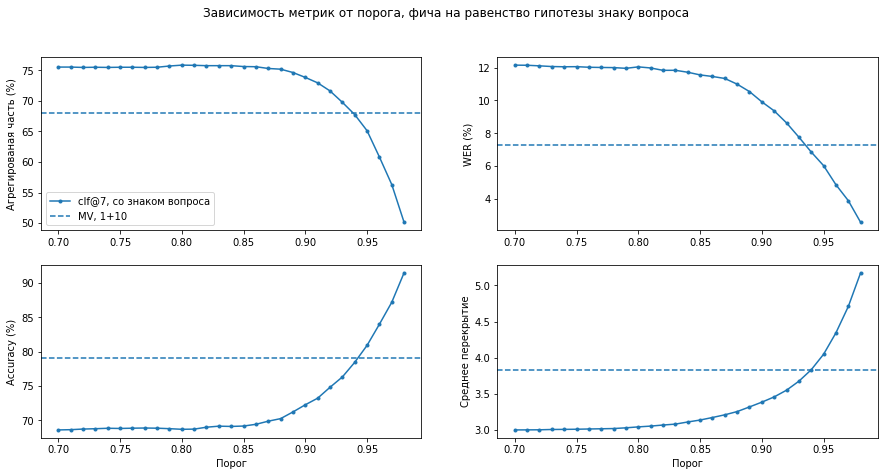

In [33]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, фича на равенство гипотезы знаку вопроса')
plt.subplot(221)
# plt.plot(scores_clf_test_new_feature[:, 0], 
#          scores_clf_test_new_feature[:, 1] * 100, 
#          ".-", 
#          label="clf@7, новые ГП")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 1] * 100, 
         ".-", 
         label="clf@7, со знаком вопроса")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, 1+10")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
# plt.plot(scores_clf_test_new_feature[:, 0], 
#          scores_clf_test_new_feature[:, 2] * 100, 
#          ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')


plt.subplot(223)
# plt.plot(scores_clf_test_new_feature[:, 0], 
#          scores_clf_test_new_feature[:, 3] * 100, 
#          ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
# plt.plot(scores_clf_test_new_feature[:, 0], 
#          scores_clf_test_new_feature[:, 4], 
#          ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_question_sign_assistant.png")
plt.show()

In [35]:
import pickle

In [37]:
with open('overlaps_assistant_2019_09_26.pickle', 'rb') as f:
    metrics_loaded = pickle.load(f)
metrics_loaded.keys()

dict_keys([(2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10)])

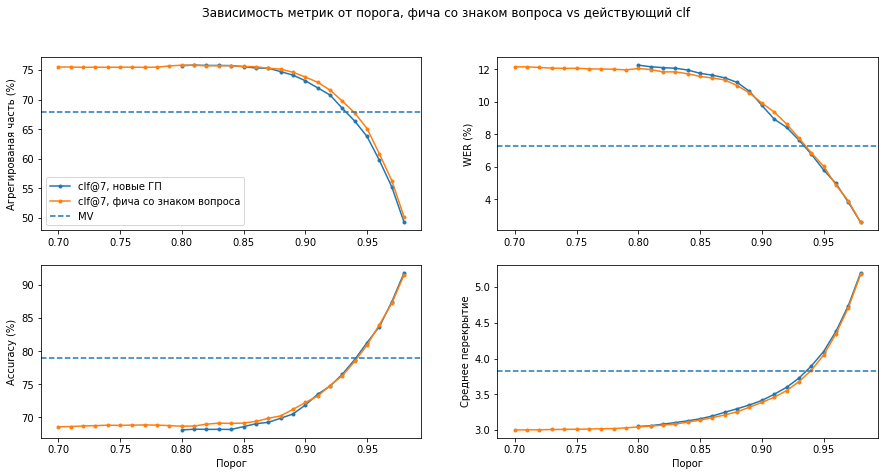

In [39]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, фича со знаком вопроса vs действующий clf')
plt.subplot(221)
plt.plot(metrics_loaded[(3, 7)][:, 0], 
         metrics_loaded[(3, 7)][:, 1] * 100, 
         ".-", 
         label="clf@7, новые ГП")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 1] * 100, 
         ".-", 
         label="clf@7, фича со знаком вопроса")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(metrics_loaded[(3, 7)][:, 0], 
         metrics_loaded[(3, 7)][:, 2] * 100, 
         ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(metrics_loaded[(3, 7)][:, 0], 
         metrics_loaded[(3, 7)][:, 3] * 100, 
         ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(metrics_loaded[(3, 7)][:, 0], 
         metrics_loaded[(3, 7)][:, 4], 
         ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_q_feature_vs_new_hp.png")
plt.show()

In [45]:
key = 'https://speechbase-yt.voicetech.yandex.net/getaudio/1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus'
len(test_features_q[key][1][0][''][0])

265

In [46]:
clf_q.save_model('assistant_2019-09-30_questions_prototype.clf')

In [ ]:
clf_q = CatBoostClassifier()
clf_q.load_model('assistant_2019-09-30_questions_prototype.clf')

In [562]:
clf_q.get_params()

{'loss_function': 'Logloss',
 'thread_count': 30,
 'depth': 7,
 'random_seed': 42,
 'iterations': 19000,
 'verbose': 1}

In [ ]:
min_overlaps = (2, 3)
max_overlaps = [i for i in range(4, 11)]
metrics_all = {}

In [ ]:
for min_i in min_overlaps:
    for max_i in max_overlaps:
        scores_clf_test = []
        print('min_i: {}\tmax_i: {}'.format(min_i, max_i))
        for treshhold in np.linspace(0.8, 0.98, 19):
            print(treshhold)
            metrics = evaluate_metrics_clf_(valid_rows, 
                                            test_features_q, 
                                            'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                            clf_q, 
                                            treshhold,
                                            min_cost=min_i,
                                            max_cost=max_i)
            scores_clf_test.append((treshhold, *metrics))
        scores_clf_test = np.array(scores_clf_test)
        metrics_all[(min_i, max_i)] = scores_clf_test

In [573]:
base_line = []

metrics = evaluate_metrics_clf_(valid_rows, 
                                test_features_q, 
                                'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                clf_q,
                                treshhold=0.948,
                                min_cost=3,
                                max_cost=7,
                                agg_method=partial(aggregate_rover_with_clf_,
                                                   preaggregated=preaggregated))
base_line += [0.948, *metrics]
base_line = np.array(base_line)

Recall: 85.6099%
WER: 6.8220%
Mean overlap: 4.001


In [591]:
evaluate_metrics_clf_(valid_rows, 
                        test_features_q, 
                        'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                        clf_q,
                        treshhold=0.948,
                        min_cost=3,
                        max_cost=7,
                        agg_method=partial(aggregate_rover_with_clf_,
                                           preaggregated=preaggregated))

Recall: 85.6099%
WER: 6.8220%
Mean overlap: 4.001


(0.8560986032503954, 0.06822048315753658, 4.0014343086632245)

In [577]:
base_line

array([0.948     , 0.8560986 , 0.06822048, 4.00143431])

In [583]:
with open('pickled/base_line_new_metrics_solo_assistant.pickle', 'wb') as f:
    pickle.dump(base_line, f)

In [29]:
needed_points = []
for over, metrics in metrics_all.items():
    prev = [1] * 6
    for threshold, aggregated, wer, acc, mean in metrics:
        if aggregated > base_line[1] and aggregated < prev[2]:
            prev = [over, threshold, aggregated, wer, acc, mean]
    needed_points.append(prev)   

In [31]:
import seaborn as sns
sns.set(style="whitegrid")

In [45]:
needed_points.append(['baseline'] + list(base_line))
needed_points.sort(key=lambda x: x[2], reverse=True)

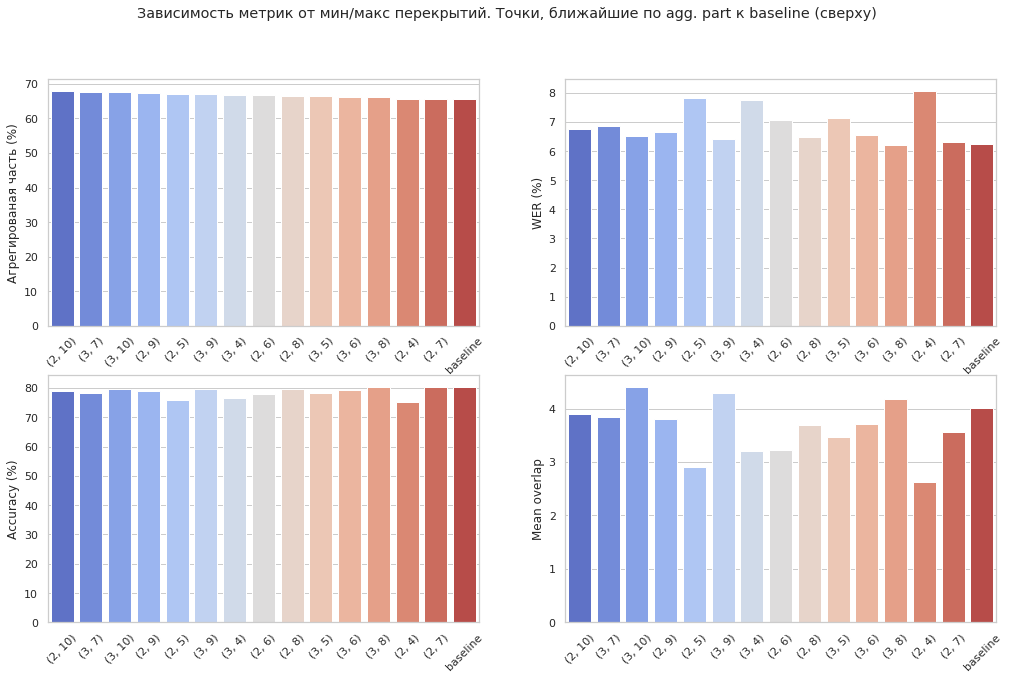

In [62]:
plt.figure(figsize=(17,10))
plt.suptitle('Зависимость метрик от мин/макс перекрытий. Точки, ближайшие по agg. part к baseline (сверху)')
plt.subplot(221)
plt.ylabel('Агрегированая часть (%)')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points])), 
                 y=[point[2]*100 for point in needed_points],
                 palette="coolwarm")
for item in ax.get_xticklabels():
    item.set_rotation(45)

plt.subplot(222)
plt.ylabel('WER (%)')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points])), 
                 y=[point[3]*100 for point in needed_points],
                 palette="coolwarm")
for item in ax.get_xticklabels():
    item.set_rotation(45)

plt.subplot(223)
plt.ylabel('Accuracy (%)')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points])), 
                 y=[point[4]*100 for point in needed_points],
                 palette="coolwarm")
for item in ax.get_xticklabels():
    item.set_rotation(45)

plt.subplot(224)
plt.ylabel('Mean overlap')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points])), 
                 y=[point[5] for point in needed_points],
                 palette="coolwarm")
for item in ax.get_xticklabels():
    item.set_rotation(45)
plt.show()

In [63]:
min_overlaps = (2, 3)
max_overlaps = [i for i in range(6, 11)]
metrics_all_repeat_2 = {}

In [67]:
for min_i in min_overlaps:
    for max_i in max_overlaps:
        scores_clf_test = []
        print('min_i: {}\tmax_i: {}'.format(min_i, max_i))
        for treshhold in np.linspace(0.8, 0.98, 37):
            print(treshhold)
            metrics = evaluate_metrics_clf_(valid_rows, 
                                            test_features_q, 
                                            'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                            clf_q, 
                                            treshhold,
                                            min_cost=min_i,
                                            max_cost=max_i)
            scores_clf_test.append((treshhold, *metrics))
        scores_clf_test = np.array(scores_clf_test)
        metrics_all_repeat_2[(min_i, max_i)] = scores_clf_test

min_i: 2	max_i: 6
0.8
Aggregated: 76.0757%
WER: 13.8502%
Accuracy: 64.7436%
Mean overlap: 2.105
0.805
Aggregated: 76.0184%
WER: 13.8288%
Accuracy: 64.6792%
Mean overlap: 2.114
0.81
Aggregated: 75.9323%
WER: 13.7965%
Accuracy: 64.7148%
Mean overlap: 2.122
0.8150000000000001
Aggregated: 75.8176%
WER: 13.6507%
Accuracy: 64.9262%
Mean overlap: 2.132
0.8200000000000001
Aggregated: 75.8462%
WER: 13.5277%
Accuracy: 65.0530%
Mean overlap: 2.151
0.8250000000000001
Aggregated: 75.6741%
WER: 13.4310%
Accuracy: 65.2009%
Mean overlap: 2.163
0.8300000000000001
Aggregated: 75.6741%
WER: 13.4660%
Accuracy: 65.2009%
Mean overlap: 2.18
0.8350000000000001
Aggregated: 75.5020%
WER: 13.2699%
Accuracy: 65.3116%
Mean overlap: 2.193
0.8400000000000001
Aggregated: 75.4733%
WER: 13.2265%
Accuracy: 65.3364%
Mean overlap: 2.216
0.845
Aggregated: 75.4159%
WER: 13.1096%
Accuracy: 65.5002%
Mean overlap: 2.229
0.85
Aggregated: 75.3873%
WER: 13.0763%
Accuracy: 65.4490%
Mean overlap: 2.254
0.855
Aggregated: 75.3299%
WE

Aggregated: 70.8835%
WER: 8.5910%
Accuracy: 73.8567%
Mean overlap: 3.175
0.935
Aggregated: 70.0229%
WER: 8.1594%
Accuracy: 75.0922%
Mean overlap: 3.282
0.94
Aggregated: 69.0476%
WER: 7.5977%
Accuracy: 76.6099%
Mean overlap: 3.421
0.9450000000000001
Aggregated: 67.7854%
WER: 7.1087%
Accuracy: 77.8248%
Mean overlap: 3.563
0.95
Aggregated: 66.5806%
WER: 6.4762%
Accuracy: 79.6639%
Mean overlap: 3.69
0.955
Aggregated: 64.8021%
WER: 5.8885%
Accuracy: 81.2749%
Mean overlap: 3.861
0.96
Aggregated: 63.0235%
WER: 5.1960%
Accuracy: 82.8858%
Mean overlap: 4.085
0.965
Aggregated: 61.3024%
WER: 4.8080%
Accuracy: 84.0898%
Mean overlap: 4.296
0.97
Aggregated: 59.2656%
WER: 4.2838%
Accuracy: 85.8664%
Mean overlap: 4.513
0.975
Aggregated: 56.6839%
WER: 3.7514%
Accuracy: 87.6012%
Mean overlap: 4.792
0.98
Aggregated: 53.3276%
WER: 3.0792%
Accuracy: 89.4567%
Mean overlap: 5.14
min_i: 2	max_i: 9
0.8
Aggregated: 76.1044%
WER: 13.8491%
Accuracy: 64.7569%
Mean overlap: 2.106
0.805
Aggregated: 76.0470%
WER: 13.

Aggregated: 71.0843%
WER: 8.6272%
Accuracy: 74.7780%
Mean overlap: 3.445
0.92
Aggregated: 70.3959%
WER: 8.2378%
Accuracy: 75.5094%
Mean overlap: 3.484
0.925
Aggregated: 69.6787%
WER: 7.8788%
Accuracy: 76.2454%
Mean overlap: 3.522
0.9299999999999999
Aggregated: 68.5600%
WER: 7.4357%
Accuracy: 77.1548%
Mean overlap: 3.586
0.935
Aggregated: 67.4986%
WER: 6.9948%
Accuracy: 78.3255%
Mean overlap: 3.64
0.94
Aggregated: 66.2077%
WER: 6.5514%
Accuracy: 79.3328%
Mean overlap: 3.717
0.9450000000000001
Aggregated: 64.6586%
WER: 6.1890%
Accuracy: 80.3904%
Mean overlap: 3.81
0.95
Aggregated: 63.0809%
WER: 5.6771%
Accuracy: 81.9463%
Mean overlap: 3.892
0.955
Aggregated: 60.8434%
WER: 5.2068%
Accuracy: 83.2626%
Mean overlap: 3.993
0.96
Aggregated: 58.8927%
WER: 4.6512%
Accuracy: 84.6566%
Mean overlap: 4.133
0.965
Aggregated: 56.8273%
WER: 4.3055%
Accuracy: 85.9162%
Mean overlap: 4.283
0.97
Aggregated: 54.5324%
WER: 3.6950%
Accuracy: 88.0589%
Mean overlap: 4.434
0.975
Aggregated: 51.6351%
WER: 3.0286%

Aggregated: 75.6741%
WER: 11.4774%
Accuracy: 69.3707%
Mean overlap: 3.181
0.865
Aggregated: 75.6454%
WER: 11.4188%
Accuracy: 69.5487%
Mean overlap: 3.197
0.87
Aggregated: 75.5881%
WER: 11.3687%
Accuracy: 69.7913%
Mean overlap: 3.223
0.875
Aggregated: 75.6168%
WER: 11.3201%
Accuracy: 69.8027%
Mean overlap: 3.248
0.88
Aggregated: 75.5594%
WER: 11.0491%
Accuracy: 70.1595%
Mean overlap: 3.272
0.885
Aggregated: 75.4446%
WER: 10.8445%
Accuracy: 70.4943%
Mean overlap: 3.304
0.89
Aggregated: 75.2725%
WER: 10.6532%
Accuracy: 70.8841%
Mean overlap: 3.348
0.895
Aggregated: 75.1004%
WER: 10.3882%
Accuracy: 71.2376%
Mean overlap: 3.388
0.9
Aggregated: 74.9570%
WER: 10.2797%
Accuracy: 71.6035%
Mean overlap: 3.431
0.905
Aggregated: 74.6414%
WER: 10.0211%
Accuracy: 72.0215%
Mean overlap: 3.469
0.91
Aggregated: 74.0103%
WER: 9.7666%
Accuracy: 72.5969%
Mean overlap: 3.523
0.915
Aggregated: 73.5513%
WER: 9.4745%
Accuracy: 73.3229%
Mean overlap: 3.583
0.92
Aggregated: 72.9203%
WER: 9.0393%
Accuracy: 74.15

In [68]:
needed_points = []
for over, metrics in metrics_all_repeat_2.items():
    prev = [1] * 6
    for threshold, aggregated, wer, acc, mean in metrics:
        if aggregated > base_line[1] and aggregated < prev[2]:
            prev = [over, threshold, aggregated, wer, acc, mean]
    needed_points.append(prev)   

In [69]:
needed_points.append(['baseline'] + list(base_line))
needed_points.sort(key=lambda x: x[2], reverse=True)

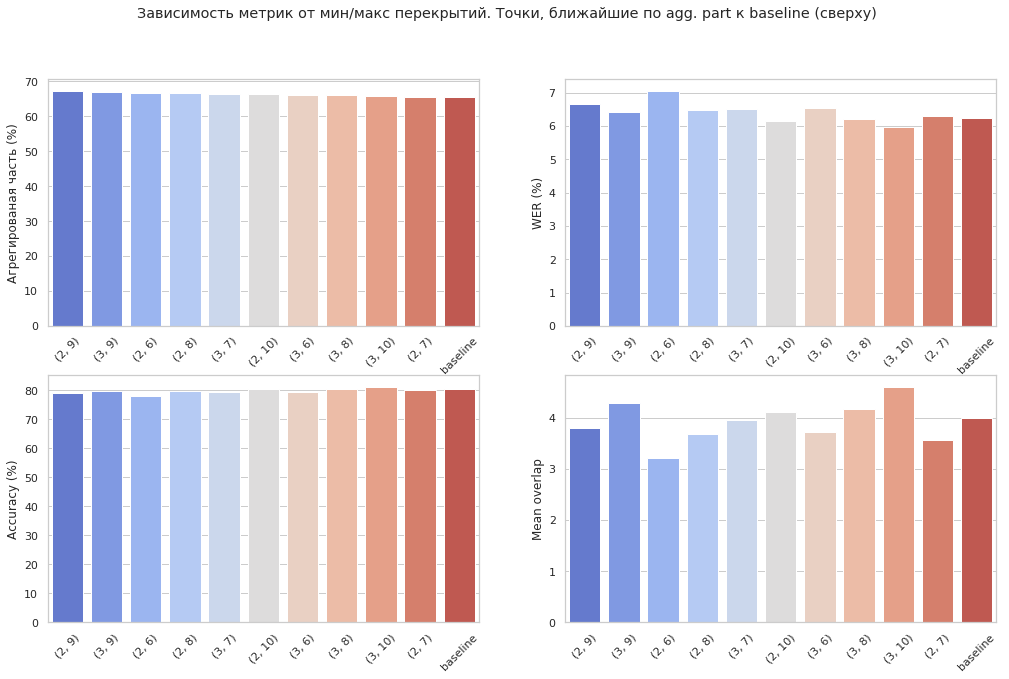

In [71]:
plt.figure(figsize=(17,10))
plt.suptitle('Зависимость метрик от мин/макс перекрытий. Точки, ближайшие по agg. part к baseline (сверху)')
plt.subplot(221)
plt.ylabel('Агрегированая часть (%)')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points])), 
                 y=[point[2]*100 for point in needed_points],
                 palette="coolwarm")
for item in ax.get_xticklabels():
    item.set_rotation(45)

plt.subplot(222)
plt.ylabel('WER (%)')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points])), 
                 y=[point[3]*100 for point in needed_points],
                 palette="coolwarm")
for item in ax.get_xticklabels():
    item.set_rotation(45)

plt.subplot(223)
plt.ylabel('Accuracy (%)')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points])), 
                 y=[point[4]*100 for point in needed_points],
                 palette="coolwarm")
for item in ax.get_xticklabels():
    item.set_rotation(45)

plt.subplot(224)
plt.ylabel('Mean overlap')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points])), 
                 y=[point[5] for point in needed_points],
                 palette="coolwarm")
for item in ax.get_xticklabels():
    item.set_rotation(45)
plt.show()

In [182]:
res_test1 = aggregate_rover_with_clf_(test_rows, 
                                     test_features_q,
                                     'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                     clf_q, 
                                     0.948,
                                     min_cost=3,
                                     max_cost=7)

In [183]:
res_test2 = aggregate_rover_with_clf_(test_rows, 
                                     test_features_q,
                                     'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                     clf_q, 
                                     0.948,
                                     min_cost=3,
                                     max_cost=7,
                                     preaggregated=preaggregated)

In [224]:
res_test2['127766/01a74b04-54ae-4441-9019-5c2c8814f91b_ef07f013-8ecf-4f0a-a516-c828714d8dde_75.opus']

AggregationResult(text='алиса ты мне не хватает', confidence=0.972598671796235, cost=3)

In [250]:
tmp = []
for key, value in res_test2.items():
    tmp.append({'mds_key': key,
               'text': value.text,
               'confidence': value.confidence,
               'cost': value.cost})
tmp = pd.DataFrame(tmp)
tmp['aggregated'] = 1
tmp.loc[(tmp['text'] == '') | (tmp['confidence'] < 0.948),'aggregated'] = 0
tmp.describe()

,confidence,cost,aggregated
count,3486.000000,3486.000000,3486.000000
mean,0.853562,4.001434,0.656053
std,0.319257,1.483626,0.475092
min,0.000000,3.000000,0.000000
25%,0.954553,3.000000,0.000000
50%,0.967864,3.000000,1.000000
75%,0.986520,5.000000,1.000000
max,0.996546,7.000000,1.000000


In [191]:
for key in res_test1.keys():
    if res_test1[key] != res_test2[key]:
        print(res_test1[key], res_test2[key], '\n')

In [587]:
results_with_empty[0]

{'mds_key': '1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus',
 'true_text': '',
 'predicted_text': None,
 'cost': 5,
 'confidence': 0}

In [112]:
yt.write_table('//home/voice/vklyukin/irover_test_results/assistant_with_empty', results_with_empty)

In [121]:
yt.write_table('//home/voice/vklyukin/irover_test_results/assistant_wo_empty', results_wo_empty)

In [540]:
def aggregate_rover_with_clf_by_word(rows, features, field_name, clf, threshold_by_word=0.9, treshhold=0.94,
                                     min_cost=3, max_cost=10, cluster_references=None, preaggregated=None):
    """
       experiments with question sign exchange
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    changed_signs_in_aggregated = 0
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost:
                continue
#             tokens = [value if score > threshold_by_word else '?' for value, score in item1]
            tokens = []
            changed = False
            for value, score in item1:
                if score > threshold_by_word or value == "":
                    tokens.append(value)
                else:
                    tokens.append("?")
                    changed = True
            text = " ".join(value for value in tokens if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= threshold or cost == max_cost: #MAX_NUM_ANSWERS:
#                 if text == "":
#                     conf = 0
#                     text = None
#                 elif score < treshhold:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                    if changed:
                        changed_signs_in_aggregated += 1
                results[task_id] = AggregationResult(text, conf, cost)
                break
    print("Number of aggregated ann. w/ changed \'?\': {}".format(changed_signs_in_aggregated))
    return results

In [122]:
preaggregated = preaggregate_with_clf(test_features_q, clf_q)

In [551]:
with open('preaggregated_assistant_with_solo_assistant_question.pickle', 'wb') as f:
    pickle.dump(preaggregated, f)

In [174]:
preaggregated['1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus']

{1: [('', 0.6846747656650313)],
 2: [('', 0.8797422806822525)],
 3: [('', 0.935914017338639)],
 4: [('', 0.9476157703498646)],
 5: [('', 0.9642552025849801)],
 6: [('', 0.9860052903329602)],
 7: [('', 0.9829542698996759)],
 8: [('', 0.9819593114274828)],
 9: [('', 0.9882454214427111)],
 10: [('', 0.9902087289873817)]}

In [176]:
res_with_words = aggregate_rover_with_clf_by_word(test_rows, 
                                 test_features_q,
                                 'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                 clf_q, 
                                 threshold_by_word=0.935,
                                 threshold=0.94,
                                 min_cost=3,
                                 max_cost=7,
                                 preaggregated=preaggregated)

Number of aggregated ann. w/ changed '?': 70


In [195]:
conf_0 = 0
for key, value in res_with_words.items():
    if value.confidence == 0:
        conf_0 += 1
conf_0 / len(res_with_words)

0.6603557085484796

In [260]:
scores_clf_test_q_ = []

for treshhold in np.linspace(0.8, 0.98, 19):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features_q, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    clf_q, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7,
                                    agg_method=partial(aggregate_rover_with_clf_,
                                                       preaggregated=preaggregated))
    scores_clf_test_q_.append((treshhold, *metrics))
scores_clf_test_q_ = np.array(scores_clf_test_q)

0.8
Aggregated: 75.8462%
WER: 11.8802%
Accuracy: 68.9864%
Mean overlap: 3.045
0.81
Aggregated: 75.8176%
WER: 11.8329%
Accuracy: 68.9368%
Mean overlap: 3.056
0.8200000000000001
Aggregated: 75.7602%
WER: 11.6881%
Accuracy: 69.2541%
Mean overlap: 3.07
0.8300000000000001
Aggregated: 75.7602%
WER: 11.6903%
Accuracy: 69.4055%
Mean overlap: 3.083
0.8400000000000001
Aggregated: 75.7602%
WER: 11.5977%
Accuracy: 69.3677%
Mean overlap: 3.112
0.85
Aggregated: 75.6168%
WER: 11.4345%
Accuracy: 69.4234%
Mean overlap: 3.139
0.86
Aggregated: 75.5881%
WER: 11.3582%
Accuracy: 69.6015%
Mean overlap: 3.174
0.87
Aggregated: 75.3012%
WER: 11.2428%
Accuracy: 70.0190%
Mean overlap: 3.212
0.88
Aggregated: 75.1865%
WER: 10.9153%
Accuracy: 70.3930%
Mean overlap: 3.256
0.89
Aggregated: 74.6414%
WER: 10.4884%
Accuracy: 71.2913%
Mean overlap: 3.321
0.9
Aggregated: 73.8382%
WER: 9.8909%
Accuracy: 72.2999%
Mean overlap: 3.387
0.91
Aggregated: 72.9489%
WER: 9.3479%
Accuracy: 73.2599%
Mean overlap: 3.459
0.92
Aggregated

In [153]:
from functools import partial

In [541]:
scores_clf_score_by_word_q = []

for threshhold in np.linspace(0.92, 0.96, 20):
    print(threshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features_q, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    clf_q, 
                                    0.94,
                                    min_cost=3,
                                    max_cost=7,
                                    agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                       threshold_by_word=threshhold,
                                                       preaggregated=preaggregated))
    scores_clf_score_by_word_q.append((treshhold, *metrics))
scores_clf_score_by_word_q = np.array(scores_clf_score_by_word_q)

0.92
Number of aggregated ann. w/ changed '?': 454
Recall: 75.9866%
WER: 4.4236%
Mean overlap: 5.176
0.9221052631578948
Number of aggregated ann. w/ changed '?': 466
Recall: 75.7512%
WER: 4.4169%
Mean overlap: 5.176
0.9242105263157895
Number of aggregated ann. w/ changed '?': 476
Recall: 75.5833%
WER: 4.4054%
Mean overlap: 5.176
0.9263157894736842
Number of aggregated ann. w/ changed '?': 480
Recall: 75.5067%
WER: 4.3917%
Mean overlap: 5.176
0.9284210526315789
Number of aggregated ann. w/ changed '?': 487


KeyboardInterrupt: 

In [278]:
from utils.majority_vote import aggregate_prod_fixed

In [274]:
%load_ext autoreload
%autoreload 2

In [282]:
import re

In [454]:
def aggregate_prod_fixed(raw_data,num_annot=10):
    for overlap in range(3,num_annot+1):
        fixed_text_speech=[elem['text'].lower().replace('ё', 'е') for elem in raw_data[:overlap]]
        worker_ids=[elem['worker_id'] for elem in raw_data[:overlap]]
        text_without_quest_mark=[elem for elem in fixed_text_speech if '?' not in elem]
        text_with_quest_mark=[elem for elem in fixed_text_speech if '?' in elem]
        texts = Counter()

        for text in text_without_quest_mark:
            texts[text]+=1
        for text_q in text_with_quest_mark:
            pattern=re.compile(text_q.replace('?','(\w+){0,3}?'))
            for text in text_without_quest_mark:
                if re.match(pattern,text):
                    texts[text]+=0.3
        for text_q in text_with_quest_mark:
            clean=' '.join(text_q.replace('?','').split())
            texts[clean]+=0.1
        text, text_rate = max(texts.items(), key=lambda x: x[1])
        if text_rate >= 0.5*overlap:
            conf = text_rate * 1.0 / sum(texts.values())
            used = overlap
            break
    else:
        if text_rate >= 0.375*overlap+0.1:
            conf = text_rate * 1.0 / sum(texts.values())
        else:
            text = None
            conf = 0
        used = num_annot
    return AggregationResult(text, conf, used)

In [455]:
# Maxim's baseline
mv_q_agg_metrics = utils_metrics.evaluate_metrics_for_algorithm(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    partial(aggregate_prod_fixed, num_annot=5))

Recall: 86.1285%
WER: 14.6910%
Mean overlap: 3.331


In [555]:
import hashlib

In [558]:
# Prod baseline
prod_agg_metrics = utils_metrics.evaluate_metrics_for_algorithm(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod)

Recall: 88.0521%
WER: 13.2758%
Mean overlap: 3.833


In [557]:
mv_q_agg_metrics = utils_metrics.evaluate_metrics_for_algorithm(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    partial(aggregate_prod_fixed, num_annot=5))

Recall: 86.1285%
WER: 14.6910%
Mean overlap: 3.331


In [491]:
metrics = evaluate_metrics_clf_(valid_rows, 
                                test_features_q, 
                                'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                clf_q, 
                                0.81,
                                min_cost=3,
                                max_cost=7,
                                agg_method=partial(aggregate_rover_with_clf_,
                                                   preaggregated=preaggregated))

Recall: 95.5599%
WER: 13.1307%
Mean overlap: 3.056


In [550]:
with open('new_metrics_solo_assistant.pickle', 'wb') as file:
    pickle.dump(scores_clf_test_new_wer, file)

In [456]:
scores_clf_test_new_wer = []

for treshhold in np.linspace(0.8, 0.98, 19):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features_q, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    clf_q, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7,
                                    agg_method=partial(aggregate_rover_with_clf_,
                                                       preaggregated=preaggregated))
    scores_clf_test_new_wer.append((treshhold, *metrics))
scores_clf_test_new_wer = np.array(scores_clf_test_new_wer)

0.8
Recall: 95.5396%
WER: 13.1776%
Mean overlap: 3.045
0.81
Recall: 95.5599%
WER: 13.1307%
Mean overlap: 3.056
0.8200000000000001
Recall: 95.4169%
WER: 12.9829%
Mean overlap: 3.07
0.8300000000000001
Recall: 95.4530%
WER: 12.9463%
Mean overlap: 3.083
0.8400000000000001
Recall: 95.4521%
WER: 12.8098%
Mean overlap: 3.112
0.85
Recall: 95.2188%
WER: 12.6762%
Mean overlap: 3.139
0.86
Recall: 95.2523%
WER: 12.5229%
Mean overlap: 3.174
0.87
Recall: 95.0146%
WER: 12.3408%
Mean overlap: 3.212
0.88
Recall: 94.8987%
WER: 12.0643%
Mean overlap: 3.256
0.89
Recall: 94.5536%
WER: 11.6419%
Mean overlap: 3.321
0.9
Recall: 93.7997%
WER: 11.0704%
Mean overlap: 3.387
0.91
Recall: 93.2000%
WER: 10.4187%
Mean overlap: 3.459
0.92
Recall: 92.0943%
WER: 9.6412%
Mean overlap: 3.552
0.9299999999999999
Recall: 90.1506%
WER: 8.6915%
Mean overlap: 3.676
0.94
Recall: 88.3156%
WER: 7.6132%
Mean overlap: 3.835
0.95
Recall: 85.5135%
WER: 6.5872%
Mean overlap: 4.049
0.96
Recall: 80.6015%
WER: 5.4006%
Mean overlap: 4.345


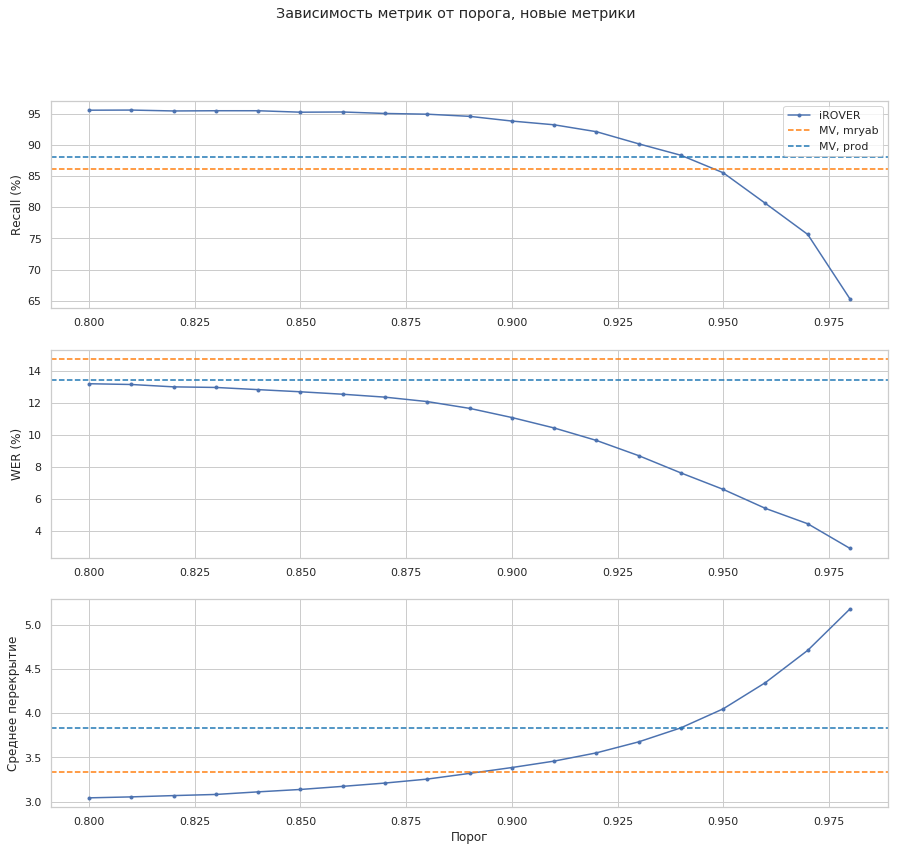

In [545]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от порога, новые метрики')
plt.subplot(311)
plt.plot(scores_clf_test_new_wer[:, 0], 
         scores_clf_test_new_wer[:, 1] * 100, 
         ".-", 
         label="iROVER")
plt.axhline(y=mv_q_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle='--', label="MV, mryab")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.legend()
plt.ylabel('Recall (%)')

plt.subplot(312)
plt.plot(scores_clf_test_new_wer[:, 0], 
         scores_clf_test_new_wer[:, 2] * 100, 
         ".-")
plt.axhline(y=mv_q_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle='--')
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
plt.plot(scores_clf_test_new_wer[:, 0], 
         scores_clf_test_new_wer[:, 3], 
         ".-")
plt.axhline(y=mv_q_agg_metrics[2], color=u'#ff7f0e', linestyle='--')
plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("new_metrics_question_feature.png")
plt.show()

In [530]:
def f_measure(recall, wer, beta=1):
    if wer is None:
        wer = 0.9999
        
    recall = max(0, recall)
    precision = max(1 - wer, 0)
    if precision + recall == 0:
        return 0
    return (1 + beta * beta) * precision * recall / (beta * beta * precision + recall)

In [536]:
def aggregate_prod_fixed_exp(raw_data, num_annot=5):
    for overlap in range(3, num_annot + 1):
        fixed_text_speech=[elem['text'].lower().replace('ё', 'е') for elem in raw_data[:overlap]]
        text_without_quest_mark=[elem for elem in fixed_text_speech if '?' not in elem]
        text_with_quest_mark=[elem for elem in fixed_text_speech if '?' in elem]
        texts = Counter()

        for text in text_without_quest_mark:
            texts[text] += 1
        for text_q in text_with_quest_mark:
            pattern=re.compile(text_q.replace('?','(\w+){0,3}?'))
            texts[text_q] += 0.0001
            for text in text_without_quest_mark:
                recall, _, _ = calc.calculate_word_recall(text, text_q)
                wer, _, _ = calc.calculate_wer(text, text_q)
                texts[text_q] += f_measure(recall, wer, 1)
                if re.match(pattern,text):
                    texts[text] += f_measure(recall, wer, 1)
                    texts[text_q] += f_measure(recall, wer, 1)
        text, text_rate = max(texts.items(), key=lambda x: x[1])
        if text_rate >= 0.5 * overlap:
            conf = text_rate * 1.0 / sum(texts.values())
            used = overlap
            break
    else:
        if text_rate >= 0.375 * overlap + 0.1:
            conf = text_rate * 1.0 / sum(texts.values())
        else:
            text = None
            conf = 0
        used = num_annot
    return AggregationResult(text, conf, used)

In [513]:
# Experiments
mv_q_exp = utils_metrics.evaluate_metrics_for_algorithm(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    partial(aggregate_prod_fixed_exp, num_annot=10))

Recall: 85.5072%
WER: 13.7304%
Mean overlap: 3.929


In [535]:
# Experiments
mv_q_exp = utils_metrics.evaluate_metrics_for_algorithm(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    partial(aggregate_prod_fixed_exp, num_annot=10))

Recall: 88.0633%
WER: 13.9214%
Mean overlap: 3.724


In [537]:
# Experiments
mv_q_exp = utils_metrics.evaluate_metrics_for_algorithm(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    partial(aggregate_prod_fixed_exp, num_annot=10))

Recall: 87.5305%
WER: 13.7900%
Mean overlap: 3.671


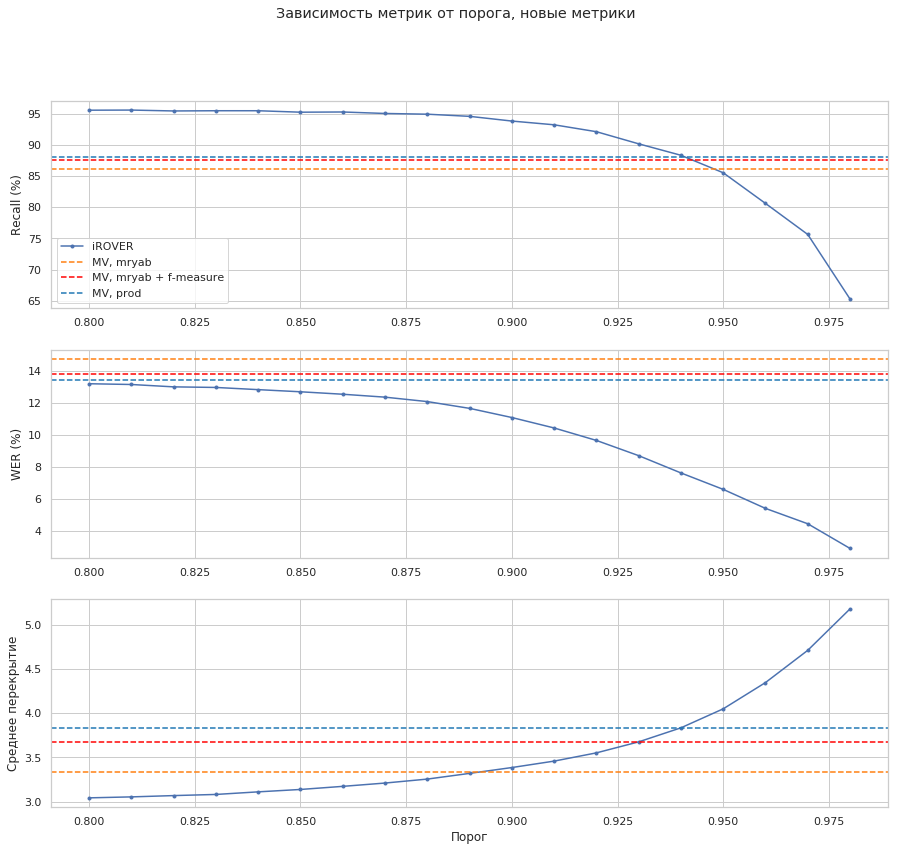

In [546]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от порога, новые метрики')
plt.subplot(311)
plt.plot(scores_clf_test_new_wer[:, 0], 
         scores_clf_test_new_wer[:, 1] * 100, 
         ".-", 
         label="iROVER")
plt.axhline(y=mv_q_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle='--', label="MV, mryab")
plt.axhline(y=mv_q_exp[0] * 100, color='red', linestyle='--', label="MV, mryab + f-measure")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.legend()
plt.ylabel('Recall (%)')

plt.subplot(312)
plt.plot(scores_clf_test_new_wer[:, 0], 
         scores_clf_test_new_wer[:, 2] * 100, 
         ".-")
plt.axhline(y=mv_q_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle='--')
plt.axhline(y=mv_q_exp[1] * 100, color='red', linestyle='--')
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
plt.plot(scores_clf_test_new_wer[:, 0], 
         scores_clf_test_new_wer[:, 3], 
         ".-")
plt.axhline(y=mv_q_agg_metrics[2], color=u'#ff7f0e', linestyle='--')
plt.axhline(y=mv_q_exp[2], color='red', linestyle='--')
plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("new_metrics_question_feature.png")
plt.show()

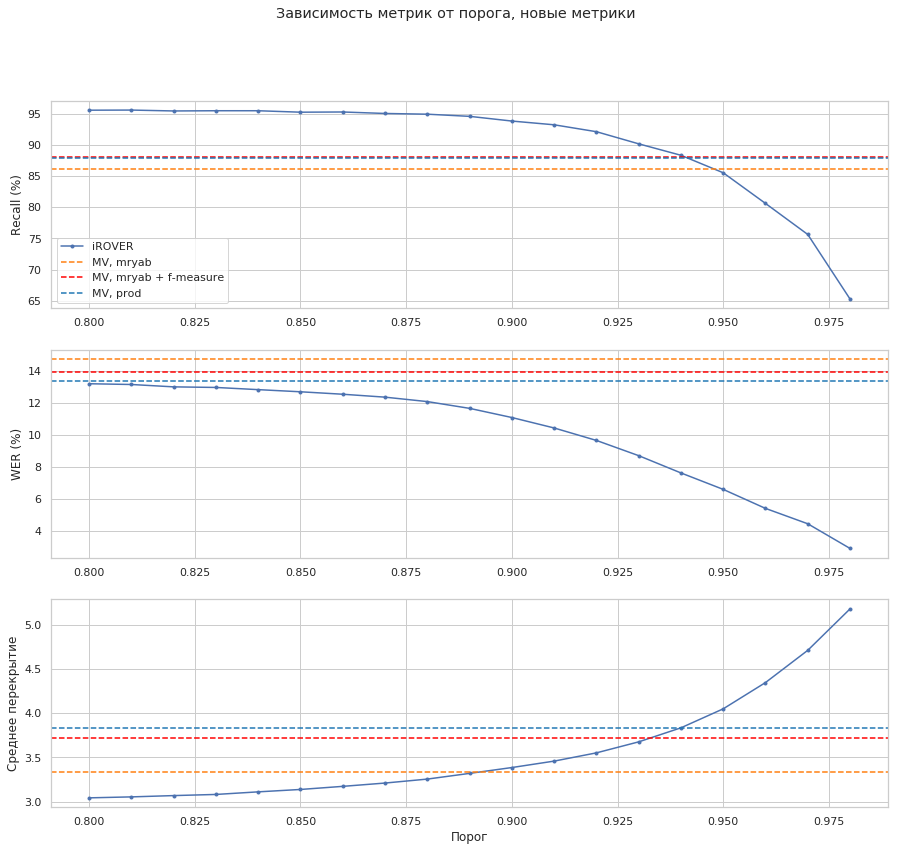

In [532]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от порога, новые метрики')
plt.subplot(311)
plt.plot(scores_clf_test_new_wer[:, 0], 
         scores_clf_test_new_wer[:, 1] * 100, 
         ".-", 
         label="iROVER")
plt.axhline(y=mv_q_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle='--', label="MV, mryab")
plt.axhline(y=mv_q_exp[0] * 100, color='red', linestyle='--', label="MV, mryab + f-measure")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.legend()
plt.ylabel('Recall (%)')

plt.subplot(312)
plt.plot(scores_clf_test_new_wer[:, 0], 
         scores_clf_test_new_wer[:, 2] * 100, 
         ".-")
plt.axhline(y=mv_q_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle='--')
plt.axhline(y=mv_q_exp[1] * 100, color='red', linestyle='--')
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
plt.plot(scores_clf_test_new_wer[:, 0], 
         scores_clf_test_new_wer[:, 3], 
         ".-")
plt.axhline(y=mv_q_agg_metrics[2], color=u'#ff7f0e', linestyle='--')
plt.axhline(y=mv_q_exp[2], color='red', linestyle='--')
plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

# plt.savefig("new_metrics_question_feature.png")
plt.show()